In [1]:
%matplotlib inline
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
mnist = tf.keras.datasets.mnist

In [2]:
def leakyReLU(x, alpha):
    return tf.maximum(alpha*x, x)

In [3]:
class Dataset:
    def __init__(self, train_images, train_labels, test_images, test_labels, projection_data_path, validation=0.0, shuffle=True):
        self.train_img = train_images
        self.train_labels = train_labels
        self.shuffle = shuffle
        self.projection_data_path = projection_data_path
        self.metadata_tsv = '%s/metadata.tsv' % projection_data_path
        self.sprite = '%s/sprite_train_img.png' % projection_data_path
        if self.shuffle:
            idx = np.arange(len(self.train_img))
            np.random.shuffle(idx)
            self.train_img = self.train_img[idx]
            self.train_labels = self.train_labels[idx]
        
        whole_train = len(train_images)
        num_validation_samples = int(whole_train*validation)
        num_train_sample = whole_train - num_validation_samples
        
        self.train_img = self.train_img[:num_train_sample,:,:]
        self.train_img = self.prepare_data(self.train_img)
        self.train_labels = self.train_labels[:num_train_sample]
        
        self.test_img = self.prepare_data(test_images)
        self.test_labels = test_labels
        
        if not validation == 0.0:
            self.validation_labels = self.train_labels[num_train_sample+1:]
            self.validation_img = self.train_img[num_train_sample+1:,:,:]
            self.validation_img = self.prepare_data(self.validation_img)        
            if len(self.train_img.shape)==3:
                new_shape = self.validation_img.shape + (1,)
                self.validation_img = self.validation_img.reshape(new_shape)

        
        if len(self.train_img.shape)==3:
            new_shape = self.train_img.shape + (1,)
            self.train_img = self.train_img.reshape(new_shape)
            new_shape = self.test_img.shape + (1,)
            self.test_img = self.test_img.reshape(new_shape)
        
        self.data_shape = self.train_img.shape
        
    def normalize(self, images):
        # Normalize.
        max_value = np.amax(images)
        post = images/max_value
        return post
    
    # Function to pre-process the data.
    def prepare_data(self, images):
        post_images = self.normalize(images)
        return post_images
    
    def batches(self, batch_size):
        n_batches = self.train_img.shape[0]//batch_size
        for index in range(0, n_batches):
            x = self.train_img[index:index+batch_size, :, :, :]
            y = self.train_labels[index:index+batch_size]
            yield (x, y)

    def random_test(self):
        idx = np.arange(len(self.test_img))
        np.random.shuffle(idx)
        return [self.test_img[idx[0], :, :]]
    
    def random_train(self):
        idx = np.arange(len(self.train_img))
        np.random.shuffle(idx)
        return [self.train_img[idx[0], :, :]]
    
    def create_sprite_image(self, images):
        if os.path.isfile(self.sprite):
            os.remove(self.sprite)

        img_h = images.shape[1]
        img_w = images.shape[2]
        n_plots = int(np.ceil(np.sqrt(images.shape[0])))
        spriteimage = np.ones((img_h * n_plots ,img_w * n_plots ))
        for i in range(n_plots):
            for j in range(n_plots):
                this_filter = i * n_plots + j
                if this_filter < images.shape[0]:
                    this_img = images[this_filter]
                    spriteimage[i * img_h:(i + 1) * img_h, j * img_w:(j + 1) * img_w] = this_img
        plt.imsave(self.sprite, spriteimage,cmap='gray')

    def create_tsv_file(self, img_labels):
        if os.path.isfile(self.metadata_tsv):
            os.remove(self.metadata_tsv)
        
        with open(self.metadata_tsv,'w') as f:
            f.write("Index\tLabel\n")
            for index,label in enumerate(img_labels):
                f.write("%d\t%d\n" % (index,label))

In [4]:
# Simple function to plot number images.
def plot_images(plt_num, images, dim, cmap):
    # Standard parameters for the plot.
    
    mpl.rcParams["figure.figsize"] = dim, dim
    fig = plt.figure()
    for i in range(0, plt_num):
        fig.add_subplot(1, 10, i+1)
        img = images[i, :, :, 0]
        plt.imshow(img, cmap=cmap)
    plt.show()

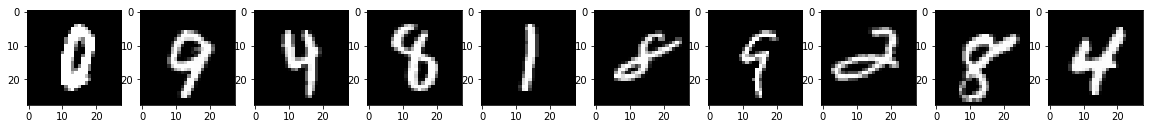

In [5]:
(train_images, train_labels),(test_images, test_labels) = mnist.load_data()
projection_data_path = '/Users/adalbertoclaudioquiros/Documents/Code/UofG/PhD/GANs'
data = Dataset(train_images, train_labels, test_images, test_labels, projection_data_path, validation=0.0, shuffle=True)

plot_images(plt_num=10, images=data.train_img, dim=20, cmap='gray')

In [6]:
def model_inputs(image_width, image_height, image_channels, z_dim):
    real_images = tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels), name='real_images')
    z_input = tf.placeholder(dtype=tf.float32, shape=(None, z_dim), name='z_input')
    learning_rate = tf.placeholder(dtype=tf.float32, name='learning_rate')
    return real_images, z_input, learning_rate

In [16]:
def discriminator(images, reuse, alpha):
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Padding = 'Same' -> H_new = H_old // Stride
        # Input Shape: (None, 28, 28, 1)
        
        net = tf.layers.conv2d(inputs=images, filters=64, kernel_size=(5,5), strides=(2, 2), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        net = leakyReLU(net, alpha)
        # Shape: (None, 16, 16, 128)
        
        net = tf.layers.conv2d(inputs=net, filters=128, kernel_size=(5,5), strides=(2, 2), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        net = tf.layers.batch_normalization(net, training=True)
        net = leakyReLU(net, alpha)
        # Shape: (None, 8, 8, 128)

        net = tf.layers.flatten(net)
        # Shape: (None, 8*8*128)

        # Dense.
        net = tf.layers.dense(net, 1024, activation=None)
        net = tf.layers.batch_normalization(net, training=True)
        net = leakyReLU(net, alpha)
        # Shape: (None, 1024)
        
        # Dense
        logits = tf.layers.dense(net, 1, activation=None)
        # Shape: (None, 1)
        output = tf.nn.sigmoid(logits)
        
        return output, logits

In [17]:
def generator(z_input, out_channel_dim, reuse, is_train, alpha):
    
    with tf.variable_scope('generator', reuse=reuse):
        
        # Fully
        net = tf.layers.dense(inputs=z_input, units=1024, activation=None)
        net = tf.layers.batch_normalization(net, training=is_train)
        net = leakyReLU(net, alpha)
        # Shape: (None, 1024)
        
        # Fully
        net = tf.layers.dense(inputs=net, units=128*7*7, activation=None)
        net = tf.layers.batch_normalization(net, training=is_train)
        net = leakyReLU(net, alpha)
        # Shape: (None, 128*7*7)
        
        net = tf.reshape(net, (-1, 7, 7, 128))
        # Shape: (None, 7, 7, 128)
        
        # Conv
        net = tf.layers.conv2d_transpose(inputs=net, filters=128, kernel_size=(5,5), strides=(2,2), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        net = tf.layers.batch_normalization(net, training=is_train)
        net = leakyReLU(net, alpha)
        # Shape: (None, 14, 14, 128)
        
        # Conv
        net = tf.layers.conv2d_transpose(inputs=net, filters=128, kernel_size=(5,5), strides=(1,1), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        net = tf.layers.batch_normalization(net, training=is_train)
        net = leakyReLU(net, alpha)
        # Shape: (None, 14, 14, 128)
        
        # Conv
        net = tf.layers.conv2d_transpose(inputs=net, filters=out_channel_dim, kernel_size=(5,5), strides=(2,2), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        # Shape: (None, 28, 28, 128)
        
        output = tf.nn.sigmoid(net)
        
        return output

In [18]:
def show_generated(session, output_fake, n_images, z_input, image_type):
    cmap = None if image_type == 'RGB' else 'gray'
    z_dim = z_input.get_shape()[-1]
    sample_z = np.random.uniform(low=-1., high=1., size=(n_images, z_dim))
    feed_dict = {z_input:sample_z}
    gen_samples = session.run(output_fake, feed_dict=feed_dict)
    
    gen_samples *= 255.
    
    plot_images(plt_num=n_images, images=gen_samples, dim=10, cmap=cmap)    

In [19]:
def loss(real_images, z_input, out_channel_dim, alpha):
    
    # Generator.
    fake_images = generator(z_input, out_channel_dim=out_channel_dim, reuse=False, is_train=True, alpha=alpha)
    
    # Discriminator.
    output_fake, logits_fake = discriminator(images=fake_images, reuse=False, alpha=alpha) 
    output_real, logits_real = discriminator(images=real_images, reuse=True, alpha=alpha)
    
    # Discriminator loss.
    loss_dis = 0.5*tf.reduce_mean(tf.square(output_real - 1.0)) + 0.5*tf.reduce_mean(tf.square(output_fake))

    # Generator loss.
    loss_gen = 0.5*tf.reduce_mean(tf.square(output_fake - 1.0))
    
    return loss_dis, loss_gen

In [20]:
def optimization(loss_dis, loss_gen, learning_rate, beta1):
    trainable_variables = tf.trainable_variables()
    generator_variables = [variable for variable in trainable_variables if variable.name.startswith('generator')]
    discriminator_variables = [variable for variable in trainable_variables if variable.name.startswith('discriminator')]
    
    # Handling Batch Normalization.
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        train_generator = tf.train.AdamOptimizer(learning_rate=learning_rate, 
                                                 beta1=beta1).minimize(loss_gen, var_list=generator_variables)
        train_discriminator = tf.train.AdamOptimizer(learning_rate=learning_rate, 
                                                     beta1=beta1).minimize(loss_dis, var_list=discriminator_variables)    
    return train_generator, train_discriminator

In [21]:
def train(epochs, batch_size, z_dim, learning_rate, beta1, dataset, image_type, alpha):
    
    dataset_size, image_width, image_height, image_channels = dataset.data_shape
    
    real_images, z_input, learning_rate_input = model_inputs(image_width=image_width, image_height=image_height, 
                                                            image_channels=image_channels, z_dim=z_dim)
    loss_dis, loss_gen = loss(real_images=real_images, z_input=z_input, out_channel_dim=image_channels, alpha=alpha)
    train_generator, train_discriminator = optimization(loss_dis=loss_dis, loss_gen=loss_gen, learning_rate=learning_rate_input, 
                                                       beta1=beta1)
    
    output_gen = generator(z_input=z_input, out_channel_dim=image_channels, reuse=True, is_train=False, alpha=alpha)

    samples = list()
    losses = list()
    run_epochs = 0
    
    show_epochs = 100
    print_epochs = 10
    n_images = 10
    
    images_e = 0
    
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        for epoch in range(epochs+1):
            get_batches = data.batches(batch_size)
            for batch_images, batch_labels in get_batches.__iter__():
                images_e += batch_images.shape[0]
                z_batch = np.random.uniform(low=-1., high=1., size=(batch_size, z_dim))
               
                feed_dict = {z_input:z_batch, real_images:batch_images, learning_rate_input: learning_rate}
                session.run(train_discriminator, feed_dict=feed_dict)
                session.run(train_generator, feed_dict=feed_dict)
               
                if run_epochs%print_epochs==0:
                    feed_dict = {z_input:z_batch, real_images:batch_images}
                    epoch_loss_dis = session.run(loss_dis, feed_dict=feed_dict)
                    epoch_loss_gen = session.run(loss_gen, feed_dict=feed_dict)
                    losses.append((epoch_loss_dis, epoch_loss_gen))
                    print('Epochs %s/%s: Generator Loss: %s. Discriminator Loss: %s' % (epoch, epochs, np.round(epoch_loss_gen, 3), 
                                                                                        np.round(epoch_loss_dis, 3)))
                if run_epochs%show_epochs == 0:
                    show_generated(session=session, output_fake=output_gen, n_images=n_images, z_input=z_input, 
                                   image_type=image_type)
                run_epochs+=1


Epochs 0/10: Generator Loss: 0.167. Discriminator Loss: 0.481


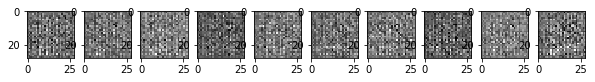

Epochs 0/10: Generator Loss: 0.174. Discriminator Loss: 0.306


Epochs 0/10: Generator Loss: 0.237. Discriminator Loss: 0.284


Epochs 0/10: Generator Loss: 0.262. Discriminator Loss: 0.267


Epochs 0/10: Generator Loss: 0.242. Discriminator Loss: 0.261


Epochs 0/10: Generator Loss: 0.305. Discriminator Loss: 0.172


Epochs 0/10: Generator Loss: 0.351. Discriminator Loss: 0.147


Epochs 0/10: Generator Loss: 0.341. Discriminator Loss: 0.175


Epochs 0/10: Generator Loss: 0.311. Discriminator Loss: 0.163


Epochs 0/10: Generator Loss: 0.355. Discriminator Loss: 0.14


Epochs 0/10: Generator Loss: 0.339. Discriminator Loss: 0.132


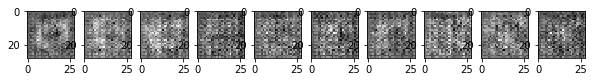

Epochs 0/10: Generator Loss: 0.352. Discriminator Loss: 0.156


Epochs 0/10: Generator Loss: 0.398. Discriminator Loss: 0.126


Epochs 0/10: Generator Loss: 0.378. Discriminator Loss: 0.202


Epochs 0/10: Generator Loss: 0.385. Discriminator Loss: 0.202


Epochs 0/10: Generator Loss: 0.389. Discriminator Loss: 0.195


Epochs 0/10: Generator Loss: 0.426. Discriminator Loss: 0.195


Epochs 0/10: Generator Loss: 0.416. Discriminator Loss: 0.186


Epochs 0/10: Generator Loss: 0.402. Discriminator Loss: 0.197


Epochs 0/10: Generator Loss: 0.37. Discriminator Loss: 0.183


Epochs 0/10: Generator Loss: 0.353. Discriminator Loss: 0.249


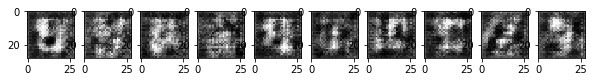

Epochs 0/10: Generator Loss: 0.402. Discriminator Loss: 0.234


Epochs 0/10: Generator Loss: 0.363. Discriminator Loss: 0.27


Epochs 0/10: Generator Loss: 0.439. Discriminator Loss: 0.213


Epochs 0/10: Generator Loss: 0.434. Discriminator Loss: 0.215


Epochs 0/10: Generator Loss: 0.402. Discriminator Loss: 0.192


Epochs 0/10: Generator Loss: 0.405. Discriminator Loss: 0.192


Epochs 0/10: Generator Loss: 0.355. Discriminator Loss: 0.223


Epochs 0/10: Generator Loss: 0.395. Discriminator Loss: 0.147


Epochs 0/10: Generator Loss: 0.359. Discriminator Loss: 0.175


Epochs 0/10: Generator Loss: 0.377. Discriminator Loss: 0.23


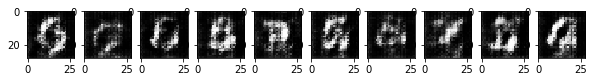

Epochs 0/10: Generator Loss: 0.399. Discriminator Loss: 0.21


Epochs 0/10: Generator Loss: 0.355. Discriminator Loss: 0.26


Epochs 0/10: Generator Loss: 0.358. Discriminator Loss: 0.184


Epochs 0/10: Generator Loss: 0.353. Discriminator Loss: 0.255


Epochs 0/10: Generator Loss: 0.369. Discriminator Loss: 0.28


Epochs 0/10: Generator Loss: 0.379. Discriminator Loss: 0.274


Epochs 0/10: Generator Loss: 0.392. Discriminator Loss: 0.249


Epochs 0/10: Generator Loss: 0.429. Discriminator Loss: 0.177


Epochs 0/10: Generator Loss: 0.345. Discriminator Loss: 0.238


Epochs 0/10: Generator Loss: 0.35. Discriminator Loss: 0.215


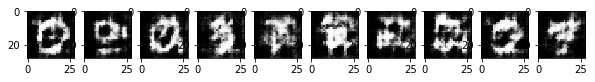

Epochs 0/10: Generator Loss: 0.379. Discriminator Loss: 0.235


Epochs 0/10: Generator Loss: 0.385. Discriminator Loss: 0.228


Epochs 0/10: Generator Loss: 0.393. Discriminator Loss: 0.245


Epochs 0/10: Generator Loss: 0.361. Discriminator Loss: 0.265


Epochs 0/10: Generator Loss: 0.377. Discriminator Loss: 0.22


Epochs 0/10: Generator Loss: 0.379. Discriminator Loss: 0.216


Epochs 0/10: Generator Loss: 0.322. Discriminator Loss: 0.28


Epochs 0/10: Generator Loss: 0.409. Discriminator Loss: 0.239


Epochs 0/10: Generator Loss: 0.421. Discriminator Loss: 0.216


Epochs 0/10: Generator Loss: 0.297. Discriminator Loss: 0.303


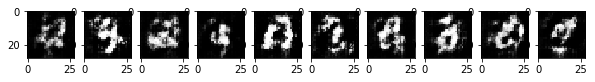

Epochs 0/10: Generator Loss: 0.369. Discriminator Loss: 0.238


Epochs 0/10: Generator Loss: 0.399. Discriminator Loss: 0.25


Epochs 0/10: Generator Loss: 0.348. Discriminator Loss: 0.287


Epochs 0/10: Generator Loss: 0.423. Discriminator Loss: 0.213


Epochs 0/10: Generator Loss: 0.392. Discriminator Loss: 0.186


Epochs 0/10: Generator Loss: 0.413. Discriminator Loss: 0.199


Epochs 0/10: Generator Loss: 0.38. Discriminator Loss: 0.218


Epochs 0/10: Generator Loss: 0.362. Discriminator Loss: 0.21


Epochs 0/10: Generator Loss: 0.382. Discriminator Loss: 0.203


Epochs 0/10: Generator Loss: 0.345. Discriminator Loss: 0.21


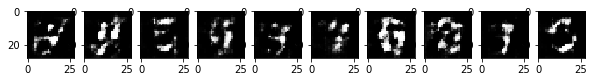

Epochs 0/10: Generator Loss: 0.362. Discriminator Loss: 0.222


Epochs 0/10: Generator Loss: 0.4. Discriminator Loss: 0.187


Epochs 0/10: Generator Loss: 0.391. Discriminator Loss: 0.24


Epochs 0/10: Generator Loss: 0.375. Discriminator Loss: 0.195


Epochs 0/10: Generator Loss: 0.362. Discriminator Loss: 0.289


Epochs 0/10: Generator Loss: 0.429. Discriminator Loss: 0.203


Epochs 0/10: Generator Loss: 0.382. Discriminator Loss: 0.28


Epochs 0/10: Generator Loss: 0.404. Discriminator Loss: 0.25


Epochs 0/10: Generator Loss: 0.39. Discriminator Loss: 0.28


Epochs 0/10: Generator Loss: 0.404. Discriminator Loss: 0.213


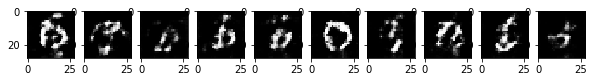

Epochs 0/10: Generator Loss: 0.393. Discriminator Loss: 0.202


Epochs 0/10: Generator Loss: 0.371. Discriminator Loss: 0.239


Epochs 0/10: Generator Loss: 0.419. Discriminator Loss: 0.248


Epochs 0/10: Generator Loss: 0.424. Discriminator Loss: 0.263


Epochs 0/10: Generator Loss: 0.416. Discriminator Loss: 0.239


Epochs 0/10: Generator Loss: 0.393. Discriminator Loss: 0.272


Epochs 0/10: Generator Loss: 0.399. Discriminator Loss: 0.272


Epochs 0/10: Generator Loss: 0.406. Discriminator Loss: 0.267


Epochs 0/10: Generator Loss: 0.403. Discriminator Loss: 0.247


Epochs 0/10: Generator Loss: 0.364. Discriminator Loss: 0.271


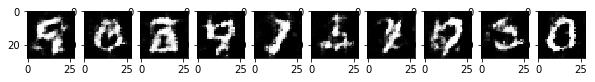

Epochs 0/10: Generator Loss: 0.373. Discriminator Loss: 0.238


Epochs 0/10: Generator Loss: 0.385. Discriminator Loss: 0.184


Epochs 0/10: Generator Loss: 0.346. Discriminator Loss: 0.196


Epochs 0/10: Generator Loss: 0.363. Discriminator Loss: 0.238


Epochs 0/10: Generator Loss: 0.449. Discriminator Loss: 0.223


Epochs 0/10: Generator Loss: 0.375. Discriminator Loss: 0.291


Epochs 0/10: Generator Loss: 0.427. Discriminator Loss: 0.203


Epochs 0/10: Generator Loss: 0.349. Discriminator Loss: 0.277


Epochs 0/10: Generator Loss: 0.391. Discriminator Loss: 0.229


Epochs 0/10: Generator Loss: 0.404. Discriminator Loss: 0.265


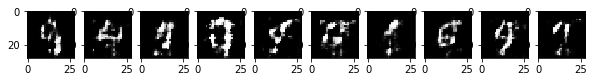

Epochs 0/10: Generator Loss: 0.333. Discriminator Loss: 0.359


Epochs 0/10: Generator Loss: 0.427. Discriminator Loss: 0.283


Epochs 0/10: Generator Loss: 0.4. Discriminator Loss: 0.254


Epochs 0/10: Generator Loss: 0.411. Discriminator Loss: 0.247


Epochs 0/10: Generator Loss: 0.41. Discriminator Loss: 0.228


Epochs 0/10: Generator Loss: 0.414. Discriminator Loss: 0.208


Epochs 0/10: Generator Loss: 0.405. Discriminator Loss: 0.236


Epochs 0/10: Generator Loss: 0.388. Discriminator Loss: 0.293


Epochs 0/10: Generator Loss: 0.435. Discriminator Loss: 0.279


Epochs 0/10: Generator Loss: 0.37. Discriminator Loss: 0.226


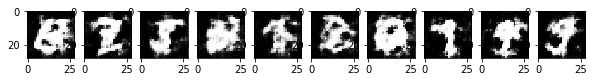

Epochs 0/10: Generator Loss: 0.431. Discriminator Loss: 0.223


Epochs 0/10: Generator Loss: 0.398. Discriminator Loss: 0.244


Epochs 0/10: Generator Loss: 0.378. Discriminator Loss: 0.266


Epochs 0/10: Generator Loss: 0.35. Discriminator Loss: 0.275


Epochs 0/10: Generator Loss: 0.382. Discriminator Loss: 0.24


Epochs 0/10: Generator Loss: 0.408. Discriminator Loss: 0.25


Epochs 0/10: Generator Loss: 0.406. Discriminator Loss: 0.245


Epochs 0/10: Generator Loss: 0.409. Discriminator Loss: 0.224


Epochs 0/10: Generator Loss: 0.381. Discriminator Loss: 0.256


Epochs 0/10: Generator Loss: 0.418. Discriminator Loss: 0.244


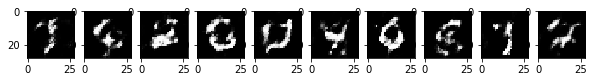

Epochs 0/10: Generator Loss: 0.427. Discriminator Loss: 0.239


Epochs 0/10: Generator Loss: 0.429. Discriminator Loss: 0.234


Epochs 0/10: Generator Loss: 0.384. Discriminator Loss: 0.256


Epochs 0/10: Generator Loss: 0.398. Discriminator Loss: 0.307


Epochs 0/10: Generator Loss: 0.416. Discriminator Loss: 0.33


Epochs 0/10: Generator Loss: 0.364. Discriminator Loss: 0.319


Epochs 0/10: Generator Loss: 0.412. Discriminator Loss: 0.215


Epochs 0/10: Generator Loss: 0.405. Discriminator Loss: 0.279


Epochs 0/10: Generator Loss: 0.4. Discriminator Loss: 0.255


Epochs 0/10: Generator Loss: 0.39. Discriminator Loss: 0.268


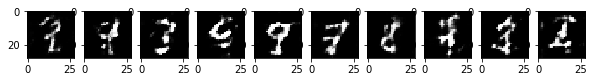

Epochs 0/10: Generator Loss: 0.37. Discriminator Loss: 0.22


Epochs 0/10: Generator Loss: 0.407. Discriminator Loss: 0.226


Epochs 0/10: Generator Loss: 0.354. Discriminator Loss: 0.275


Epochs 0/10: Generator Loss: 0.423. Discriminator Loss: 0.228


Epochs 0/10: Generator Loss: 0.385. Discriminator Loss: 0.242


Epochs 0/10: Generator Loss: 0.397. Discriminator Loss: 0.259


Epochs 0/10: Generator Loss: 0.443. Discriminator Loss: 0.261


Epochs 0/10: Generator Loss: 0.434. Discriminator Loss: 0.243


Epochs 0/10: Generator Loss: 0.401. Discriminator Loss: 0.242


Epochs 0/10: Generator Loss: 0.401. Discriminator Loss: 0.234


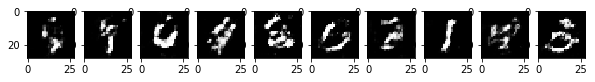

Epochs 0/10: Generator Loss: 0.389. Discriminator Loss: 0.249


Epochs 0/10: Generator Loss: 0.422. Discriminator Loss: 0.242


Epochs 0/10: Generator Loss: 0.442. Discriminator Loss: 0.262


Epochs 0/10: Generator Loss: 0.425. Discriminator Loss: 0.245


Epochs 0/10: Generator Loss: 0.43. Discriminator Loss: 0.25


Epochs 0/10: Generator Loss: 0.42. Discriminator Loss: 0.232


Epochs 0/10: Generator Loss: 0.435. Discriminator Loss: 0.275


Epochs 0/10: Generator Loss: 0.439. Discriminator Loss: 0.245


Epochs 0/10: Generator Loss: 0.408. Discriminator Loss: 0.244


Epochs 0/10: Generator Loss: 0.409. Discriminator Loss: 0.217


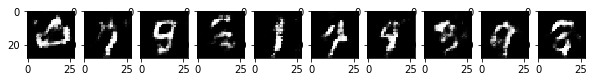

Epochs 0/10: Generator Loss: 0.382. Discriminator Loss: 0.228


Epochs 0/10: Generator Loss: 0.412. Discriminator Loss: 0.218


Epochs 0/10: Generator Loss: 0.404. Discriminator Loss: 0.227


Epochs 0/10: Generator Loss: 0.436. Discriminator Loss: 0.192


Epochs 0/10: Generator Loss: 0.396. Discriminator Loss: 0.188


Epochs 0/10: Generator Loss: 0.406. Discriminator Loss: 0.195


Epochs 0/10: Generator Loss: 0.417. Discriminator Loss: 0.25


Epochs 0/10: Generator Loss: 0.465. Discriminator Loss: 0.287


Epochs 0/10: Generator Loss: 0.448. Discriminator Loss: 0.262


Epochs 0/10: Generator Loss: 0.43. Discriminator Loss: 0.217


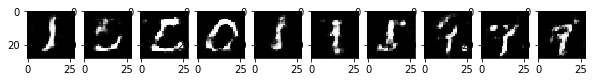

Epochs 0/10: Generator Loss: 0.395. Discriminator Loss: 0.183


Epochs 0/10: Generator Loss: 0.344. Discriminator Loss: 0.211


Epochs 0/10: Generator Loss: 0.391. Discriminator Loss: 0.209


Epochs 0/10: Generator Loss: 0.434. Discriminator Loss: 0.275


Epochs 0/10: Generator Loss: 0.399. Discriminator Loss: 0.294


Epochs 0/10: Generator Loss: 0.405. Discriminator Loss: 0.273


Epochs 0/10: Generator Loss: 0.452. Discriminator Loss: 0.195


Epochs 0/10: Generator Loss: 0.409. Discriminator Loss: 0.228


Epochs 0/10: Generator Loss: 0.42. Discriminator Loss: 0.239


Epochs 0/10: Generator Loss: 0.452. Discriminator Loss: 0.256


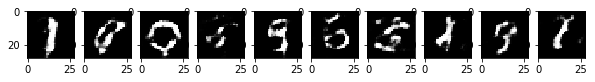

Epochs 0/10: Generator Loss: 0.417. Discriminator Loss: 0.268


Epochs 0/10: Generator Loss: 0.43. Discriminator Loss: 0.278


Epochs 0/10: Generator Loss: 0.449. Discriminator Loss: 0.282


Epochs 0/10: Generator Loss: 0.408. Discriminator Loss: 0.299


Epochs 0/10: Generator Loss: 0.367. Discriminator Loss: 0.288


Epochs 0/10: Generator Loss: 0.428. Discriminator Loss: 0.27


Epochs 0/10: Generator Loss: 0.454. Discriminator Loss: 0.267


Epochs 0/10: Generator Loss: 0.389. Discriminator Loss: 0.259


Epochs 0/10: Generator Loss: 0.404. Discriminator Loss: 0.252


Epochs 0/10: Generator Loss: 0.386. Discriminator Loss: 0.29


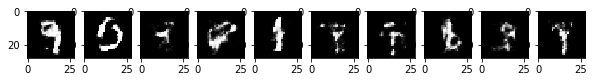

Epochs 0/10: Generator Loss: 0.399. Discriminator Loss: 0.255


Epochs 0/10: Generator Loss: 0.403. Discriminator Loss: 0.22


Epochs 0/10: Generator Loss: 0.429. Discriminator Loss: 0.209


Epochs 0/10: Generator Loss: 0.432. Discriminator Loss: 0.244


Epochs 0/10: Generator Loss: 0.407. Discriminator Loss: 0.276


Epochs 0/10: Generator Loss: 0.45. Discriminator Loss: 0.26


Epochs 0/10: Generator Loss: 0.427. Discriminator Loss: 0.303


Epochs 0/10: Generator Loss: 0.441. Discriminator Loss: 0.265


Epochs 0/10: Generator Loss: 0.441. Discriminator Loss: 0.23


Epochs 0/10: Generator Loss: 0.401. Discriminator Loss: 0.23


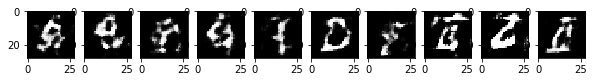

Epochs 0/10: Generator Loss: 0.372. Discriminator Loss: 0.252


Epochs 0/10: Generator Loss: 0.395. Discriminator Loss: 0.251


Epochs 0/10: Generator Loss: 0.398. Discriminator Loss: 0.237


Epochs 0/10: Generator Loss: 0.384. Discriminator Loss: 0.218


Epochs 0/10: Generator Loss: 0.385. Discriminator Loss: 0.251


Epochs 0/10: Generator Loss: 0.381. Discriminator Loss: 0.263


Epochs 0/10: Generator Loss: 0.392. Discriminator Loss: 0.276


Epochs 1/10: Generator Loss: 0.382. Discriminator Loss: 0.357


Epochs 1/10: Generator Loss: 0.422. Discriminator Loss: 0.216


Epochs 1/10: Generator Loss: 0.394. Discriminator Loss: 0.194


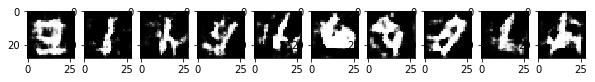

Epochs 1/10: Generator Loss: 0.41. Discriminator Loss: 0.2


Epochs 1/10: Generator Loss: 0.402. Discriminator Loss: 0.215


Epochs 1/10: Generator Loss: 0.436. Discriminator Loss: 0.229


Epochs 1/10: Generator Loss: 0.43. Discriminator Loss: 0.257


Epochs 1/10: Generator Loss: 0.384. Discriminator Loss: 0.36


Epochs 1/10: Generator Loss: 0.428. Discriminator Loss: 0.215


Epochs 1/10: Generator Loss: 0.367. Discriminator Loss: 0.214


Epochs 1/10: Generator Loss: 0.434. Discriminator Loss: 0.195


Epochs 1/10: Generator Loss: 0.392. Discriminator Loss: 0.25


Epochs 1/10: Generator Loss: 0.392. Discriminator Loss: 0.273


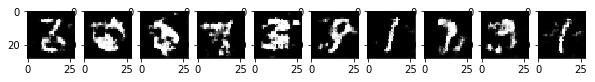

Epochs 1/10: Generator Loss: 0.407. Discriminator Loss: 0.201


Epochs 1/10: Generator Loss: 0.403. Discriminator Loss: 0.203


Epochs 1/10: Generator Loss: 0.356. Discriminator Loss: 0.248


Epochs 1/10: Generator Loss: 0.399. Discriminator Loss: 0.217


Epochs 1/10: Generator Loss: 0.411. Discriminator Loss: 0.238


Epochs 1/10: Generator Loss: 0.463. Discriminator Loss: 0.228


Epochs 1/10: Generator Loss: 0.363. Discriminator Loss: 0.303


Epochs 1/10: Generator Loss: 0.435. Discriminator Loss: 0.232


Epochs 1/10: Generator Loss: 0.379. Discriminator Loss: 0.27


Epochs 1/10: Generator Loss: 0.446. Discriminator Loss: 0.231


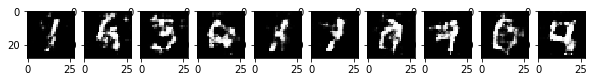

Epochs 1/10: Generator Loss: 0.484. Discriminator Loss: 0.234


Epochs 1/10: Generator Loss: 0.458. Discriminator Loss: 0.238


Epochs 1/10: Generator Loss: 0.444. Discriminator Loss: 0.217


Epochs 1/10: Generator Loss: 0.388. Discriminator Loss: 0.216


Epochs 1/10: Generator Loss: 0.379. Discriminator Loss: 0.221


Epochs 1/10: Generator Loss: 0.431. Discriminator Loss: 0.195


Epochs 1/10: Generator Loss: 0.404. Discriminator Loss: 0.245


Epochs 1/10: Generator Loss: 0.442. Discriminator Loss: 0.22


Epochs 1/10: Generator Loss: 0.443. Discriminator Loss: 0.25


Epochs 1/10: Generator Loss: 0.417. Discriminator Loss: 0.248


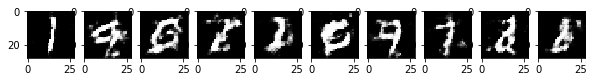

Epochs 1/10: Generator Loss: 0.419. Discriminator Loss: 0.232


Epochs 1/10: Generator Loss: 0.416. Discriminator Loss: 0.212


Epochs 1/10: Generator Loss: 0.446. Discriminator Loss: 0.247


Epochs 1/10: Generator Loss: 0.408. Discriminator Loss: 0.235


Epochs 1/10: Generator Loss: 0.372. Discriminator Loss: 0.208


Epochs 1/10: Generator Loss: 0.389. Discriminator Loss: 0.252


Epochs 1/10: Generator Loss: 0.431. Discriminator Loss: 0.267


Epochs 1/10: Generator Loss: 0.416. Discriminator Loss: 0.3


Epochs 1/10: Generator Loss: 0.441. Discriminator Loss: 0.281


Epochs 1/10: Generator Loss: 0.426. Discriminator Loss: 0.309


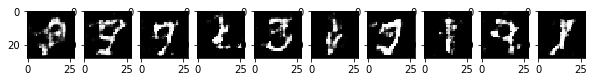

Epochs 1/10: Generator Loss: 0.422. Discriminator Loss: 0.282


Epochs 1/10: Generator Loss: 0.477. Discriminator Loss: 0.252


Epochs 1/10: Generator Loss: 0.383. Discriminator Loss: 0.257


Epochs 1/10: Generator Loss: 0.403. Discriminator Loss: 0.227


Epochs 1/10: Generator Loss: 0.398. Discriminator Loss: 0.231


Epochs 1/10: Generator Loss: 0.396. Discriminator Loss: 0.277


Epochs 1/10: Generator Loss: 0.382. Discriminator Loss: 0.344


Epochs 1/10: Generator Loss: 0.405. Discriminator Loss: 0.274


Epochs 1/10: Generator Loss: 0.422. Discriminator Loss: 0.238


Epochs 1/10: Generator Loss: 0.473. Discriminator Loss: 0.239


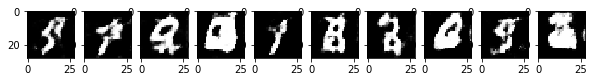

Epochs 1/10: Generator Loss: 0.421. Discriminator Loss: 0.206


Epochs 1/10: Generator Loss: 0.396. Discriminator Loss: 0.258


Epochs 1/10: Generator Loss: 0.454. Discriminator Loss: 0.214


Epochs 1/10: Generator Loss: 0.415. Discriminator Loss: 0.256


Epochs 1/10: Generator Loss: 0.397. Discriminator Loss: 0.288


Epochs 1/10: Generator Loss: 0.382. Discriminator Loss: 0.291


Epochs 1/10: Generator Loss: 0.468. Discriminator Loss: 0.201


Epochs 1/10: Generator Loss: 0.349. Discriminator Loss: 0.276


Epochs 1/10: Generator Loss: 0.464. Discriminator Loss: 0.245


Epochs 1/10: Generator Loss: 0.422. Discriminator Loss: 0.261


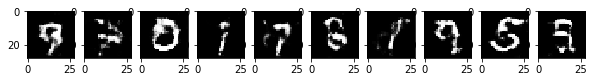

Epochs 1/10: Generator Loss: 0.441. Discriminator Loss: 0.215


Epochs 1/10: Generator Loss: 0.381. Discriminator Loss: 0.233


Epochs 1/10: Generator Loss: 0.398. Discriminator Loss: 0.271


Epochs 1/10: Generator Loss: 0.435. Discriminator Loss: 0.256


Epochs 1/10: Generator Loss: 0.455. Discriminator Loss: 0.249


Epochs 1/10: Generator Loss: 0.393. Discriminator Loss: 0.226


Epochs 1/10: Generator Loss: 0.439. Discriminator Loss: 0.252


Epochs 1/10: Generator Loss: 0.393. Discriminator Loss: 0.278


Epochs 1/10: Generator Loss: 0.419. Discriminator Loss: 0.283


Epochs 1/10: Generator Loss: 0.451. Discriminator Loss: 0.24


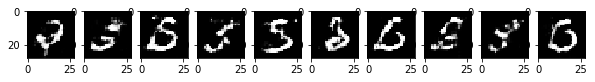

Epochs 1/10: Generator Loss: 0.458. Discriminator Loss: 0.21


Epochs 1/10: Generator Loss: 0.46. Discriminator Loss: 0.264


Epochs 1/10: Generator Loss: 0.42. Discriminator Loss: 0.302


Epochs 1/10: Generator Loss: 0.429. Discriminator Loss: 0.306


Epochs 1/10: Generator Loss: 0.448. Discriminator Loss: 0.305


Epochs 1/10: Generator Loss: 0.457. Discriminator Loss: 0.325


Epochs 1/10: Generator Loss: 0.412. Discriminator Loss: 0.333


Epochs 1/10: Generator Loss: 0.472. Discriminator Loss: 0.274


Epochs 1/10: Generator Loss: 0.38. Discriminator Loss: 0.244


Epochs 1/10: Generator Loss: 0.37. Discriminator Loss: 0.183


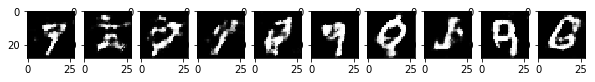

Epochs 1/10: Generator Loss: 0.412. Discriminator Loss: 0.174


Epochs 1/10: Generator Loss: 0.448. Discriminator Loss: 0.208


Epochs 1/10: Generator Loss: 0.455. Discriminator Loss: 0.24


Epochs 1/10: Generator Loss: 0.396. Discriminator Loss: 0.255


Epochs 1/10: Generator Loss: 0.41. Discriminator Loss: 0.263


Epochs 1/10: Generator Loss: 0.419. Discriminator Loss: 0.241


Epochs 1/10: Generator Loss: 0.437. Discriminator Loss: 0.289


Epochs 1/10: Generator Loss: 0.368. Discriminator Loss: 0.329


Epochs 1/10: Generator Loss: 0.487. Discriminator Loss: 0.283


Epochs 1/10: Generator Loss: 0.466. Discriminator Loss: 0.303


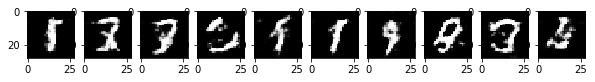

Epochs 1/10: Generator Loss: 0.431. Discriminator Loss: 0.278


Epochs 1/10: Generator Loss: 0.464. Discriminator Loss: 0.272


Epochs 1/10: Generator Loss: 0.435. Discriminator Loss: 0.272


Epochs 1/10: Generator Loss: 0.464. Discriminator Loss: 0.221


Epochs 1/10: Generator Loss: 0.407. Discriminator Loss: 0.286


Epochs 1/10: Generator Loss: 0.429. Discriminator Loss: 0.276


Epochs 1/10: Generator Loss: 0.475. Discriminator Loss: 0.327


Epochs 1/10: Generator Loss: 0.486. Discriminator Loss: 0.298


Epochs 1/10: Generator Loss: 0.451. Discriminator Loss: 0.312


Epochs 1/10: Generator Loss: 0.437. Discriminator Loss: 0.308


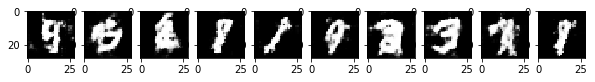

Epochs 1/10: Generator Loss: 0.395. Discriminator Loss: 0.33


Epochs 1/10: Generator Loss: 0.403. Discriminator Loss: 0.275


Epochs 1/10: Generator Loss: 0.4. Discriminator Loss: 0.252


Epochs 1/10: Generator Loss: 0.477. Discriminator Loss: 0.217


Epochs 1/10: Generator Loss: 0.376. Discriminator Loss: 0.294


Epochs 1/10: Generator Loss: 0.44. Discriminator Loss: 0.268


Epochs 1/10: Generator Loss: 0.351. Discriminator Loss: 0.284


Epochs 1/10: Generator Loss: 0.407. Discriminator Loss: 0.213


Epochs 1/10: Generator Loss: 0.425. Discriminator Loss: 0.201


Epochs 1/10: Generator Loss: 0.416. Discriminator Loss: 0.221


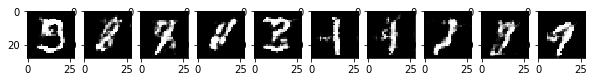

Epochs 1/10: Generator Loss: 0.441. Discriminator Loss: 0.258


Epochs 1/10: Generator Loss: 0.42. Discriminator Loss: 0.269


Epochs 1/10: Generator Loss: 0.409. Discriminator Loss: 0.297


Epochs 1/10: Generator Loss: 0.459. Discriminator Loss: 0.167


Epochs 1/10: Generator Loss: 0.438. Discriminator Loss: 0.243


Epochs 1/10: Generator Loss: 0.452. Discriminator Loss: 0.244


Epochs 1/10: Generator Loss: 0.485. Discriminator Loss: 0.28


Epochs 1/10: Generator Loss: 0.457. Discriminator Loss: 0.224


Epochs 1/10: Generator Loss: 0.434. Discriminator Loss: 0.225


Epochs 1/10: Generator Loss: 0.345. Discriminator Loss: 0.294


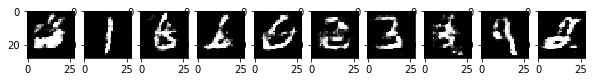

Epochs 1/10: Generator Loss: 0.393. Discriminator Loss: 0.254


Epochs 1/10: Generator Loss: 0.393. Discriminator Loss: 0.252


Epochs 1/10: Generator Loss: 0.41. Discriminator Loss: 0.216


Epochs 1/10: Generator Loss: 0.413. Discriminator Loss: 0.254


Epochs 1/10: Generator Loss: 0.408. Discriminator Loss: 0.214


Epochs 1/10: Generator Loss: 0.404. Discriminator Loss: 0.2


Epochs 1/10: Generator Loss: 0.394. Discriminator Loss: 0.177


Epochs 1/10: Generator Loss: 0.4. Discriminator Loss: 0.219


Epochs 1/10: Generator Loss: 0.423. Discriminator Loss: 0.215


Epochs 1/10: Generator Loss: 0.418. Discriminator Loss: 0.294


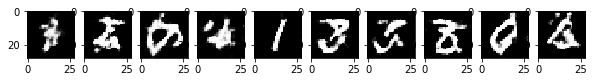

Epochs 1/10: Generator Loss: 0.406. Discriminator Loss: 0.299


Epochs 1/10: Generator Loss: 0.4. Discriminator Loss: 0.276


Epochs 1/10: Generator Loss: 0.439. Discriminator Loss: 0.236


Epochs 1/10: Generator Loss: 0.446. Discriminator Loss: 0.271


Epochs 1/10: Generator Loss: 0.426. Discriminator Loss: 0.306


Epochs 1/10: Generator Loss: 0.439. Discriminator Loss: 0.252


Epochs 1/10: Generator Loss: 0.359. Discriminator Loss: 0.227


Epochs 1/10: Generator Loss: 0.436. Discriminator Loss: 0.155


Epochs 1/10: Generator Loss: 0.4. Discriminator Loss: 0.233


Epochs 1/10: Generator Loss: 0.404. Discriminator Loss: 0.198


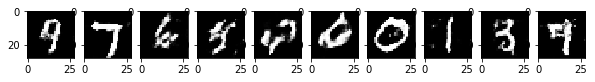

Epochs 1/10: Generator Loss: 0.466. Discriminator Loss: 0.236


Epochs 1/10: Generator Loss: 0.425. Discriminator Loss: 0.205


Epochs 1/10: Generator Loss: 0.431. Discriminator Loss: 0.23


Epochs 1/10: Generator Loss: 0.401. Discriminator Loss: 0.217


Epochs 1/10: Generator Loss: 0.412. Discriminator Loss: 0.248


Epochs 1/10: Generator Loss: 0.378. Discriminator Loss: 0.314


Epochs 1/10: Generator Loss: 0.437. Discriminator Loss: 0.243


Epochs 1/10: Generator Loss: 0.432. Discriminator Loss: 0.217


Epochs 1/10: Generator Loss: 0.437. Discriminator Loss: 0.221


Epochs 1/10: Generator Loss: 0.44. Discriminator Loss: 0.271


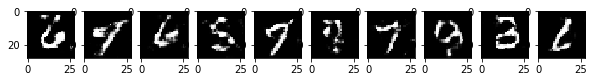

Epochs 1/10: Generator Loss: 0.438. Discriminator Loss: 0.334


Epochs 1/10: Generator Loss: 0.434. Discriminator Loss: 0.299


Epochs 1/10: Generator Loss: 0.419. Discriminator Loss: 0.246


Epochs 1/10: Generator Loss: 0.395. Discriminator Loss: 0.219


Epochs 1/10: Generator Loss: 0.447. Discriminator Loss: 0.24


Epochs 1/10: Generator Loss: 0.408. Discriminator Loss: 0.263


Epochs 1/10: Generator Loss: 0.454. Discriminator Loss: 0.262


Epochs 1/10: Generator Loss: 0.416. Discriminator Loss: 0.306


Epochs 1/10: Generator Loss: 0.471. Discriminator Loss: 0.271


Epochs 1/10: Generator Loss: 0.463. Discriminator Loss: 0.307


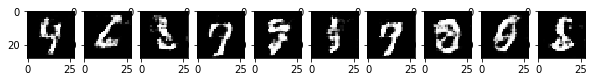

Epochs 1/10: Generator Loss: 0.469. Discriminator Loss: 0.319


Epochs 1/10: Generator Loss: 0.456. Discriminator Loss: 0.306


Epochs 1/10: Generator Loss: 0.438. Discriminator Loss: 0.238


Epochs 1/10: Generator Loss: 0.401. Discriminator Loss: 0.291


Epochs 1/10: Generator Loss: 0.433. Discriminator Loss: 0.266


Epochs 1/10: Generator Loss: 0.409. Discriminator Loss: 0.275


Epochs 1/10: Generator Loss: 0.418. Discriminator Loss: 0.278


Epochs 1/10: Generator Loss: 0.4. Discriminator Loss: 0.23


Epochs 1/10: Generator Loss: 0.441. Discriminator Loss: 0.212


Epochs 1/10: Generator Loss: 0.482. Discriminator Loss: 0.226


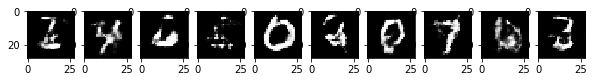

Epochs 1/10: Generator Loss: 0.464. Discriminator Loss: 0.295


Epochs 1/10: Generator Loss: 0.464. Discriminator Loss: 0.298


Epochs 1/10: Generator Loss: 0.422. Discriminator Loss: 0.314


Epochs 1/10: Generator Loss: 0.486. Discriminator Loss: 0.282


Epochs 1/10: Generator Loss: 0.479. Discriminator Loss: 0.269


Epochs 1/10: Generator Loss: 0.426. Discriminator Loss: 0.287


Epochs 1/10: Generator Loss: 0.431. Discriminator Loss: 0.263


Epochs 1/10: Generator Loss: 0.409. Discriminator Loss: 0.225


Epochs 1/10: Generator Loss: 0.451. Discriminator Loss: 0.244


Epochs 1/10: Generator Loss: 0.381. Discriminator Loss: 0.285


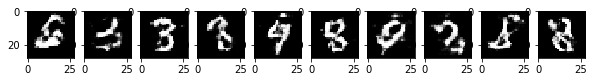

Epochs 1/10: Generator Loss: 0.438. Discriminator Loss: 0.221


Epochs 1/10: Generator Loss: 0.441. Discriminator Loss: 0.211


Epochs 1/10: Generator Loss: 0.428. Discriminator Loss: 0.185


Epochs 1/10: Generator Loss: 0.443. Discriminator Loss: 0.221


Epochs 2/10: Generator Loss: 0.388. Discriminator Loss: 0.39


Epochs 2/10: Generator Loss: 0.403. Discriminator Loss: 0.3


Epochs 2/10: Generator Loss: 0.419. Discriminator Loss: 0.216


Epochs 2/10: Generator Loss: 0.415. Discriminator Loss: 0.219


Epochs 2/10: Generator Loss: 0.433. Discriminator Loss: 0.215


Epochs 2/10: Generator Loss: 0.449. Discriminator Loss: 0.245


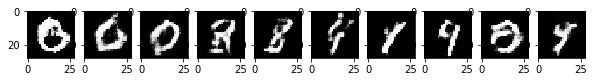

Epochs 2/10: Generator Loss: 0.447. Discriminator Loss: 0.327


Epochs 2/10: Generator Loss: 0.483. Discriminator Loss: 0.299


Epochs 2/10: Generator Loss: 0.446. Discriminator Loss: 0.295


Epochs 2/10: Generator Loss: 0.427. Discriminator Loss: 0.259


Epochs 2/10: Generator Loss: 0.421. Discriminator Loss: 0.241


Epochs 2/10: Generator Loss: 0.429. Discriminator Loss: 0.22


Epochs 2/10: Generator Loss: 0.428. Discriminator Loss: 0.235


Epochs 2/10: Generator Loss: 0.466. Discriminator Loss: 0.216


Epochs 2/10: Generator Loss: 0.404. Discriminator Loss: 0.239


Epochs 2/10: Generator Loss: 0.421. Discriminator Loss: 0.221


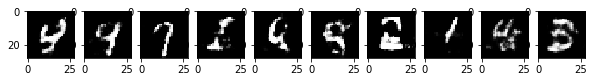

Epochs 2/10: Generator Loss: 0.437. Discriminator Loss: 0.221


Epochs 2/10: Generator Loss: 0.417. Discriminator Loss: 0.24


Epochs 2/10: Generator Loss: 0.428. Discriminator Loss: 0.238


Epochs 2/10: Generator Loss: 0.43. Discriminator Loss: 0.24


Epochs 2/10: Generator Loss: 0.435. Discriminator Loss: 0.221


Epochs 2/10: Generator Loss: 0.421. Discriminator Loss: 0.254


Epochs 2/10: Generator Loss: 0.399. Discriminator Loss: 0.272


Epochs 2/10: Generator Loss: 0.437. Discriminator Loss: 0.226


Epochs 2/10: Generator Loss: 0.423. Discriminator Loss: 0.251


Epochs 2/10: Generator Loss: 0.41. Discriminator Loss: 0.249


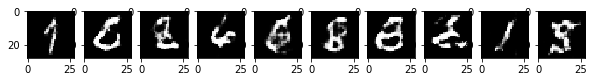

Epochs 2/10: Generator Loss: 0.417. Discriminator Loss: 0.252


Epochs 2/10: Generator Loss: 0.463. Discriminator Loss: 0.212


Epochs 2/10: Generator Loss: 0.466. Discriminator Loss: 0.177


Epochs 2/10: Generator Loss: 0.434. Discriminator Loss: 0.178


Epochs 2/10: Generator Loss: 0.461. Discriminator Loss: 0.263


Epochs 2/10: Generator Loss: 0.469. Discriminator Loss: 0.254


Epochs 2/10: Generator Loss: 0.45. Discriminator Loss: 0.27


Epochs 2/10: Generator Loss: 0.41. Discriminator Loss: 0.205


Epochs 2/10: Generator Loss: 0.446. Discriminator Loss: 0.211


Epochs 2/10: Generator Loss: 0.429. Discriminator Loss: 0.23


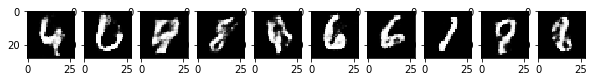

Epochs 2/10: Generator Loss: 0.42. Discriminator Loss: 0.251


Epochs 2/10: Generator Loss: 0.47. Discriminator Loss: 0.248


Epochs 2/10: Generator Loss: 0.407. Discriminator Loss: 0.262


Epochs 2/10: Generator Loss: 0.395. Discriminator Loss: 0.262


Epochs 2/10: Generator Loss: 0.434. Discriminator Loss: 0.229


Epochs 2/10: Generator Loss: 0.421. Discriminator Loss: 0.199


Epochs 2/10: Generator Loss: 0.398. Discriminator Loss: 0.255


Epochs 2/10: Generator Loss: 0.433. Discriminator Loss: 0.269


Epochs 2/10: Generator Loss: 0.423. Discriminator Loss: 0.241


Epochs 2/10: Generator Loss: 0.484. Discriminator Loss: 0.191


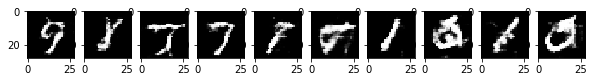

Epochs 2/10: Generator Loss: 0.466. Discriminator Loss: 0.231


Epochs 2/10: Generator Loss: 0.474. Discriminator Loss: 0.257


Epochs 2/10: Generator Loss: 0.457. Discriminator Loss: 0.247


Epochs 2/10: Generator Loss: 0.407. Discriminator Loss: 0.269


Epochs 2/10: Generator Loss: 0.44. Discriminator Loss: 0.244


Epochs 2/10: Generator Loss: 0.408. Discriminator Loss: 0.265


Epochs 2/10: Generator Loss: 0.452. Discriminator Loss: 0.211


Epochs 2/10: Generator Loss: 0.435. Discriminator Loss: 0.217


Epochs 2/10: Generator Loss: 0.391. Discriminator Loss: 0.251


Epochs 2/10: Generator Loss: 0.44. Discriminator Loss: 0.233


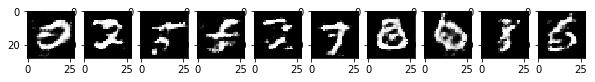

Epochs 2/10: Generator Loss: 0.454. Discriminator Loss: 0.243


Epochs 2/10: Generator Loss: 0.439. Discriminator Loss: 0.2


Epochs 2/10: Generator Loss: 0.41. Discriminator Loss: 0.219


Epochs 2/10: Generator Loss: 0.438. Discriminator Loss: 0.197


Epochs 2/10: Generator Loss: 0.451. Discriminator Loss: 0.251


Epochs 2/10: Generator Loss: 0.442. Discriminator Loss: 0.24


Epochs 2/10: Generator Loss: 0.438. Discriminator Loss: 0.276


Epochs 2/10: Generator Loss: 0.461. Discriminator Loss: 0.213


Epochs 2/10: Generator Loss: 0.448. Discriminator Loss: 0.162


Epochs 2/10: Generator Loss: 0.424. Discriminator Loss: 0.196


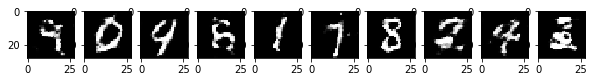

Epochs 2/10: Generator Loss: 0.4. Discriminator Loss: 0.218


Epochs 2/10: Generator Loss: 0.439. Discriminator Loss: 0.274


Epochs 2/10: Generator Loss: 0.45. Discriminator Loss: 0.248


Epochs 2/10: Generator Loss: 0.436. Discriminator Loss: 0.28


Epochs 2/10: Generator Loss: 0.486. Discriminator Loss: 0.208


Epochs 2/10: Generator Loss: 0.43. Discriminator Loss: 0.24


Epochs 2/10: Generator Loss: 0.425. Discriminator Loss: 0.265


Epochs 2/10: Generator Loss: 0.443. Discriminator Loss: 0.247


Epochs 2/10: Generator Loss: 0.46. Discriminator Loss: 0.246


Epochs 2/10: Generator Loss: 0.434. Discriminator Loss: 0.26


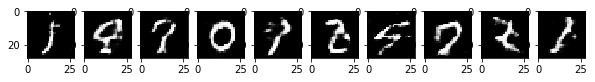

Epochs 2/10: Generator Loss: 0.421. Discriminator Loss: 0.332


Epochs 2/10: Generator Loss: 0.479. Discriminator Loss: 0.307


Epochs 2/10: Generator Loss: 0.454. Discriminator Loss: 0.313


Epochs 2/10: Generator Loss: 0.462. Discriminator Loss: 0.305


Epochs 2/10: Generator Loss: 0.451. Discriminator Loss: 0.257


Epochs 2/10: Generator Loss: 0.432. Discriminator Loss: 0.263


Epochs 2/10: Generator Loss: 0.413. Discriminator Loss: 0.215


Epochs 2/10: Generator Loss: 0.442. Discriminator Loss: 0.194


Epochs 2/10: Generator Loss: 0.414. Discriminator Loss: 0.228


Epochs 2/10: Generator Loss: 0.466. Discriminator Loss: 0.239


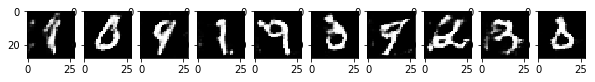

Epochs 2/10: Generator Loss: 0.456. Discriminator Loss: 0.275


Epochs 2/10: Generator Loss: 0.446. Discriminator Loss: 0.221


Epochs 2/10: Generator Loss: 0.436. Discriminator Loss: 0.266


Epochs 2/10: Generator Loss: 0.432. Discriminator Loss: 0.296


Epochs 2/10: Generator Loss: 0.43. Discriminator Loss: 0.319


Epochs 2/10: Generator Loss: 0.461. Discriminator Loss: 0.262


Epochs 2/10: Generator Loss: 0.42. Discriminator Loss: 0.282


Epochs 2/10: Generator Loss: 0.462. Discriminator Loss: 0.255


Epochs 2/10: Generator Loss: 0.442. Discriminator Loss: 0.276


Epochs 2/10: Generator Loss: 0.442. Discriminator Loss: 0.28


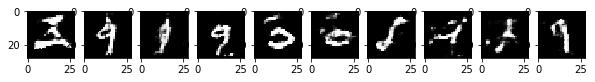

Epochs 2/10: Generator Loss: 0.37. Discriminator Loss: 0.293


Epochs 2/10: Generator Loss: 0.416. Discriminator Loss: 0.238


Epochs 2/10: Generator Loss: 0.46. Discriminator Loss: 0.254


Epochs 2/10: Generator Loss: 0.45. Discriminator Loss: 0.282


Epochs 2/10: Generator Loss: 0.481. Discriminator Loss: 0.31


Epochs 2/10: Generator Loss: 0.478. Discriminator Loss: 0.307


Epochs 2/10: Generator Loss: 0.474. Discriminator Loss: 0.328


Epochs 2/10: Generator Loss: 0.459. Discriminator Loss: 0.295


Epochs 2/10: Generator Loss: 0.426. Discriminator Loss: 0.289


Epochs 2/10: Generator Loss: 0.391. Discriminator Loss: 0.241


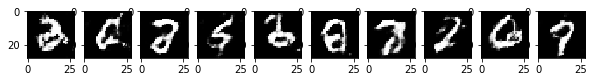

Epochs 2/10: Generator Loss: 0.464. Discriminator Loss: 0.219


Epochs 2/10: Generator Loss: 0.429. Discriminator Loss: 0.265


Epochs 2/10: Generator Loss: 0.471. Discriminator Loss: 0.218


Epochs 2/10: Generator Loss: 0.428. Discriminator Loss: 0.21


Epochs 2/10: Generator Loss: 0.456. Discriminator Loss: 0.231


Epochs 2/10: Generator Loss: 0.413. Discriminator Loss: 0.22


Epochs 2/10: Generator Loss: 0.418. Discriminator Loss: 0.22


Epochs 2/10: Generator Loss: 0.425. Discriminator Loss: 0.247


Epochs 2/10: Generator Loss: 0.467. Discriminator Loss: 0.27


Epochs 2/10: Generator Loss: 0.459. Discriminator Loss: 0.264


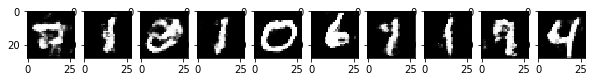

Epochs 2/10: Generator Loss: 0.421. Discriminator Loss: 0.276


Epochs 2/10: Generator Loss: 0.43. Discriminator Loss: 0.233


Epochs 2/10: Generator Loss: 0.44. Discriminator Loss: 0.269


Epochs 2/10: Generator Loss: 0.432. Discriminator Loss: 0.217


Epochs 2/10: Generator Loss: 0.442. Discriminator Loss: 0.208


Epochs 2/10: Generator Loss: 0.401. Discriminator Loss: 0.216


Epochs 2/10: Generator Loss: 0.489. Discriminator Loss: 0.193


Epochs 2/10: Generator Loss: 0.45. Discriminator Loss: 0.234


Epochs 2/10: Generator Loss: 0.412. Discriminator Loss: 0.231


Epochs 2/10: Generator Loss: 0.454. Discriminator Loss: 0.179


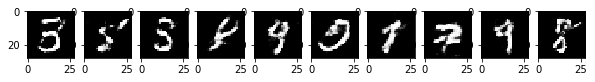

Epochs 2/10: Generator Loss: 0.453. Discriminator Loss: 0.211


Epochs 2/10: Generator Loss: 0.441. Discriminator Loss: 0.251


Epochs 2/10: Generator Loss: 0.422. Discriminator Loss: 0.233


Epochs 2/10: Generator Loss: 0.426. Discriminator Loss: 0.19


Epochs 2/10: Generator Loss: 0.469. Discriminator Loss: 0.179


Epochs 2/10: Generator Loss: 0.39. Discriminator Loss: 0.199


Epochs 2/10: Generator Loss: 0.461. Discriminator Loss: 0.227


Epochs 2/10: Generator Loss: 0.432. Discriminator Loss: 0.27


Epochs 2/10: Generator Loss: 0.451. Discriminator Loss: 0.221


Epochs 2/10: Generator Loss: 0.468. Discriminator Loss: 0.261


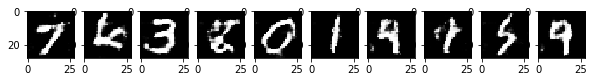

Epochs 2/10: Generator Loss: 0.442. Discriminator Loss: 0.257


Epochs 2/10: Generator Loss: 0.444. Discriminator Loss: 0.309


Epochs 2/10: Generator Loss: 0.44. Discriminator Loss: 0.314


Epochs 2/10: Generator Loss: 0.459. Discriminator Loss: 0.272


Epochs 2/10: Generator Loss: 0.435. Discriminator Loss: 0.249


Epochs 2/10: Generator Loss: 0.436. Discriminator Loss: 0.251


Epochs 2/10: Generator Loss: 0.431. Discriminator Loss: 0.198


Epochs 2/10: Generator Loss: 0.419. Discriminator Loss: 0.254


Epochs 2/10: Generator Loss: 0.438. Discriminator Loss: 0.232


Epochs 2/10: Generator Loss: 0.428. Discriminator Loss: 0.214


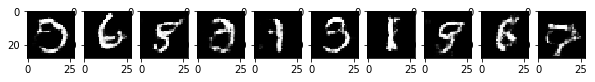

Epochs 2/10: Generator Loss: 0.399. Discriminator Loss: 0.225


Epochs 2/10: Generator Loss: 0.45. Discriminator Loss: 0.213


Epochs 2/10: Generator Loss: 0.418. Discriminator Loss: 0.264


Epochs 2/10: Generator Loss: 0.443. Discriminator Loss: 0.266


Epochs 2/10: Generator Loss: 0.387. Discriminator Loss: 0.257


Epochs 2/10: Generator Loss: 0.414. Discriminator Loss: 0.207


Epochs 2/10: Generator Loss: 0.422. Discriminator Loss: 0.231


Epochs 2/10: Generator Loss: 0.442. Discriminator Loss: 0.226


Epochs 2/10: Generator Loss: 0.471. Discriminator Loss: 0.26


Epochs 2/10: Generator Loss: 0.412. Discriminator Loss: 0.272


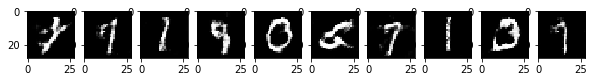

Epochs 2/10: Generator Loss: 0.442. Discriminator Loss: 0.221


Epochs 2/10: Generator Loss: 0.449. Discriminator Loss: 0.194


Epochs 2/10: Generator Loss: 0.468. Discriminator Loss: 0.207


Epochs 2/10: Generator Loss: 0.447. Discriminator Loss: 0.266


Epochs 2/10: Generator Loss: 0.464. Discriminator Loss: 0.252


Epochs 2/10: Generator Loss: 0.457. Discriminator Loss: 0.242


Epochs 2/10: Generator Loss: 0.46. Discriminator Loss: 0.319


Epochs 2/10: Generator Loss: 0.455. Discriminator Loss: 0.338


Epochs 2/10: Generator Loss: 0.45. Discriminator Loss: 0.311


Epochs 2/10: Generator Loss: 0.432. Discriminator Loss: 0.258


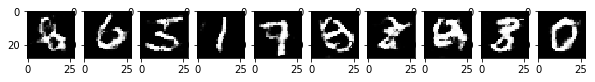

Epochs 2/10: Generator Loss: 0.46. Discriminator Loss: 0.291


Epochs 2/10: Generator Loss: 0.449. Discriminator Loss: 0.277


Epochs 2/10: Generator Loss: 0.441. Discriminator Loss: 0.276


Epochs 2/10: Generator Loss: 0.472. Discriminator Loss: 0.258


Epochs 2/10: Generator Loss: 0.447. Discriminator Loss: 0.254


Epochs 2/10: Generator Loss: 0.459. Discriminator Loss: 0.231


Epochs 2/10: Generator Loss: 0.42. Discriminator Loss: 0.261


Epochs 2/10: Generator Loss: 0.443. Discriminator Loss: 0.282


Epochs 2/10: Generator Loss: 0.455. Discriminator Loss: 0.306


Epochs 2/10: Generator Loss: 0.472. Discriminator Loss: 0.317


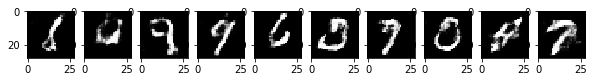

Epochs 2/10: Generator Loss: 0.421. Discriminator Loss: 0.319


Epochs 2/10: Generator Loss: 0.471. Discriminator Loss: 0.313


Epochs 2/10: Generator Loss: 0.441. Discriminator Loss: 0.299


Epochs 2/10: Generator Loss: 0.426. Discriminator Loss: 0.251


Epochs 2/10: Generator Loss: 0.434. Discriminator Loss: 0.267


Epochs 2/10: Generator Loss: 0.447. Discriminator Loss: 0.262


Epochs 2/10: Generator Loss: 0.465. Discriminator Loss: 0.282


Epochs 2/10: Generator Loss: 0.467. Discriminator Loss: 0.297


Epochs 2/10: Generator Loss: 0.447. Discriminator Loss: 0.249


Epochs 2/10: Generator Loss: 0.479. Discriminator Loss: 0.238


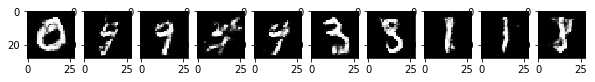

Epochs 2/10: Generator Loss: 0.435. Discriminator Loss: 0.254


Epochs 2/10: Generator Loss: 0.481. Discriminator Loss: 0.257


Epochs 3/10: Generator Loss: 0.466. Discriminator Loss: 0.284


Epochs 3/10: Generator Loss: 0.438. Discriminator Loss: 0.227


Epochs 3/10: Generator Loss: 0.49. Discriminator Loss: 0.19


Epochs 3/10: Generator Loss: 0.437. Discriminator Loss: 0.282


Epochs 3/10: Generator Loss: 0.459. Discriminator Loss: 0.28


Epochs 3/10: Generator Loss: 0.428. Discriminator Loss: 0.308


Epochs 3/10: Generator Loss: 0.429. Discriminator Loss: 0.303


Epochs 3/10: Generator Loss: 0.426. Discriminator Loss: 0.315


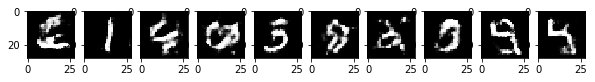

Epochs 3/10: Generator Loss: 0.472. Discriminator Loss: 0.231


Epochs 3/10: Generator Loss: 0.433. Discriminator Loss: 0.205


Epochs 3/10: Generator Loss: 0.427. Discriminator Loss: 0.253


Epochs 3/10: Generator Loss: 0.448. Discriminator Loss: 0.247


Epochs 3/10: Generator Loss: 0.47. Discriminator Loss: 0.274


Epochs 3/10: Generator Loss: 0.42. Discriminator Loss: 0.244


Epochs 3/10: Generator Loss: 0.451. Discriminator Loss: 0.203


Epochs 3/10: Generator Loss: 0.407. Discriminator Loss: 0.201


Epochs 3/10: Generator Loss: 0.465. Discriminator Loss: 0.253


Epochs 3/10: Generator Loss: 0.447. Discriminator Loss: 0.274


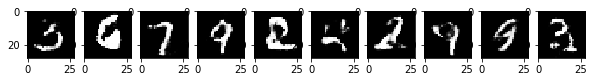

Epochs 3/10: Generator Loss: 0.416. Discriminator Loss: 0.234


Epochs 3/10: Generator Loss: 0.431. Discriminator Loss: 0.217


Epochs 3/10: Generator Loss: 0.437. Discriminator Loss: 0.248


Epochs 3/10: Generator Loss: 0.428. Discriminator Loss: 0.248


Epochs 3/10: Generator Loss: 0.445. Discriminator Loss: 0.233


Epochs 3/10: Generator Loss: 0.417. Discriminator Loss: 0.223


Epochs 3/10: Generator Loss: 0.434. Discriminator Loss: 0.278


Epochs 3/10: Generator Loss: 0.455. Discriminator Loss: 0.277


Epochs 3/10: Generator Loss: 0.443. Discriminator Loss: 0.259


Epochs 3/10: Generator Loss: 0.443. Discriminator Loss: 0.208


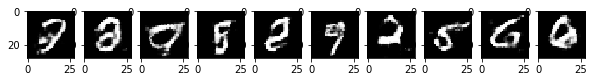

Epochs 3/10: Generator Loss: 0.45. Discriminator Loss: 0.193


Epochs 3/10: Generator Loss: 0.405. Discriminator Loss: 0.221


Epochs 3/10: Generator Loss: 0.453. Discriminator Loss: 0.23


Epochs 3/10: Generator Loss: 0.464. Discriminator Loss: 0.269


Epochs 3/10: Generator Loss: 0.449. Discriminator Loss: 0.282


Epochs 3/10: Generator Loss: 0.46. Discriminator Loss: 0.242


Epochs 3/10: Generator Loss: 0.442. Discriminator Loss: 0.232


Epochs 3/10: Generator Loss: 0.445. Discriminator Loss: 0.246


Epochs 3/10: Generator Loss: 0.459. Discriminator Loss: 0.243


Epochs 3/10: Generator Loss: 0.431. Discriminator Loss: 0.275


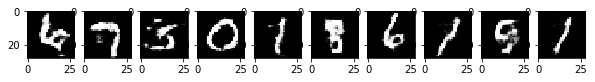

Epochs 3/10: Generator Loss: 0.425. Discriminator Loss: 0.255


Epochs 3/10: Generator Loss: 0.448. Discriminator Loss: 0.215


Epochs 3/10: Generator Loss: 0.388. Discriminator Loss: 0.232


Epochs 3/10: Generator Loss: 0.433. Discriminator Loss: 0.223


Epochs 3/10: Generator Loss: 0.438. Discriminator Loss: 0.25


Epochs 3/10: Generator Loss: 0.476. Discriminator Loss: 0.264


Epochs 3/10: Generator Loss: 0.474. Discriminator Loss: 0.235


Epochs 3/10: Generator Loss: 0.412. Discriminator Loss: 0.244


Epochs 3/10: Generator Loss: 0.412. Discriminator Loss: 0.245


Epochs 3/10: Generator Loss: 0.426. Discriminator Loss: 0.255


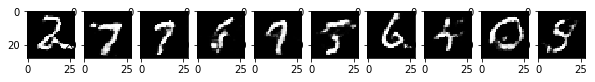

Epochs 3/10: Generator Loss: 0.494. Discriminator Loss: 0.266


Epochs 3/10: Generator Loss: 0.454. Discriminator Loss: 0.258


Epochs 3/10: Generator Loss: 0.406. Discriminator Loss: 0.271


Epochs 3/10: Generator Loss: 0.454. Discriminator Loss: 0.198


Epochs 3/10: Generator Loss: 0.464. Discriminator Loss: 0.209


Epochs 3/10: Generator Loss: 0.46. Discriminator Loss: 0.193


Epochs 3/10: Generator Loss: 0.446. Discriminator Loss: 0.201


Epochs 3/10: Generator Loss: 0.449. Discriminator Loss: 0.237


Epochs 3/10: Generator Loss: 0.425. Discriminator Loss: 0.244


Epochs 3/10: Generator Loss: 0.446. Discriminator Loss: 0.23


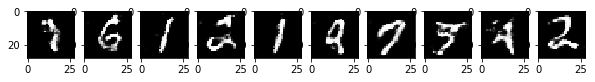

Epochs 3/10: Generator Loss: 0.416. Discriminator Loss: 0.254


Epochs 3/10: Generator Loss: 0.457. Discriminator Loss: 0.239


Epochs 3/10: Generator Loss: 0.464. Discriminator Loss: 0.254


Epochs 3/10: Generator Loss: 0.463. Discriminator Loss: 0.266


Epochs 3/10: Generator Loss: 0.486. Discriminator Loss: 0.207


Epochs 3/10: Generator Loss: 0.423. Discriminator Loss: 0.221


Epochs 3/10: Generator Loss: 0.447. Discriminator Loss: 0.194


Epochs 3/10: Generator Loss: 0.451. Discriminator Loss: 0.18


Epochs 3/10: Generator Loss: 0.427. Discriminator Loss: 0.234


Epochs 3/10: Generator Loss: 0.398. Discriminator Loss: 0.24


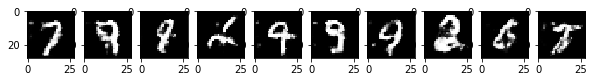

Epochs 3/10: Generator Loss: 0.413. Discriminator Loss: 0.201


Epochs 3/10: Generator Loss: 0.381. Discriminator Loss: 0.214


Epochs 3/10: Generator Loss: 0.455. Discriminator Loss: 0.237


Epochs 3/10: Generator Loss: 0.426. Discriminator Loss: 0.256


Epochs 3/10: Generator Loss: 0.457. Discriminator Loss: 0.262


Epochs 3/10: Generator Loss: 0.457. Discriminator Loss: 0.245


Epochs 3/10: Generator Loss: 0.476. Discriminator Loss: 0.246


Epochs 3/10: Generator Loss: 0.436. Discriminator Loss: 0.295


Epochs 3/10: Generator Loss: 0.429. Discriminator Loss: 0.276


Epochs 3/10: Generator Loss: 0.43. Discriminator Loss: 0.268


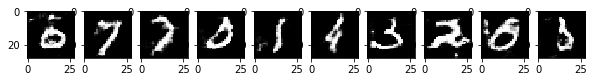

Epochs 3/10: Generator Loss: 0.45. Discriminator Loss: 0.294


Epochs 3/10: Generator Loss: 0.423. Discriminator Loss: 0.238


Epochs 3/10: Generator Loss: 0.4. Discriminator Loss: 0.229


Epochs 3/10: Generator Loss: 0.457. Discriminator Loss: 0.21


Epochs 3/10: Generator Loss: 0.449. Discriminator Loss: 0.181


Epochs 3/10: Generator Loss: 0.449. Discriminator Loss: 0.142


Epochs 3/10: Generator Loss: 0.438. Discriminator Loss: 0.213


Epochs 3/10: Generator Loss: 0.451. Discriminator Loss: 0.242


Epochs 3/10: Generator Loss: 0.459. Discriminator Loss: 0.202


Epochs 3/10: Generator Loss: 0.42. Discriminator Loss: 0.229


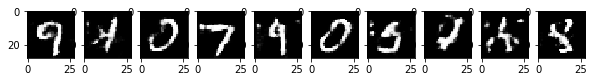

Epochs 3/10: Generator Loss: 0.433. Discriminator Loss: 0.197


Epochs 3/10: Generator Loss: 0.418. Discriminator Loss: 0.248


Epochs 3/10: Generator Loss: 0.412. Discriminator Loss: 0.256


Epochs 3/10: Generator Loss: 0.487. Discriminator Loss: 0.252


Epochs 3/10: Generator Loss: 0.45. Discriminator Loss: 0.245


Epochs 3/10: Generator Loss: 0.45. Discriminator Loss: 0.267


Epochs 3/10: Generator Loss: 0.433. Discriminator Loss: 0.29


Epochs 3/10: Generator Loss: 0.446. Discriminator Loss: 0.253


Epochs 3/10: Generator Loss: 0.454. Discriminator Loss: 0.216


Epochs 3/10: Generator Loss: 0.442. Discriminator Loss: 0.215


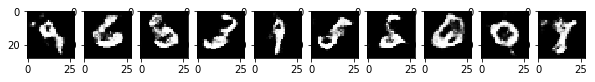

Epochs 3/10: Generator Loss: 0.47. Discriminator Loss: 0.27


Epochs 3/10: Generator Loss: 0.443. Discriminator Loss: 0.324


Epochs 3/10: Generator Loss: 0.473. Discriminator Loss: 0.28


Epochs 3/10: Generator Loss: 0.443. Discriminator Loss: 0.243


Epochs 3/10: Generator Loss: 0.442. Discriminator Loss: 0.247


Epochs 3/10: Generator Loss: 0.434. Discriminator Loss: 0.287


Epochs 3/10: Generator Loss: 0.416. Discriminator Loss: 0.269


Epochs 3/10: Generator Loss: 0.434. Discriminator Loss: 0.24


Epochs 3/10: Generator Loss: 0.44. Discriminator Loss: 0.204


Epochs 3/10: Generator Loss: 0.439. Discriminator Loss: 0.249


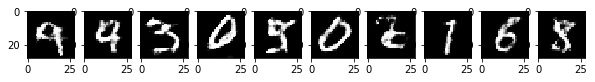

Epochs 3/10: Generator Loss: 0.438. Discriminator Loss: 0.245


Epochs 3/10: Generator Loss: 0.444. Discriminator Loss: 0.217


Epochs 3/10: Generator Loss: 0.407. Discriminator Loss: 0.218


Epochs 3/10: Generator Loss: 0.436. Discriminator Loss: 0.192


Epochs 3/10: Generator Loss: 0.411. Discriminator Loss: 0.226


Epochs 3/10: Generator Loss: 0.47. Discriminator Loss: 0.258


Epochs 3/10: Generator Loss: 0.445. Discriminator Loss: 0.273


Epochs 3/10: Generator Loss: 0.497. Discriminator Loss: 0.272


Epochs 3/10: Generator Loss: 0.453. Discriminator Loss: 0.211


Epochs 3/10: Generator Loss: 0.455. Discriminator Loss: 0.257


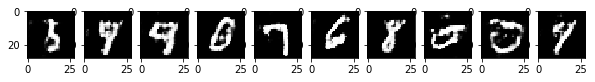

Epochs 3/10: Generator Loss: 0.456. Discriminator Loss: 0.288


Epochs 3/10: Generator Loss: 0.42. Discriminator Loss: 0.311


Epochs 3/10: Generator Loss: 0.431. Discriminator Loss: 0.257


Epochs 3/10: Generator Loss: 0.478. Discriminator Loss: 0.207


Epochs 3/10: Generator Loss: 0.455. Discriminator Loss: 0.233


Epochs 3/10: Generator Loss: 0.444. Discriminator Loss: 0.22


Epochs 3/10: Generator Loss: 0.476. Discriminator Loss: 0.22


Epochs 3/10: Generator Loss: 0.458. Discriminator Loss: 0.212


Epochs 3/10: Generator Loss: 0.482. Discriminator Loss: 0.224


Epochs 3/10: Generator Loss: 0.467. Discriminator Loss: 0.196


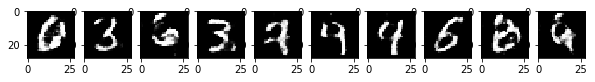

Epochs 3/10: Generator Loss: 0.432. Discriminator Loss: 0.192


Epochs 3/10: Generator Loss: 0.395. Discriminator Loss: 0.181


Epochs 3/10: Generator Loss: 0.417. Discriminator Loss: 0.191


Epochs 3/10: Generator Loss: 0.408. Discriminator Loss: 0.237


Epochs 3/10: Generator Loss: 0.444. Discriminator Loss: 0.278


Epochs 3/10: Generator Loss: 0.486. Discriminator Loss: 0.267


Epochs 3/10: Generator Loss: 0.457. Discriminator Loss: 0.248


Epochs 3/10: Generator Loss: 0.455. Discriminator Loss: 0.251


Epochs 3/10: Generator Loss: 0.457. Discriminator Loss: 0.253


Epochs 3/10: Generator Loss: 0.441. Discriminator Loss: 0.278


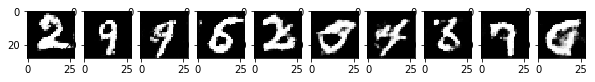

Epochs 3/10: Generator Loss: 0.426. Discriminator Loss: 0.244


Epochs 3/10: Generator Loss: 0.463. Discriminator Loss: 0.192


Epochs 3/10: Generator Loss: 0.436. Discriminator Loss: 0.211


Epochs 3/10: Generator Loss: 0.412. Discriminator Loss: 0.244


Epochs 3/10: Generator Loss: 0.464. Discriminator Loss: 0.164


Epochs 3/10: Generator Loss: 0.472. Discriminator Loss: 0.192


Epochs 3/10: Generator Loss: 0.442. Discriminator Loss: 0.195


Epochs 3/10: Generator Loss: 0.439. Discriminator Loss: 0.26


Epochs 3/10: Generator Loss: 0.366. Discriminator Loss: 0.255


Epochs 3/10: Generator Loss: 0.482. Discriminator Loss: 0.209


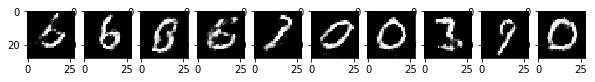

Epochs 3/10: Generator Loss: 0.439. Discriminator Loss: 0.273


Epochs 3/10: Generator Loss: 0.47. Discriminator Loss: 0.302


Epochs 3/10: Generator Loss: 0.456. Discriminator Loss: 0.265


Epochs 3/10: Generator Loss: 0.39. Discriminator Loss: 0.269


Epochs 3/10: Generator Loss: 0.421. Discriminator Loss: 0.259


Epochs 3/10: Generator Loss: 0.479. Discriminator Loss: 0.281


Epochs 3/10: Generator Loss: 0.455. Discriminator Loss: 0.28


Epochs 3/10: Generator Loss: 0.474. Discriminator Loss: 0.238


Epochs 3/10: Generator Loss: 0.383. Discriminator Loss: 0.274


Epochs 3/10: Generator Loss: 0.491. Discriminator Loss: 0.232


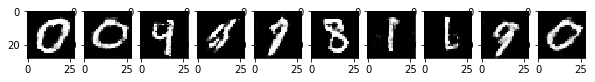

Epochs 3/10: Generator Loss: 0.488. Discriminator Loss: 0.251


Epochs 3/10: Generator Loss: 0.463. Discriminator Loss: 0.281


Epochs 3/10: Generator Loss: 0.417. Discriminator Loss: 0.292


Epochs 3/10: Generator Loss: 0.481. Discriminator Loss: 0.313


Epochs 3/10: Generator Loss: 0.48. Discriminator Loss: 0.3


Epochs 3/10: Generator Loss: 0.464. Discriminator Loss: 0.342


Epochs 3/10: Generator Loss: 0.484. Discriminator Loss: 0.299


Epochs 3/10: Generator Loss: 0.466. Discriminator Loss: 0.249


Epochs 3/10: Generator Loss: 0.463. Discriminator Loss: 0.239


Epochs 3/10: Generator Loss: 0.455. Discriminator Loss: 0.275


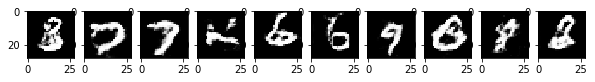

Epochs 3/10: Generator Loss: 0.49. Discriminator Loss: 0.22


Epochs 3/10: Generator Loss: 0.466. Discriminator Loss: 0.259


Epochs 3/10: Generator Loss: 0.465. Discriminator Loss: 0.207


Epochs 3/10: Generator Loss: 0.441. Discriminator Loss: 0.213


Epochs 3/10: Generator Loss: 0.451. Discriminator Loss: 0.259


Epochs 3/10: Generator Loss: 0.446. Discriminator Loss: 0.32


Epochs 3/10: Generator Loss: 0.451. Discriminator Loss: 0.335


Epochs 3/10: Generator Loss: 0.458. Discriminator Loss: 0.308


Epochs 3/10: Generator Loss: 0.459. Discriminator Loss: 0.331


Epochs 3/10: Generator Loss: 0.467. Discriminator Loss: 0.309


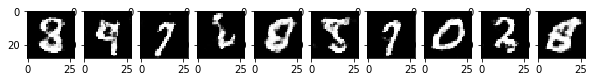

Epochs 3/10: Generator Loss: 0.453. Discriminator Loss: 0.26


Epochs 3/10: Generator Loss: 0.463. Discriminator Loss: 0.271


Epochs 3/10: Generator Loss: 0.431. Discriminator Loss: 0.246


Epochs 3/10: Generator Loss: 0.455. Discriminator Loss: 0.291


Epochs 3/10: Generator Loss: 0.396. Discriminator Loss: 0.313


Epochs 3/10: Generator Loss: 0.45. Discriminator Loss: 0.262


Epochs 3/10: Generator Loss: 0.451. Discriminator Loss: 0.243


Epochs 3/10: Generator Loss: 0.452. Discriminator Loss: 0.246


Epochs 3/10: Generator Loss: 0.468. Discriminator Loss: 0.27


Epochs 4/10: Generator Loss: 0.342. Discriminator Loss: 0.479


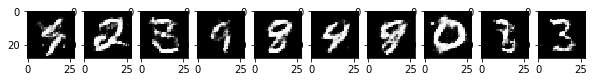

Epochs 4/10: Generator Loss: 0.436. Discriminator Loss: 0.292


Epochs 4/10: Generator Loss: 0.43. Discriminator Loss: 0.246


Epochs 4/10: Generator Loss: 0.444. Discriminator Loss: 0.239


Epochs 4/10: Generator Loss: 0.446. Discriminator Loss: 0.267


Epochs 4/10: Generator Loss: 0.453. Discriminator Loss: 0.278


Epochs 4/10: Generator Loss: 0.471. Discriminator Loss: 0.298


Epochs 4/10: Generator Loss: 0.44. Discriminator Loss: 0.289


Epochs 4/10: Generator Loss: 0.468. Discriminator Loss: 0.255


Epochs 4/10: Generator Loss: 0.454. Discriminator Loss: 0.253


Epochs 4/10: Generator Loss: 0.457. Discriminator Loss: 0.199


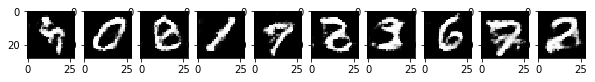

Epochs 4/10: Generator Loss: 0.453. Discriminator Loss: 0.267


Epochs 4/10: Generator Loss: 0.456. Discriminator Loss: 0.259


Epochs 4/10: Generator Loss: 0.49. Discriminator Loss: 0.22


Epochs 4/10: Generator Loss: 0.436. Discriminator Loss: 0.204


Epochs 4/10: Generator Loss: 0.441. Discriminator Loss: 0.244


Epochs 4/10: Generator Loss: 0.46. Discriminator Loss: 0.22


Epochs 4/10: Generator Loss: 0.478. Discriminator Loss: 0.247


Epochs 4/10: Generator Loss: 0.435. Discriminator Loss: 0.224


Epochs 4/10: Generator Loss: 0.458. Discriminator Loss: 0.232


Epochs 4/10: Generator Loss: 0.446. Discriminator Loss: 0.217


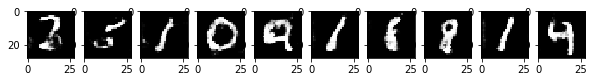

Epochs 4/10: Generator Loss: 0.448. Discriminator Loss: 0.231


Epochs 4/10: Generator Loss: 0.44. Discriminator Loss: 0.231


Epochs 4/10: Generator Loss: 0.419. Discriminator Loss: 0.213


Epochs 4/10: Generator Loss: 0.47. Discriminator Loss: 0.24


Epochs 4/10: Generator Loss: 0.413. Discriminator Loss: 0.231


Epochs 4/10: Generator Loss: 0.467. Discriminator Loss: 0.203


Epochs 4/10: Generator Loss: 0.444. Discriminator Loss: 0.209


Epochs 4/10: Generator Loss: 0.466. Discriminator Loss: 0.195


Epochs 4/10: Generator Loss: 0.472. Discriminator Loss: 0.146


Epochs 4/10: Generator Loss: 0.458. Discriminator Loss: 0.233


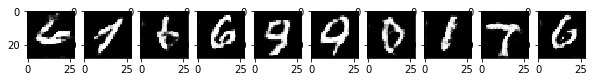

Epochs 4/10: Generator Loss: 0.445. Discriminator Loss: 0.259


Epochs 4/10: Generator Loss: 0.469. Discriminator Loss: 0.238


Epochs 4/10: Generator Loss: 0.459. Discriminator Loss: 0.197


Epochs 4/10: Generator Loss: 0.45. Discriminator Loss: 0.237


Epochs 4/10: Generator Loss: 0.411. Discriminator Loss: 0.259


Epochs 4/10: Generator Loss: 0.447. Discriminator Loss: 0.236


Epochs 4/10: Generator Loss: 0.48. Discriminator Loss: 0.224


Epochs 4/10: Generator Loss: 0.444. Discriminator Loss: 0.247


Epochs 4/10: Generator Loss: 0.476. Discriminator Loss: 0.291


Epochs 4/10: Generator Loss: 0.481. Discriminator Loss: 0.22


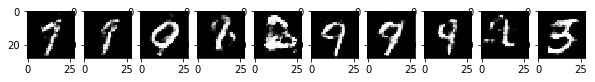

Epochs 4/10: Generator Loss: 0.42. Discriminator Loss: 0.191


Epochs 4/10: Generator Loss: 0.457. Discriminator Loss: 0.245


Epochs 4/10: Generator Loss: 0.474. Discriminator Loss: 0.255


Epochs 4/10: Generator Loss: 0.456. Discriminator Loss: 0.242


Epochs 4/10: Generator Loss: 0.435. Discriminator Loss: 0.236


Epochs 4/10: Generator Loss: 0.451. Discriminator Loss: 0.221


Epochs 4/10: Generator Loss: 0.462. Discriminator Loss: 0.208


Epochs 4/10: Generator Loss: 0.45. Discriminator Loss: 0.225


Epochs 4/10: Generator Loss: 0.451. Discriminator Loss: 0.251


Epochs 4/10: Generator Loss: 0.451. Discriminator Loss: 0.211


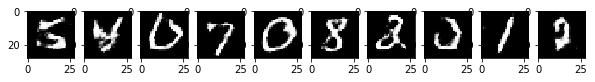

Epochs 4/10: Generator Loss: 0.465. Discriminator Loss: 0.214


Epochs 4/10: Generator Loss: 0.408. Discriminator Loss: 0.214


Epochs 4/10: Generator Loss: 0.48. Discriminator Loss: 0.226


Epochs 4/10: Generator Loss: 0.447. Discriminator Loss: 0.227


Epochs 4/10: Generator Loss: 0.459. Discriminator Loss: 0.214


Epochs 4/10: Generator Loss: 0.428. Discriminator Loss: 0.237


Epochs 4/10: Generator Loss: 0.443. Discriminator Loss: 0.226


Epochs 4/10: Generator Loss: 0.454. Discriminator Loss: 0.21


Epochs 4/10: Generator Loss: 0.431. Discriminator Loss: 0.184


Epochs 4/10: Generator Loss: 0.452. Discriminator Loss: 0.229


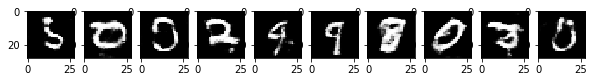

Epochs 4/10: Generator Loss: 0.427. Discriminator Loss: 0.26


Epochs 4/10: Generator Loss: 0.439. Discriminator Loss: 0.3


Epochs 4/10: Generator Loss: 0.46. Discriminator Loss: 0.243


Epochs 4/10: Generator Loss: 0.391. Discriminator Loss: 0.196


Epochs 4/10: Generator Loss: 0.46. Discriminator Loss: 0.131


Epochs 4/10: Generator Loss: 0.441. Discriminator Loss: 0.172


Epochs 4/10: Generator Loss: 0.438. Discriminator Loss: 0.237


Epochs 4/10: Generator Loss: 0.382. Discriminator Loss: 0.268


Epochs 4/10: Generator Loss: 0.485. Discriminator Loss: 0.222


Epochs 4/10: Generator Loss: 0.443. Discriminator Loss: 0.202


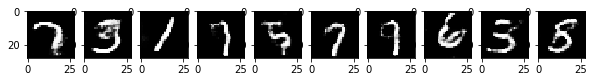

Epochs 4/10: Generator Loss: 0.482. Discriminator Loss: 0.225


Epochs 4/10: Generator Loss: 0.478. Discriminator Loss: 0.226


Epochs 4/10: Generator Loss: 0.465. Discriminator Loss: 0.24


Epochs 4/10: Generator Loss: 0.467. Discriminator Loss: 0.224


Epochs 4/10: Generator Loss: 0.46. Discriminator Loss: 0.228


Epochs 4/10: Generator Loss: 0.451. Discriminator Loss: 0.286


Epochs 4/10: Generator Loss: 0.468. Discriminator Loss: 0.294


Epochs 4/10: Generator Loss: 0.47. Discriminator Loss: 0.261


Epochs 4/10: Generator Loss: 0.451. Discriminator Loss: 0.241


Epochs 4/10: Generator Loss: 0.43. Discriminator Loss: 0.22


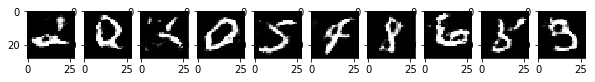

Epochs 4/10: Generator Loss: 0.416. Discriminator Loss: 0.235


Epochs 4/10: Generator Loss: 0.482. Discriminator Loss: 0.175


Epochs 4/10: Generator Loss: 0.434. Discriminator Loss: 0.182


Epochs 4/10: Generator Loss: 0.465. Discriminator Loss: 0.194


Epochs 4/10: Generator Loss: 0.459. Discriminator Loss: 0.214


Epochs 4/10: Generator Loss: 0.476. Discriminator Loss: 0.253


Epochs 4/10: Generator Loss: 0.466. Discriminator Loss: 0.213


Epochs 4/10: Generator Loss: 0.432. Discriminator Loss: 0.242


Epochs 4/10: Generator Loss: 0.478. Discriminator Loss: 0.176


Epochs 4/10: Generator Loss: 0.472. Discriminator Loss: 0.24


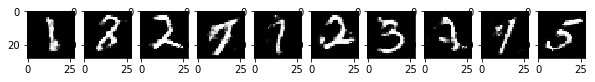

Epochs 4/10: Generator Loss: 0.414. Discriminator Loss: 0.258


Epochs 4/10: Generator Loss: 0.441. Discriminator Loss: 0.245


Epochs 4/10: Generator Loss: 0.461. Discriminator Loss: 0.246


Epochs 4/10: Generator Loss: 0.456. Discriminator Loss: 0.247


Epochs 4/10: Generator Loss: 0.45. Discriminator Loss: 0.217


Epochs 4/10: Generator Loss: 0.469. Discriminator Loss: 0.208


Epochs 4/10: Generator Loss: 0.473. Discriminator Loss: 0.238


Epochs 4/10: Generator Loss: 0.474. Discriminator Loss: 0.254


Epochs 4/10: Generator Loss: 0.447. Discriminator Loss: 0.261


Epochs 4/10: Generator Loss: 0.46. Discriminator Loss: 0.302


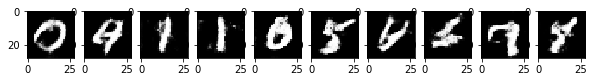

Epochs 4/10: Generator Loss: 0.431. Discriminator Loss: 0.269


Epochs 4/10: Generator Loss: 0.477. Discriminator Loss: 0.299


Epochs 4/10: Generator Loss: 0.457. Discriminator Loss: 0.257


Epochs 4/10: Generator Loss: 0.455. Discriminator Loss: 0.256


Epochs 4/10: Generator Loss: 0.436. Discriminator Loss: 0.22


Epochs 4/10: Generator Loss: 0.463. Discriminator Loss: 0.217


Epochs 4/10: Generator Loss: 0.494. Discriminator Loss: 0.189


Epochs 4/10: Generator Loss: 0.473. Discriminator Loss: 0.198


Epochs 4/10: Generator Loss: 0.475. Discriminator Loss: 0.194


Epochs 4/10: Generator Loss: 0.465. Discriminator Loss: 0.194


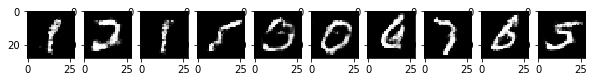

Epochs 4/10: Generator Loss: 0.457. Discriminator Loss: 0.184


Epochs 4/10: Generator Loss: 0.427. Discriminator Loss: 0.198


Epochs 4/10: Generator Loss: 0.438. Discriminator Loss: 0.214


Epochs 4/10: Generator Loss: 0.438. Discriminator Loss: 0.244


Epochs 4/10: Generator Loss: 0.457. Discriminator Loss: 0.24


Epochs 4/10: Generator Loss: 0.463. Discriminator Loss: 0.268


Epochs 4/10: Generator Loss: 0.439. Discriminator Loss: 0.194


Epochs 4/10: Generator Loss: 0.471. Discriminator Loss: 0.22


Epochs 4/10: Generator Loss: 0.458. Discriminator Loss: 0.25


Epochs 4/10: Generator Loss: 0.462. Discriminator Loss: 0.21


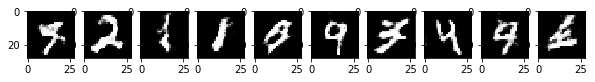

Epochs 4/10: Generator Loss: 0.467. Discriminator Loss: 0.141


Epochs 4/10: Generator Loss: 0.461. Discriminator Loss: 0.22


Epochs 4/10: Generator Loss: 0.476. Discriminator Loss: 0.209


Epochs 4/10: Generator Loss: 0.434. Discriminator Loss: 0.208


Epochs 4/10: Generator Loss: 0.445. Discriminator Loss: 0.194


Epochs 4/10: Generator Loss: 0.455. Discriminator Loss: 0.227


Epochs 4/10: Generator Loss: 0.479. Discriminator Loss: 0.207


Epochs 4/10: Generator Loss: 0.484. Discriminator Loss: 0.203


Epochs 4/10: Generator Loss: 0.433. Discriminator Loss: 0.156


Epochs 4/10: Generator Loss: 0.444. Discriminator Loss: 0.212


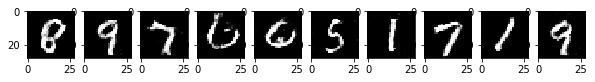

Epochs 4/10: Generator Loss: 0.46. Discriminator Loss: 0.169


Epochs 4/10: Generator Loss: 0.447. Discriminator Loss: 0.226


Epochs 4/10: Generator Loss: 0.446. Discriminator Loss: 0.262


Epochs 4/10: Generator Loss: 0.427. Discriminator Loss: 0.293


Epochs 4/10: Generator Loss: 0.462. Discriminator Loss: 0.27


Epochs 4/10: Generator Loss: 0.443. Discriminator Loss: 0.272


Epochs 4/10: Generator Loss: 0.475. Discriminator Loss: 0.285


Epochs 4/10: Generator Loss: 0.464. Discriminator Loss: 0.268


Epochs 4/10: Generator Loss: 0.45. Discriminator Loss: 0.252


Epochs 4/10: Generator Loss: 0.467. Discriminator Loss: 0.17


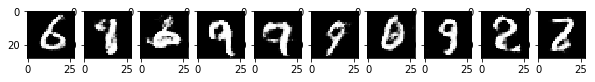

Epochs 4/10: Generator Loss: 0.43. Discriminator Loss: 0.197


Epochs 4/10: Generator Loss: 0.465. Discriminator Loss: 0.148


Epochs 4/10: Generator Loss: 0.427. Discriminator Loss: 0.203


Epochs 4/10: Generator Loss: 0.451. Discriminator Loss: 0.239


Epochs 4/10: Generator Loss: 0.461. Discriminator Loss: 0.208


Epochs 4/10: Generator Loss: 0.423. Discriminator Loss: 0.223


Epochs 4/10: Generator Loss: 0.479. Discriminator Loss: 0.191


Epochs 4/10: Generator Loss: 0.45. Discriminator Loss: 0.232


Epochs 4/10: Generator Loss: 0.465. Discriminator Loss: 0.229


Epochs 4/10: Generator Loss: 0.416. Discriminator Loss: 0.23


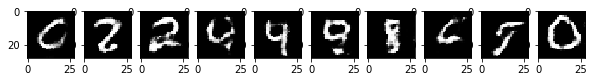

Epochs 4/10: Generator Loss: 0.465. Discriminator Loss: 0.207


Epochs 4/10: Generator Loss: 0.49. Discriminator Loss: 0.191


Epochs 4/10: Generator Loss: 0.439. Discriminator Loss: 0.258


Epochs 4/10: Generator Loss: 0.461. Discriminator Loss: 0.245


Epochs 4/10: Generator Loss: 0.461. Discriminator Loss: 0.238


Epochs 4/10: Generator Loss: 0.493. Discriminator Loss: 0.205


Epochs 4/10: Generator Loss: 0.457. Discriminator Loss: 0.213


Epochs 4/10: Generator Loss: 0.492. Discriminator Loss: 0.22


Epochs 4/10: Generator Loss: 0.399. Discriminator Loss: 0.278


Epochs 4/10: Generator Loss: 0.455. Discriminator Loss: 0.293


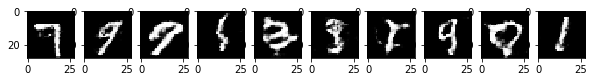

Epochs 4/10: Generator Loss: 0.479. Discriminator Loss: 0.243


Epochs 4/10: Generator Loss: 0.456. Discriminator Loss: 0.305


Epochs 4/10: Generator Loss: 0.483. Discriminator Loss: 0.295


Epochs 4/10: Generator Loss: 0.478. Discriminator Loss: 0.3


Epochs 4/10: Generator Loss: 0.444. Discriminator Loss: 0.289


Epochs 4/10: Generator Loss: 0.459. Discriminator Loss: 0.275


Epochs 4/10: Generator Loss: 0.399. Discriminator Loss: 0.3


Epochs 4/10: Generator Loss: 0.453. Discriminator Loss: 0.304


Epochs 4/10: Generator Loss: 0.48. Discriminator Loss: 0.252


Epochs 4/10: Generator Loss: 0.431. Discriminator Loss: 0.241


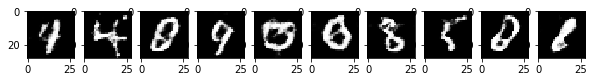

Epochs 4/10: Generator Loss: 0.452. Discriminator Loss: 0.237


Epochs 4/10: Generator Loss: 0.456. Discriminator Loss: 0.244


Epochs 4/10: Generator Loss: 0.458. Discriminator Loss: 0.277


Epochs 4/10: Generator Loss: 0.474. Discriminator Loss: 0.3


Epochs 4/10: Generator Loss: 0.47. Discriminator Loss: 0.287


Epochs 4/10: Generator Loss: 0.435. Discriminator Loss: 0.282


Epochs 4/10: Generator Loss: 0.46. Discriminator Loss: 0.283


Epochs 4/10: Generator Loss: 0.453. Discriminator Loss: 0.266


Epochs 4/10: Generator Loss: 0.442. Discriminator Loss: 0.233


Epochs 4/10: Generator Loss: 0.419. Discriminator Loss: 0.245


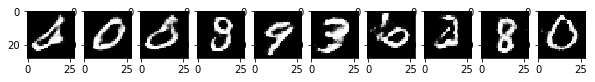

Epochs 4/10: Generator Loss: 0.435. Discriminator Loss: 0.251


Epochs 4/10: Generator Loss: 0.44. Discriminator Loss: 0.249


Epochs 4/10: Generator Loss: 0.451. Discriminator Loss: 0.232


Epochs 4/10: Generator Loss: 0.454. Discriminator Loss: 0.208


Epochs 4/10: Generator Loss: 0.454. Discriminator Loss: 0.199


Epochs 4/10: Generator Loss: 0.468. Discriminator Loss: 0.208


Epochs 4/10: Generator Loss: 0.445. Discriminator Loss: 0.28


Epochs 5/10: Generator Loss: 0.468. Discriminator Loss: 0.268


Epochs 5/10: Generator Loss: 0.409. Discriminator Loss: 0.253


Epochs 5/10: Generator Loss: 0.474. Discriminator Loss: 0.194


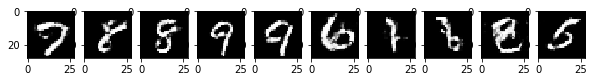

Epochs 5/10: Generator Loss: 0.429. Discriminator Loss: 0.234


Epochs 5/10: Generator Loss: 0.427. Discriminator Loss: 0.236


Epochs 5/10: Generator Loss: 0.462. Discriminator Loss: 0.258


Epochs 5/10: Generator Loss: 0.422. Discriminator Loss: 0.314


Epochs 5/10: Generator Loss: 0.466. Discriminator Loss: 0.303


Epochs 5/10: Generator Loss: 0.466. Discriminator Loss: 0.26


Epochs 5/10: Generator Loss: 0.434. Discriminator Loss: 0.208


Epochs 5/10: Generator Loss: 0.461. Discriminator Loss: 0.227


Epochs 5/10: Generator Loss: 0.438. Discriminator Loss: 0.239


Epochs 5/10: Generator Loss: 0.467. Discriminator Loss: 0.248


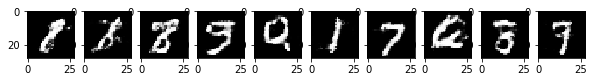

Epochs 5/10: Generator Loss: 0.466. Discriminator Loss: 0.227


Epochs 5/10: Generator Loss: 0.489. Discriminator Loss: 0.19


Epochs 5/10: Generator Loss: 0.468. Discriminator Loss: 0.196


Epochs 5/10: Generator Loss: 0.486. Discriminator Loss: 0.219


Epochs 5/10: Generator Loss: 0.466. Discriminator Loss: 0.248


Epochs 5/10: Generator Loss: 0.461. Discriminator Loss: 0.229


Epochs 5/10: Generator Loss: 0.432. Discriminator Loss: 0.225


Epochs 5/10: Generator Loss: 0.425. Discriminator Loss: 0.242


Epochs 5/10: Generator Loss: 0.422. Discriminator Loss: 0.253


Epochs 5/10: Generator Loss: 0.454. Discriminator Loss: 0.235


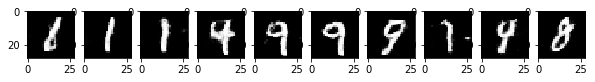

Epochs 5/10: Generator Loss: 0.473. Discriminator Loss: 0.19


Epochs 5/10: Generator Loss: 0.436. Discriminator Loss: 0.261


Epochs 5/10: Generator Loss: 0.445. Discriminator Loss: 0.252


Epochs 5/10: Generator Loss: 0.459. Discriminator Loss: 0.21


Epochs 5/10: Generator Loss: 0.416. Discriminator Loss: 0.202


Epochs 5/10: Generator Loss: 0.447. Discriminator Loss: 0.187


Epochs 5/10: Generator Loss: 0.438. Discriminator Loss: 0.223


Epochs 5/10: Generator Loss: 0.471. Discriminator Loss: 0.239


Epochs 5/10: Generator Loss: 0.439. Discriminator Loss: 0.27


Epochs 5/10: Generator Loss: 0.482. Discriminator Loss: 0.206


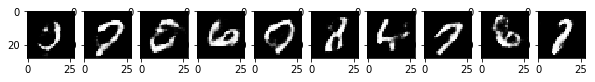

Epochs 5/10: Generator Loss: 0.487. Discriminator Loss: 0.205


Epochs 5/10: Generator Loss: 0.433. Discriminator Loss: 0.206


Epochs 5/10: Generator Loss: 0.45. Discriminator Loss: 0.229


Epochs 5/10: Generator Loss: 0.417. Discriminator Loss: 0.248


Epochs 5/10: Generator Loss: 0.463. Discriminator Loss: 0.217


Epochs 5/10: Generator Loss: 0.448. Discriminator Loss: 0.232


Epochs 5/10: Generator Loss: 0.411. Discriminator Loss: 0.235


Epochs 5/10: Generator Loss: 0.41. Discriminator Loss: 0.233


Epochs 5/10: Generator Loss: 0.432. Discriminator Loss: 0.222


Epochs 5/10: Generator Loss: 0.468. Discriminator Loss: 0.224


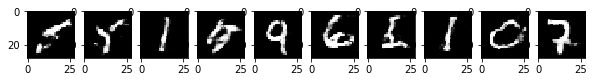

Epochs 5/10: Generator Loss: 0.468. Discriminator Loss: 0.237


Epochs 5/10: Generator Loss: 0.484. Discriminator Loss: 0.221


Epochs 5/10: Generator Loss: 0.471. Discriminator Loss: 0.197


Epochs 5/10: Generator Loss: 0.473. Discriminator Loss: 0.23


Epochs 5/10: Generator Loss: 0.479. Discriminator Loss: 0.237


Epochs 5/10: Generator Loss: 0.438. Discriminator Loss: 0.282


Epochs 5/10: Generator Loss: 0.401. Discriminator Loss: 0.27


Epochs 5/10: Generator Loss: 0.469. Discriminator Loss: 0.255


Epochs 5/10: Generator Loss: 0.432. Discriminator Loss: 0.234


Epochs 5/10: Generator Loss: 0.428. Discriminator Loss: 0.223


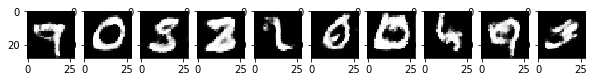

Epochs 5/10: Generator Loss: 0.476. Discriminator Loss: 0.194


Epochs 5/10: Generator Loss: 0.43. Discriminator Loss: 0.222


Epochs 5/10: Generator Loss: 0.475. Discriminator Loss: 0.206


Epochs 5/10: Generator Loss: 0.477. Discriminator Loss: 0.19


Epochs 5/10: Generator Loss: 0.459. Discriminator Loss: 0.198


Epochs 5/10: Generator Loss: 0.447. Discriminator Loss: 0.183


Epochs 5/10: Generator Loss: 0.448. Discriminator Loss: 0.161


Epochs 5/10: Generator Loss: 0.387. Discriminator Loss: 0.263


Epochs 5/10: Generator Loss: 0.444. Discriminator Loss: 0.256


Epochs 5/10: Generator Loss: 0.41. Discriminator Loss: 0.287


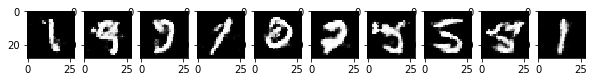

Epochs 5/10: Generator Loss: 0.472. Discriminator Loss: 0.216


Epochs 5/10: Generator Loss: 0.443. Discriminator Loss: 0.182


Epochs 5/10: Generator Loss: 0.482. Discriminator Loss: 0.142


Epochs 5/10: Generator Loss: 0.425. Discriminator Loss: 0.221


Epochs 5/10: Generator Loss: 0.455. Discriminator Loss: 0.226


Epochs 5/10: Generator Loss: 0.405. Discriminator Loss: 0.202


Epochs 5/10: Generator Loss: 0.389. Discriminator Loss: 0.221


Epochs 5/10: Generator Loss: 0.441. Discriminator Loss: 0.23


Epochs 5/10: Generator Loss: 0.475. Discriminator Loss: 0.238


Epochs 5/10: Generator Loss: 0.437. Discriminator Loss: 0.24


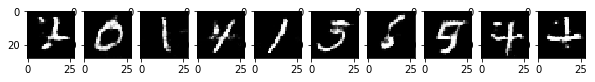

Epochs 5/10: Generator Loss: 0.454. Discriminator Loss: 0.199


Epochs 5/10: Generator Loss: 0.474. Discriminator Loss: 0.237


Epochs 5/10: Generator Loss: 0.456. Discriminator Loss: 0.251


Epochs 5/10: Generator Loss: 0.469. Discriminator Loss: 0.224


Epochs 5/10: Generator Loss: 0.471. Discriminator Loss: 0.236


Epochs 5/10: Generator Loss: 0.444. Discriminator Loss: 0.254


Epochs 5/10: Generator Loss: 0.413. Discriminator Loss: 0.225


Epochs 5/10: Generator Loss: 0.411. Discriminator Loss: 0.222


Epochs 5/10: Generator Loss: 0.441. Discriminator Loss: 0.222


Epochs 5/10: Generator Loss: 0.434. Discriminator Loss: 0.203


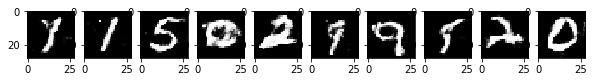

Epochs 5/10: Generator Loss: 0.431. Discriminator Loss: 0.146


Epochs 5/10: Generator Loss: 0.444. Discriminator Loss: 0.179


Epochs 5/10: Generator Loss: 0.478. Discriminator Loss: 0.21


Epochs 5/10: Generator Loss: 0.469. Discriminator Loss: 0.19


Epochs 5/10: Generator Loss: 0.398. Discriminator Loss: 0.243


Epochs 5/10: Generator Loss: 0.477. Discriminator Loss: 0.159


Epochs 5/10: Generator Loss: 0.443. Discriminator Loss: 0.247


Epochs 5/10: Generator Loss: 0.464. Discriminator Loss: 0.22


Epochs 5/10: Generator Loss: 0.48. Discriminator Loss: 0.238


Epochs 5/10: Generator Loss: 0.449. Discriminator Loss: 0.279


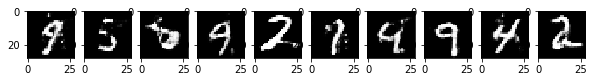

Epochs 5/10: Generator Loss: 0.47. Discriminator Loss: 0.268


Epochs 5/10: Generator Loss: 0.445. Discriminator Loss: 0.265


Epochs 5/10: Generator Loss: 0.445. Discriminator Loss: 0.248


Epochs 5/10: Generator Loss: 0.455. Discriminator Loss: 0.188


Epochs 5/10: Generator Loss: 0.466. Discriminator Loss: 0.213


Epochs 5/10: Generator Loss: 0.483. Discriminator Loss: 0.237


Epochs 5/10: Generator Loss: 0.457. Discriminator Loss: 0.303


Epochs 5/10: Generator Loss: 0.465. Discriminator Loss: 0.264


Epochs 5/10: Generator Loss: 0.468. Discriminator Loss: 0.24


Epochs 5/10: Generator Loss: 0.462. Discriminator Loss: 0.254


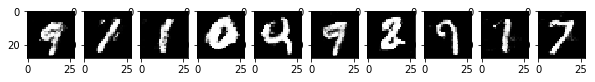

Epochs 5/10: Generator Loss: 0.488. Discriminator Loss: 0.267


Epochs 5/10: Generator Loss: 0.484. Discriminator Loss: 0.251


Epochs 5/10: Generator Loss: 0.464. Discriminator Loss: 0.212


Epochs 5/10: Generator Loss: 0.438. Discriminator Loss: 0.229


Epochs 5/10: Generator Loss: 0.443. Discriminator Loss: 0.223


Epochs 5/10: Generator Loss: 0.459. Discriminator Loss: 0.22


Epochs 5/10: Generator Loss: 0.447. Discriminator Loss: 0.203


Epochs 5/10: Generator Loss: 0.429. Discriminator Loss: 0.202


Epochs 5/10: Generator Loss: 0.43. Discriminator Loss: 0.19


Epochs 5/10: Generator Loss: 0.463. Discriminator Loss: 0.176


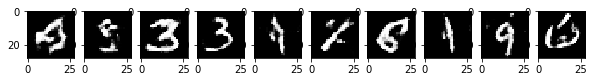

Epochs 5/10: Generator Loss: 0.457. Discriminator Loss: 0.242


Epochs 5/10: Generator Loss: 0.471. Discriminator Loss: 0.223


Epochs 5/10: Generator Loss: 0.464. Discriminator Loss: 0.239


Epochs 5/10: Generator Loss: 0.388. Discriminator Loss: 0.223


Epochs 5/10: Generator Loss: 0.46. Discriminator Loss: 0.199


Epochs 5/10: Generator Loss: 0.442. Discriminator Loss: 0.225


Epochs 5/10: Generator Loss: 0.448. Discriminator Loss: 0.209


Epochs 5/10: Generator Loss: 0.41. Discriminator Loss: 0.228


Epochs 5/10: Generator Loss: 0.435. Discriminator Loss: 0.181


Epochs 5/10: Generator Loss: 0.419. Discriminator Loss: 0.226


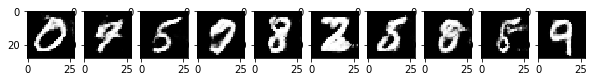

Epochs 5/10: Generator Loss: 0.424. Discriminator Loss: 0.21


Epochs 5/10: Generator Loss: 0.423. Discriminator Loss: 0.199


Epochs 5/10: Generator Loss: 0.481. Discriminator Loss: 0.174


Epochs 5/10: Generator Loss: 0.447. Discriminator Loss: 0.225


Epochs 5/10: Generator Loss: 0.472. Discriminator Loss: 0.194


Epochs 5/10: Generator Loss: 0.399. Discriminator Loss: 0.202


Epochs 5/10: Generator Loss: 0.456. Discriminator Loss: 0.133


Epochs 5/10: Generator Loss: 0.448. Discriminator Loss: 0.175


Epochs 5/10: Generator Loss: 0.407. Discriminator Loss: 0.21


Epochs 5/10: Generator Loss: 0.443. Discriminator Loss: 0.194


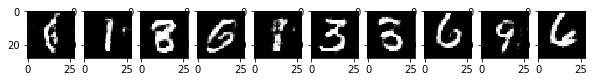

Epochs 5/10: Generator Loss: 0.418. Discriminator Loss: 0.23


Epochs 5/10: Generator Loss: 0.436. Discriminator Loss: 0.256


Epochs 5/10: Generator Loss: 0.477. Discriminator Loss: 0.25


Epochs 5/10: Generator Loss: 0.474. Discriminator Loss: 0.235


Epochs 5/10: Generator Loss: 0.495. Discriminator Loss: 0.266


Epochs 5/10: Generator Loss: 0.462. Discriminator Loss: 0.258


Epochs 5/10: Generator Loss: 0.441. Discriminator Loss: 0.212


Epochs 5/10: Generator Loss: 0.465. Discriminator Loss: 0.16


Epochs 5/10: Generator Loss: 0.475. Discriminator Loss: 0.16


Epochs 5/10: Generator Loss: 0.441. Discriminator Loss: 0.186


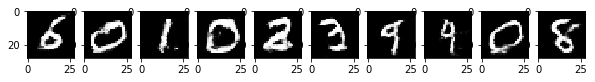

Epochs 5/10: Generator Loss: 0.464. Discriminator Loss: 0.193


Epochs 5/10: Generator Loss: 0.447. Discriminator Loss: 0.191


Epochs 5/10: Generator Loss: 0.477. Discriminator Loss: 0.208


Epochs 5/10: Generator Loss: 0.433. Discriminator Loss: 0.191


Epochs 5/10: Generator Loss: 0.434. Discriminator Loss: 0.206


Epochs 5/10: Generator Loss: 0.418. Discriminator Loss: 0.237


Epochs 5/10: Generator Loss: 0.485. Discriminator Loss: 0.215


Epochs 5/10: Generator Loss: 0.433. Discriminator Loss: 0.168


Epochs 5/10: Generator Loss: 0.391. Discriminator Loss: 0.21


Epochs 5/10: Generator Loss: 0.388. Discriminator Loss: 0.239


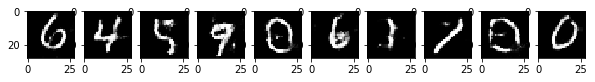

Epochs 5/10: Generator Loss: 0.474. Discriminator Loss: 0.241


Epochs 5/10: Generator Loss: 0.462. Discriminator Loss: 0.24


Epochs 5/10: Generator Loss: 0.444. Discriminator Loss: 0.233


Epochs 5/10: Generator Loss: 0.419. Discriminator Loss: 0.217


Epochs 5/10: Generator Loss: 0.454. Discriminator Loss: 0.246


Epochs 5/10: Generator Loss: 0.458. Discriminator Loss: 0.251


Epochs 5/10: Generator Loss: 0.422. Discriminator Loss: 0.252


Epochs 5/10: Generator Loss: 0.407. Discriminator Loss: 0.264


Epochs 5/10: Generator Loss: 0.438. Discriminator Loss: 0.235


Epochs 5/10: Generator Loss: 0.45. Discriminator Loss: 0.302


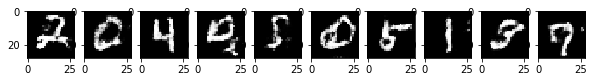

Epochs 5/10: Generator Loss: 0.444. Discriminator Loss: 0.315


Epochs 5/10: Generator Loss: 0.494. Discriminator Loss: 0.266


Epochs 5/10: Generator Loss: 0.479. Discriminator Loss: 0.235


Epochs 5/10: Generator Loss: 0.449. Discriminator Loss: 0.278


Epochs 5/10: Generator Loss: 0.449. Discriminator Loss: 0.265


Epochs 5/10: Generator Loss: 0.458. Discriminator Loss: 0.243


Epochs 5/10: Generator Loss: 0.485. Discriminator Loss: 0.251


Epochs 5/10: Generator Loss: 0.465. Discriminator Loss: 0.213


Epochs 5/10: Generator Loss: 0.464. Discriminator Loss: 0.242


Epochs 5/10: Generator Loss: 0.479. Discriminator Loss: 0.268


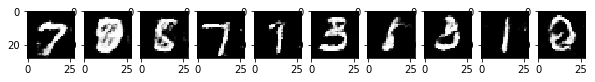

Epochs 5/10: Generator Loss: 0.494. Discriminator Loss: 0.297


Epochs 5/10: Generator Loss: 0.456. Discriminator Loss: 0.316


Epochs 5/10: Generator Loss: 0.452. Discriminator Loss: 0.282


Epochs 5/10: Generator Loss: 0.455. Discriminator Loss: 0.278


Epochs 5/10: Generator Loss: 0.467. Discriminator Loss: 0.279


Epochs 5/10: Generator Loss: 0.472. Discriminator Loss: 0.259


Epochs 5/10: Generator Loss: 0.458. Discriminator Loss: 0.243


Epochs 5/10: Generator Loss: 0.44. Discriminator Loss: 0.22


Epochs 5/10: Generator Loss: 0.482. Discriminator Loss: 0.253


Epochs 5/10: Generator Loss: 0.449. Discriminator Loss: 0.285


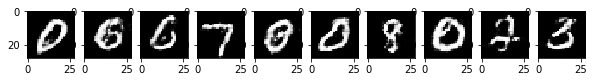

Epochs 5/10: Generator Loss: 0.392. Discriminator Loss: 0.266


Epochs 5/10: Generator Loss: 0.475. Discriminator Loss: 0.21


Epochs 5/10: Generator Loss: 0.469. Discriminator Loss: 0.18


Epochs 5/10: Generator Loss: 0.453. Discriminator Loss: 0.226


Epochs 6/10: Generator Loss: 0.413. Discriminator Loss: 0.398


Epochs 6/10: Generator Loss: 0.46. Discriminator Loss: 0.26


Epochs 6/10: Generator Loss: 0.472. Discriminator Loss: 0.191


Epochs 6/10: Generator Loss: 0.398. Discriminator Loss: 0.229


Epochs 6/10: Generator Loss: 0.473. Discriminator Loss: 0.193


Epochs 6/10: Generator Loss: 0.461. Discriminator Loss: 0.229


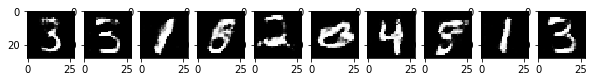

Epochs 6/10: Generator Loss: 0.465. Discriminator Loss: 0.277


Epochs 6/10: Generator Loss: 0.446. Discriminator Loss: 0.278


Epochs 6/10: Generator Loss: 0.437. Discriminator Loss: 0.245


Epochs 6/10: Generator Loss: 0.446. Discriminator Loss: 0.219


Epochs 6/10: Generator Loss: 0.443. Discriminator Loss: 0.188


Epochs 6/10: Generator Loss: 0.448. Discriminator Loss: 0.236


Epochs 6/10: Generator Loss: 0.436. Discriminator Loss: 0.207


Epochs 6/10: Generator Loss: 0.47. Discriminator Loss: 0.216


Epochs 6/10: Generator Loss: 0.423. Discriminator Loss: 0.201


Epochs 6/10: Generator Loss: 0.474. Discriminator Loss: 0.195


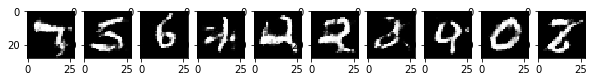

Epochs 6/10: Generator Loss: 0.489. Discriminator Loss: 0.186


Epochs 6/10: Generator Loss: 0.462. Discriminator Loss: 0.217


Epochs 6/10: Generator Loss: 0.424. Discriminator Loss: 0.249


Epochs 6/10: Generator Loss: 0.463. Discriminator Loss: 0.238


Epochs 6/10: Generator Loss: 0.469. Discriminator Loss: 0.221


Epochs 6/10: Generator Loss: 0.418. Discriminator Loss: 0.257


Epochs 6/10: Generator Loss: 0.432. Discriminator Loss: 0.238


Epochs 6/10: Generator Loss: 0.445. Discriminator Loss: 0.211


Epochs 6/10: Generator Loss: 0.449. Discriminator Loss: 0.239


Epochs 6/10: Generator Loss: 0.481. Discriminator Loss: 0.192


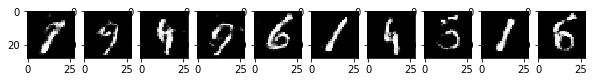

Epochs 6/10: Generator Loss: 0.471. Discriminator Loss: 0.193


Epochs 6/10: Generator Loss: 0.483. Discriminator Loss: 0.203


Epochs 6/10: Generator Loss: 0.467. Discriminator Loss: 0.177


Epochs 6/10: Generator Loss: 0.445. Discriminator Loss: 0.169


Epochs 6/10: Generator Loss: 0.479. Discriminator Loss: 0.237


Epochs 6/10: Generator Loss: 0.439. Discriminator Loss: 0.277


Epochs 6/10: Generator Loss: 0.464. Discriminator Loss: 0.265


Epochs 6/10: Generator Loss: 0.467. Discriminator Loss: 0.177


Epochs 6/10: Generator Loss: 0.442. Discriminator Loss: 0.213


Epochs 6/10: Generator Loss: 0.414. Discriminator Loss: 0.251


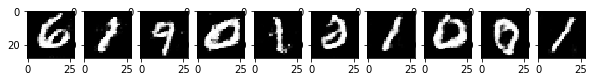

Epochs 6/10: Generator Loss: 0.486. Discriminator Loss: 0.236


Epochs 6/10: Generator Loss: 0.47. Discriminator Loss: 0.235


Epochs 6/10: Generator Loss: 0.458. Discriminator Loss: 0.227


Epochs 6/10: Generator Loss: 0.439. Discriminator Loss: 0.253


Epochs 6/10: Generator Loss: 0.478. Discriminator Loss: 0.19


Epochs 6/10: Generator Loss: 0.416. Discriminator Loss: 0.198


Epochs 6/10: Generator Loss: 0.476. Discriminator Loss: 0.209


Epochs 6/10: Generator Loss: 0.413. Discriminator Loss: 0.259


Epochs 6/10: Generator Loss: 0.492. Discriminator Loss: 0.22


Epochs 6/10: Generator Loss: 0.442. Discriminator Loss: 0.23


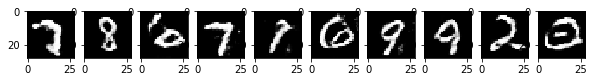

Epochs 6/10: Generator Loss: 0.438. Discriminator Loss: 0.226


Epochs 6/10: Generator Loss: 0.452. Discriminator Loss: 0.197


Epochs 6/10: Generator Loss: 0.465. Discriminator Loss: 0.206


Epochs 6/10: Generator Loss: 0.457. Discriminator Loss: 0.226


Epochs 6/10: Generator Loss: 0.432. Discriminator Loss: 0.217


Epochs 6/10: Generator Loss: 0.476. Discriminator Loss: 0.205


Epochs 6/10: Generator Loss: 0.484. Discriminator Loss: 0.189


Epochs 6/10: Generator Loss: 0.465. Discriminator Loss: 0.195


Epochs 6/10: Generator Loss: 0.47. Discriminator Loss: 0.207


Epochs 6/10: Generator Loss: 0.495. Discriminator Loss: 0.19


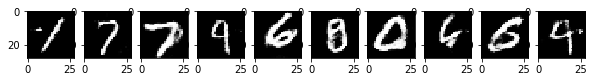

Epochs 6/10: Generator Loss: 0.454. Discriminator Loss: 0.219


Epochs 6/10: Generator Loss: 0.423. Discriminator Loss: 0.178


Epochs 6/10: Generator Loss: 0.476. Discriminator Loss: 0.16


Epochs 6/10: Generator Loss: 0.388. Discriminator Loss: 0.166


Epochs 6/10: Generator Loss: 0.461. Discriminator Loss: 0.184


Epochs 6/10: Generator Loss: 0.464. Discriminator Loss: 0.183


Epochs 6/10: Generator Loss: 0.438. Discriminator Loss: 0.265


Epochs 6/10: Generator Loss: 0.455. Discriminator Loss: 0.229


Epochs 6/10: Generator Loss: 0.42. Discriminator Loss: 0.165


Epochs 6/10: Generator Loss: 0.432. Discriminator Loss: 0.159


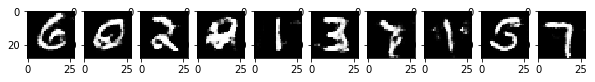

Epochs 6/10: Generator Loss: 0.41. Discriminator Loss: 0.166


Epochs 6/10: Generator Loss: 0.465. Discriminator Loss: 0.211


Epochs 6/10: Generator Loss: 0.456. Discriminator Loss: 0.207


Epochs 6/10: Generator Loss: 0.459. Discriminator Loss: 0.23


Epochs 6/10: Generator Loss: 0.475. Discriminator Loss: 0.193


Epochs 6/10: Generator Loss: 0.479. Discriminator Loss: 0.224


Epochs 6/10: Generator Loss: 0.485. Discriminator Loss: 0.223


Epochs 6/10: Generator Loss: 0.453. Discriminator Loss: 0.235


Epochs 6/10: Generator Loss: 0.457. Discriminator Loss: 0.229


Epochs 6/10: Generator Loss: 0.463. Discriminator Loss: 0.236


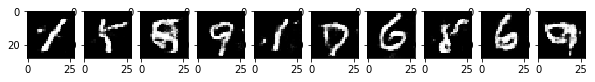

Epochs 6/10: Generator Loss: 0.471. Discriminator Loss: 0.243


Epochs 6/10: Generator Loss: 0.479. Discriminator Loss: 0.253


Epochs 6/10: Generator Loss: 0.462. Discriminator Loss: 0.273


Epochs 6/10: Generator Loss: 0.458. Discriminator Loss: 0.233


Epochs 6/10: Generator Loss: 0.449. Discriminator Loss: 0.224


Epochs 6/10: Generator Loss: 0.431. Discriminator Loss: 0.23


Epochs 6/10: Generator Loss: 0.467. Discriminator Loss: 0.178


Epochs 6/10: Generator Loss: 0.446. Discriminator Loss: 0.166


Epochs 6/10: Generator Loss: 0.434. Discriminator Loss: 0.163


Epochs 6/10: Generator Loss: 0.462. Discriminator Loss: 0.184


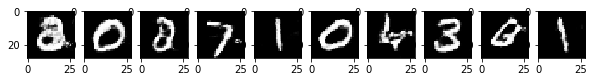

Epochs 6/10: Generator Loss: 0.474. Discriminator Loss: 0.209


Epochs 6/10: Generator Loss: 0.442. Discriminator Loss: 0.203


Epochs 6/10: Generator Loss: 0.478. Discriminator Loss: 0.159


Epochs 6/10: Generator Loss: 0.455. Discriminator Loss: 0.179


Epochs 6/10: Generator Loss: 0.461. Discriminator Loss: 0.238


Epochs 6/10: Generator Loss: 0.481. Discriminator Loss: 0.222


Epochs 6/10: Generator Loss: 0.442. Discriminator Loss: 0.233


Epochs 6/10: Generator Loss: 0.456. Discriminator Loss: 0.212


Epochs 6/10: Generator Loss: 0.454. Discriminator Loss: 0.216


Epochs 6/10: Generator Loss: 0.429. Discriminator Loss: 0.215


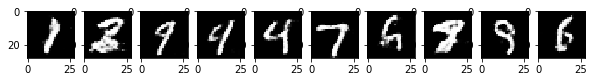

Epochs 6/10: Generator Loss: 0.421. Discriminator Loss: 0.209


Epochs 6/10: Generator Loss: 0.439. Discriminator Loss: 0.235


Epochs 6/10: Generator Loss: 0.454. Discriminator Loss: 0.248


Epochs 6/10: Generator Loss: 0.48. Discriminator Loss: 0.263


Epochs 6/10: Generator Loss: 0.472. Discriminator Loss: 0.287


Epochs 6/10: Generator Loss: 0.467. Discriminator Loss: 0.226


Epochs 6/10: Generator Loss: 0.492. Discriminator Loss: 0.266


Epochs 6/10: Generator Loss: 0.465. Discriminator Loss: 0.227


Epochs 6/10: Generator Loss: 0.486. Discriminator Loss: 0.237


Epochs 6/10: Generator Loss: 0.456. Discriminator Loss: 0.206


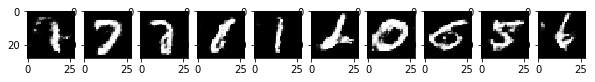

Epochs 6/10: Generator Loss: 0.487. Discriminator Loss: 0.204


Epochs 6/10: Generator Loss: 0.41. Discriminator Loss: 0.215


Epochs 6/10: Generator Loss: 0.489. Discriminator Loss: 0.19


Epochs 6/10: Generator Loss: 0.484. Discriminator Loss: 0.197


Epochs 6/10: Generator Loss: 0.444. Discriminator Loss: 0.204


Epochs 6/10: Generator Loss: 0.475. Discriminator Loss: 0.165


Epochs 6/10: Generator Loss: 0.472. Discriminator Loss: 0.16


Epochs 6/10: Generator Loss: 0.459. Discriminator Loss: 0.196


Epochs 6/10: Generator Loss: 0.452. Discriminator Loss: 0.196


Epochs 6/10: Generator Loss: 0.414. Discriminator Loss: 0.235


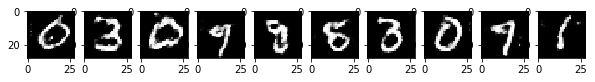

Epochs 6/10: Generator Loss: 0.469. Discriminator Loss: 0.194


Epochs 6/10: Generator Loss: 0.423. Discriminator Loss: 0.186


Epochs 6/10: Generator Loss: 0.466. Discriminator Loss: 0.178


Epochs 6/10: Generator Loss: 0.463. Discriminator Loss: 0.219


Epochs 6/10: Generator Loss: 0.457. Discriminator Loss: 0.225


Epochs 6/10: Generator Loss: 0.475. Discriminator Loss: 0.166


Epochs 6/10: Generator Loss: 0.465. Discriminator Loss: 0.195


Epochs 6/10: Generator Loss: 0.484. Discriminator Loss: 0.19


Epochs 6/10: Generator Loss: 0.453. Discriminator Loss: 0.177


Epochs 6/10: Generator Loss: 0.417. Discriminator Loss: 0.161


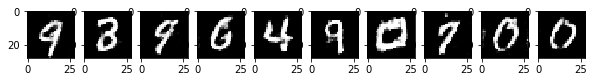

Epochs 6/10: Generator Loss: 0.497. Discriminator Loss: 0.204


Epochs 6/10: Generator Loss: 0.451. Discriminator Loss: 0.223


Epochs 6/10: Generator Loss: 0.49. Discriminator Loss: 0.2


Epochs 6/10: Generator Loss: 0.463. Discriminator Loss: 0.158


Epochs 6/10: Generator Loss: 0.47. Discriminator Loss: 0.198


Epochs 6/10: Generator Loss: 0.484. Discriminator Loss: 0.168


Epochs 6/10: Generator Loss: 0.471. Discriminator Loss: 0.22


Epochs 6/10: Generator Loss: 0.447. Discriminator Loss: 0.248


Epochs 6/10: Generator Loss: 0.484. Discriminator Loss: 0.246


Epochs 6/10: Generator Loss: 0.485. Discriminator Loss: 0.238


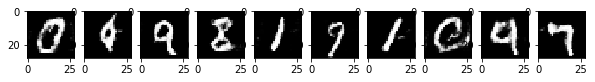

Epochs 6/10: Generator Loss: 0.441. Discriminator Loss: 0.241


Epochs 6/10: Generator Loss: 0.453. Discriminator Loss: 0.315


Epochs 6/10: Generator Loss: 0.453. Discriminator Loss: 0.291


Epochs 6/10: Generator Loss: 0.443. Discriminator Loss: 0.249


Epochs 6/10: Generator Loss: 0.461. Discriminator Loss: 0.166


Epochs 6/10: Generator Loss: 0.47. Discriminator Loss: 0.16


Epochs 6/10: Generator Loss: 0.447. Discriminator Loss: 0.158


Epochs 6/10: Generator Loss: 0.49. Discriminator Loss: 0.189


Epochs 6/10: Generator Loss: 0.468. Discriminator Loss: 0.242


Epochs 6/10: Generator Loss: 0.437. Discriminator Loss: 0.194


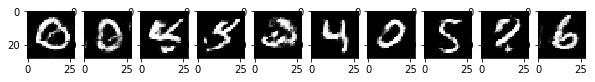

Epochs 6/10: Generator Loss: 0.475. Discriminator Loss: 0.175


Epochs 6/10: Generator Loss: 0.45. Discriminator Loss: 0.197


Epochs 6/10: Generator Loss: 0.437. Discriminator Loss: 0.223


Epochs 6/10: Generator Loss: 0.461. Discriminator Loss: 0.227


Epochs 6/10: Generator Loss: 0.413. Discriminator Loss: 0.213


Epochs 6/10: Generator Loss: 0.436. Discriminator Loss: 0.152


Epochs 6/10: Generator Loss: 0.467. Discriminator Loss: 0.171


Epochs 6/10: Generator Loss: 0.413. Discriminator Loss: 0.233


Epochs 6/10: Generator Loss: 0.457. Discriminator Loss: 0.241


Epochs 6/10: Generator Loss: 0.455. Discriminator Loss: 0.228


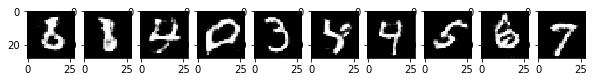

Epochs 6/10: Generator Loss: 0.454. Discriminator Loss: 0.213


Epochs 6/10: Generator Loss: 0.467. Discriminator Loss: 0.192


Epochs 6/10: Generator Loss: 0.486. Discriminator Loss: 0.22


Epochs 6/10: Generator Loss: 0.467. Discriminator Loss: 0.225


Epochs 6/10: Generator Loss: 0.474. Discriminator Loss: 0.239


Epochs 6/10: Generator Loss: 0.469. Discriminator Loss: 0.214


Epochs 6/10: Generator Loss: 0.453. Discriminator Loss: 0.284


Epochs 6/10: Generator Loss: 0.449. Discriminator Loss: 0.268


Epochs 6/10: Generator Loss: 0.445. Discriminator Loss: 0.265


Epochs 6/10: Generator Loss: 0.455. Discriminator Loss: 0.211


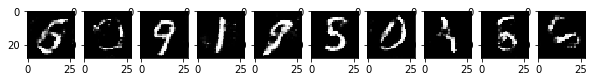

Epochs 6/10: Generator Loss: 0.469. Discriminator Loss: 0.248


Epochs 6/10: Generator Loss: 0.487. Discriminator Loss: 0.252


Epochs 6/10: Generator Loss: 0.461. Discriminator Loss: 0.273


Epochs 6/10: Generator Loss: 0.484. Discriminator Loss: 0.264


Epochs 6/10: Generator Loss: 0.479. Discriminator Loss: 0.223


Epochs 6/10: Generator Loss: 0.455. Discriminator Loss: 0.212


Epochs 6/10: Generator Loss: 0.49. Discriminator Loss: 0.235


Epochs 6/10: Generator Loss: 0.486. Discriminator Loss: 0.27


Epochs 6/10: Generator Loss: 0.48. Discriminator Loss: 0.301


Epochs 6/10: Generator Loss: 0.471. Discriminator Loss: 0.285


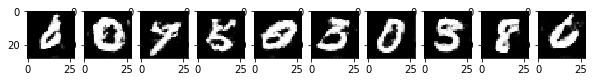

Epochs 6/10: Generator Loss: 0.482. Discriminator Loss: 0.252


Epochs 6/10: Generator Loss: 0.448. Discriminator Loss: 0.285


Epochs 6/10: Generator Loss: 0.475. Discriminator Loss: 0.259


Epochs 6/10: Generator Loss: 0.461. Discriminator Loss: 0.244


Epochs 6/10: Generator Loss: 0.465. Discriminator Loss: 0.224


Epochs 6/10: Generator Loss: 0.469. Discriminator Loss: 0.218


Epochs 6/10: Generator Loss: 0.44. Discriminator Loss: 0.244


Epochs 6/10: Generator Loss: 0.432. Discriminator Loss: 0.237


Epochs 6/10: Generator Loss: 0.487. Discriminator Loss: 0.199


Epochs 6/10: Generator Loss: 0.416. Discriminator Loss: 0.191


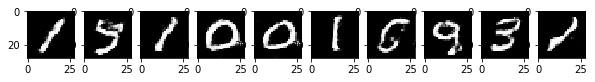

Epochs 6/10: Generator Loss: 0.474. Discriminator Loss: 0.211


Epochs 6/10: Generator Loss: 0.463. Discriminator Loss: 0.224


Epochs 7/10: Generator Loss: 0.454. Discriminator Loss: 0.246


Epochs 7/10: Generator Loss: 0.454. Discriminator Loss: 0.206


Epochs 7/10: Generator Loss: 0.454. Discriminator Loss: 0.179


Epochs 7/10: Generator Loss: 0.43. Discriminator Loss: 0.203


Epochs 7/10: Generator Loss: 0.434. Discriminator Loss: 0.193


Epochs 7/10: Generator Loss: 0.473. Discriminator Loss: 0.227


Epochs 7/10: Generator Loss: 0.495. Discriminator Loss: 0.235


Epochs 7/10: Generator Loss: 0.498. Discriminator Loss: 0.281


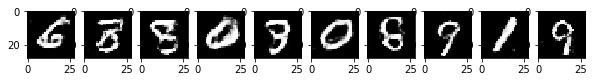

Epochs 7/10: Generator Loss: 0.433. Discriminator Loss: 0.216


Epochs 7/10: Generator Loss: 0.441. Discriminator Loss: 0.166


Epochs 7/10: Generator Loss: 0.489. Discriminator Loss: 0.173


Epochs 7/10: Generator Loss: 0.432. Discriminator Loss: 0.214


Epochs 7/10: Generator Loss: 0.478. Discriminator Loss: 0.252


Epochs 7/10: Generator Loss: 0.474. Discriminator Loss: 0.233


Epochs 7/10: Generator Loss: 0.477. Discriminator Loss: 0.227


Epochs 7/10: Generator Loss: 0.467. Discriminator Loss: 0.187


Epochs 7/10: Generator Loss: 0.459. Discriminator Loss: 0.215


Epochs 7/10: Generator Loss: 0.48. Discriminator Loss: 0.264


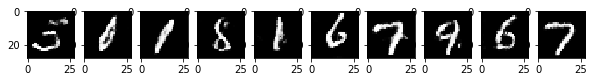

Epochs 7/10: Generator Loss: 0.44. Discriminator Loss: 0.24


Epochs 7/10: Generator Loss: 0.489. Discriminator Loss: 0.204


Epochs 7/10: Generator Loss: 0.459. Discriminator Loss: 0.224


Epochs 7/10: Generator Loss: 0.467. Discriminator Loss: 0.228


Epochs 7/10: Generator Loss: 0.449. Discriminator Loss: 0.23


Epochs 7/10: Generator Loss: 0.443. Discriminator Loss: 0.215


Epochs 7/10: Generator Loss: 0.466. Discriminator Loss: 0.21


Epochs 7/10: Generator Loss: 0.47. Discriminator Loss: 0.211


Epochs 7/10: Generator Loss: 0.472. Discriminator Loss: 0.191


Epochs 7/10: Generator Loss: 0.383. Discriminator Loss: 0.176


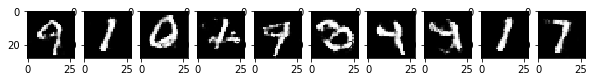

Epochs 7/10: Generator Loss: 0.444. Discriminator Loss: 0.148


Epochs 7/10: Generator Loss: 0.426. Discriminator Loss: 0.215


Epochs 7/10: Generator Loss: 0.472. Discriminator Loss: 0.224


Epochs 7/10: Generator Loss: 0.415. Discriminator Loss: 0.274


Epochs 7/10: Generator Loss: 0.444. Discriminator Loss: 0.241


Epochs 7/10: Generator Loss: 0.465. Discriminator Loss: 0.194


Epochs 7/10: Generator Loss: 0.433. Discriminator Loss: 0.177


Epochs 7/10: Generator Loss: 0.446. Discriminator Loss: 0.231


Epochs 7/10: Generator Loss: 0.422. Discriminator Loss: 0.231


Epochs 7/10: Generator Loss: 0.453. Discriminator Loss: 0.229


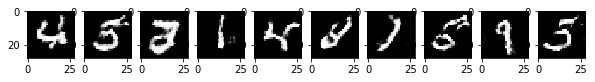

Epochs 7/10: Generator Loss: 0.474. Discriminator Loss: 0.253


Epochs 7/10: Generator Loss: 0.444. Discriminator Loss: 0.203


Epochs 7/10: Generator Loss: 0.452. Discriminator Loss: 0.196


Epochs 7/10: Generator Loss: 0.457. Discriminator Loss: 0.192


Epochs 7/10: Generator Loss: 0.488. Discriminator Loss: 0.222


Epochs 7/10: Generator Loss: 0.468. Discriminator Loss: 0.236


Epochs 7/10: Generator Loss: 0.459. Discriminator Loss: 0.248


Epochs 7/10: Generator Loss: 0.431. Discriminator Loss: 0.22


Epochs 7/10: Generator Loss: 0.4. Discriminator Loss: 0.248


Epochs 7/10: Generator Loss: 0.467. Discriminator Loss: 0.22


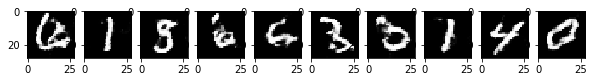

Epochs 7/10: Generator Loss: 0.495. Discriminator Loss: 0.235


Epochs 7/10: Generator Loss: 0.45. Discriminator Loss: 0.252


Epochs 7/10: Generator Loss: 0.451. Discriminator Loss: 0.212


Epochs 7/10: Generator Loss: 0.486. Discriminator Loss: 0.19


Epochs 7/10: Generator Loss: 0.446. Discriminator Loss: 0.22


Epochs 7/10: Generator Loss: 0.467. Discriminator Loss: 0.226


Epochs 7/10: Generator Loss: 0.451. Discriminator Loss: 0.214


Epochs 7/10: Generator Loss: 0.468. Discriminator Loss: 0.186


Epochs 7/10: Generator Loss: 0.424. Discriminator Loss: 0.195


Epochs 7/10: Generator Loss: 0.464. Discriminator Loss: 0.193


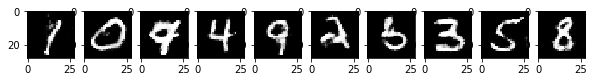

Epochs 7/10: Generator Loss: 0.482. Discriminator Loss: 0.159


Epochs 7/10: Generator Loss: 0.488. Discriminator Loss: 0.141


Epochs 7/10: Generator Loss: 0.443. Discriminator Loss: 0.218


Epochs 7/10: Generator Loss: 0.476. Discriminator Loss: 0.239


Epochs 7/10: Generator Loss: 0.463. Discriminator Loss: 0.242


Epochs 7/10: Generator Loss: 0.433. Discriminator Loss: 0.202


Epochs 7/10: Generator Loss: 0.486. Discriminator Loss: 0.144


Epochs 7/10: Generator Loss: 0.456. Discriminator Loss: 0.148


Epochs 7/10: Generator Loss: 0.405. Discriminator Loss: 0.219


Epochs 7/10: Generator Loss: 0.487. Discriminator Loss: 0.224


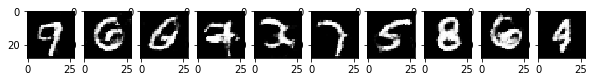

Epochs 7/10: Generator Loss: 0.473. Discriminator Loss: 0.19


Epochs 7/10: Generator Loss: 0.487. Discriminator Loss: 0.189


Epochs 7/10: Generator Loss: 0.461. Discriminator Loss: 0.236


Epochs 7/10: Generator Loss: 0.485. Discriminator Loss: 0.236


Epochs 7/10: Generator Loss: 0.46. Discriminator Loss: 0.224


Epochs 7/10: Generator Loss: 0.462. Discriminator Loss: 0.186


Epochs 7/10: Generator Loss: 0.439. Discriminator Loss: 0.205


Epochs 7/10: Generator Loss: 0.481. Discriminator Loss: 0.22


Epochs 7/10: Generator Loss: 0.465. Discriminator Loss: 0.207


Epochs 7/10: Generator Loss: 0.489. Discriminator Loss: 0.235


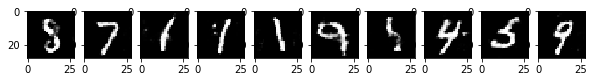

Epochs 7/10: Generator Loss: 0.464. Discriminator Loss: 0.24


Epochs 7/10: Generator Loss: 0.465. Discriminator Loss: 0.195


Epochs 7/10: Generator Loss: 0.423. Discriminator Loss: 0.238


Epochs 7/10: Generator Loss: 0.463. Discriminator Loss: 0.209


Epochs 7/10: Generator Loss: 0.428. Discriminator Loss: 0.186


Epochs 7/10: Generator Loss: 0.43. Discriminator Loss: 0.14


Epochs 7/10: Generator Loss: 0.458. Discriminator Loss: 0.171


Epochs 7/10: Generator Loss: 0.459. Discriminator Loss: 0.223


Epochs 7/10: Generator Loss: 0.467. Discriminator Loss: 0.194


Epochs 7/10: Generator Loss: 0.458. Discriminator Loss: 0.185


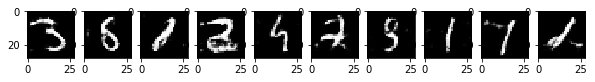

Epochs 7/10: Generator Loss: 0.456. Discriminator Loss: 0.168


Epochs 7/10: Generator Loss: 0.491. Discriminator Loss: 0.22


Epochs 7/10: Generator Loss: 0.454. Discriminator Loss: 0.221


Epochs 7/10: Generator Loss: 0.469. Discriminator Loss: 0.243


Epochs 7/10: Generator Loss: 0.442. Discriminator Loss: 0.271


Epochs 7/10: Generator Loss: 0.47. Discriminator Loss: 0.237


Epochs 7/10: Generator Loss: 0.448. Discriminator Loss: 0.257


Epochs 7/10: Generator Loss: 0.431. Discriminator Loss: 0.237


Epochs 7/10: Generator Loss: 0.431. Discriminator Loss: 0.196


Epochs 7/10: Generator Loss: 0.487. Discriminator Loss: 0.204


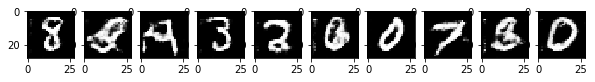

Epochs 7/10: Generator Loss: 0.484. Discriminator Loss: 0.221


Epochs 7/10: Generator Loss: 0.469. Discriminator Loss: 0.278


Epochs 7/10: Generator Loss: 0.438. Discriminator Loss: 0.27


Epochs 7/10: Generator Loss: 0.474. Discriminator Loss: 0.243


Epochs 7/10: Generator Loss: 0.464. Discriminator Loss: 0.228


Epochs 7/10: Generator Loss: 0.469. Discriminator Loss: 0.241


Epochs 7/10: Generator Loss: 0.449. Discriminator Loss: 0.259


Epochs 7/10: Generator Loss: 0.48. Discriminator Loss: 0.206


Epochs 7/10: Generator Loss: 0.461. Discriminator Loss: 0.206


Epochs 7/10: Generator Loss: 0.472. Discriminator Loss: 0.212


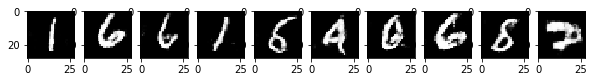

Epochs 7/10: Generator Loss: 0.43. Discriminator Loss: 0.223


Epochs 7/10: Generator Loss: 0.465. Discriminator Loss: 0.192


Epochs 7/10: Generator Loss: 0.458. Discriminator Loss: 0.181


Epochs 7/10: Generator Loss: 0.445. Discriminator Loss: 0.155


Epochs 7/10: Generator Loss: 0.481. Discriminator Loss: 0.144


Epochs 7/10: Generator Loss: 0.451. Discriminator Loss: 0.181


Epochs 7/10: Generator Loss: 0.45. Discriminator Loss: 0.207


Epochs 7/10: Generator Loss: 0.471. Discriminator Loss: 0.188


Epochs 7/10: Generator Loss: 0.43. Discriminator Loss: 0.171


Epochs 7/10: Generator Loss: 0.494. Discriminator Loss: 0.157


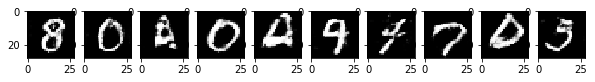

Epochs 7/10: Generator Loss: 0.453. Discriminator Loss: 0.196


Epochs 7/10: Generator Loss: 0.449. Discriminator Loss: 0.212


Epochs 7/10: Generator Loss: 0.491. Discriminator Loss: 0.188


Epochs 7/10: Generator Loss: 0.488. Discriminator Loss: 0.173


Epochs 7/10: Generator Loss: 0.477. Discriminator Loss: 0.207


Epochs 7/10: Generator Loss: 0.488. Discriminator Loss: 0.196


Epochs 7/10: Generator Loss: 0.446. Discriminator Loss: 0.183


Epochs 7/10: Generator Loss: 0.435. Discriminator Loss: 0.193


Epochs 7/10: Generator Loss: 0.443. Discriminator Loss: 0.23


Epochs 7/10: Generator Loss: 0.46. Discriminator Loss: 0.203


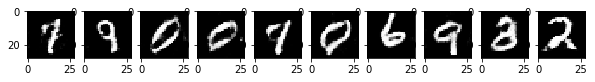

Epochs 7/10: Generator Loss: 0.455. Discriminator Loss: 0.173


Epochs 7/10: Generator Loss: 0.462. Discriminator Loss: 0.141


Epochs 7/10: Generator Loss: 0.422. Discriminator Loss: 0.17


Epochs 7/10: Generator Loss: 0.413. Discriminator Loss: 0.184


Epochs 7/10: Generator Loss: 0.466. Discriminator Loss: 0.231


Epochs 7/10: Generator Loss: 0.49. Discriminator Loss: 0.227


Epochs 7/10: Generator Loss: 0.459. Discriminator Loss: 0.248


Epochs 7/10: Generator Loss: 0.444. Discriminator Loss: 0.237


Epochs 7/10: Generator Loss: 0.438. Discriminator Loss: 0.237


Epochs 7/10: Generator Loss: 0.464. Discriminator Loss: 0.276


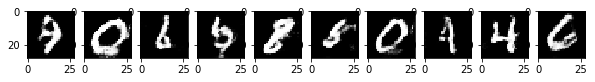

Epochs 7/10: Generator Loss: 0.497. Discriminator Loss: 0.219


Epochs 7/10: Generator Loss: 0.469. Discriminator Loss: 0.176


Epochs 7/10: Generator Loss: 0.47. Discriminator Loss: 0.161


Epochs 7/10: Generator Loss: 0.423. Discriminator Loss: 0.179


Epochs 7/10: Generator Loss: 0.453. Discriminator Loss: 0.157


Epochs 7/10: Generator Loss: 0.475. Discriminator Loss: 0.193


Epochs 7/10: Generator Loss: 0.443. Discriminator Loss: 0.202


Epochs 7/10: Generator Loss: 0.485. Discriminator Loss: 0.205


Epochs 7/10: Generator Loss: 0.479. Discriminator Loss: 0.176


Epochs 7/10: Generator Loss: 0.428. Discriminator Loss: 0.205


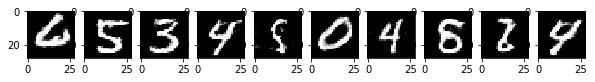

Epochs 7/10: Generator Loss: 0.47. Discriminator Loss: 0.225


Epochs 7/10: Generator Loss: 0.481. Discriminator Loss: 0.21


Epochs 7/10: Generator Loss: 0.466. Discriminator Loss: 0.165


Epochs 7/10: Generator Loss: 0.45. Discriminator Loss: 0.185


Epochs 7/10: Generator Loss: 0.458. Discriminator Loss: 0.18


Epochs 7/10: Generator Loss: 0.494. Discriminator Loss: 0.235


Epochs 7/10: Generator Loss: 0.442. Discriminator Loss: 0.25


Epochs 7/10: Generator Loss: 0.451. Discriminator Loss: 0.237


Epochs 7/10: Generator Loss: 0.463. Discriminator Loss: 0.182


Epochs 7/10: Generator Loss: 0.464. Discriminator Loss: 0.197


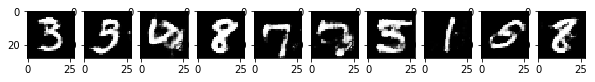

Epochs 7/10: Generator Loss: 0.497. Discriminator Loss: 0.229


Epochs 7/10: Generator Loss: 0.471. Discriminator Loss: 0.234


Epochs 7/10: Generator Loss: 0.467. Discriminator Loss: 0.236


Epochs 7/10: Generator Loss: 0.457. Discriminator Loss: 0.226


Epochs 7/10: Generator Loss: 0.481. Discriminator Loss: 0.28


Epochs 7/10: Generator Loss: 0.462. Discriminator Loss: 0.259


Epochs 7/10: Generator Loss: 0.493. Discriminator Loss: 0.266


Epochs 7/10: Generator Loss: 0.461. Discriminator Loss: 0.226


Epochs 7/10: Generator Loss: 0.467. Discriminator Loss: 0.239


Epochs 7/10: Generator Loss: 0.471. Discriminator Loss: 0.267


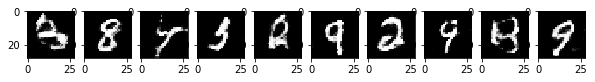

Epochs 7/10: Generator Loss: 0.474. Discriminator Loss: 0.238


Epochs 7/10: Generator Loss: 0.48. Discriminator Loss: 0.254


Epochs 7/10: Generator Loss: 0.49. Discriminator Loss: 0.189


Epochs 7/10: Generator Loss: 0.47. Discriminator Loss: 0.225


Epochs 7/10: Generator Loss: 0.476. Discriminator Loss: 0.258


Epochs 7/10: Generator Loss: 0.472. Discriminator Loss: 0.303


Epochs 7/10: Generator Loss: 0.465. Discriminator Loss: 0.3


Epochs 7/10: Generator Loss: 0.467. Discriminator Loss: 0.275


Epochs 7/10: Generator Loss: 0.486. Discriminator Loss: 0.238


Epochs 7/10: Generator Loss: 0.467. Discriminator Loss: 0.259


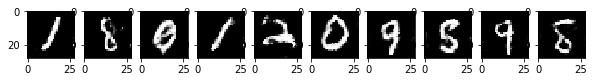

Epochs 7/10: Generator Loss: 0.462. Discriminator Loss: 0.251


Epochs 7/10: Generator Loss: 0.48. Discriminator Loss: 0.247


Epochs 7/10: Generator Loss: 0.452. Discriminator Loss: 0.226


Epochs 7/10: Generator Loss: 0.452. Discriminator Loss: 0.237


Epochs 7/10: Generator Loss: 0.453. Discriminator Loss: 0.221


Epochs 7/10: Generator Loss: 0.455. Discriminator Loss: 0.185


Epochs 7/10: Generator Loss: 0.477. Discriminator Loss: 0.184


Epochs 7/10: Generator Loss: 0.453. Discriminator Loss: 0.181


Epochs 7/10: Generator Loss: 0.446. Discriminator Loss: 0.228


Epochs 8/10: Generator Loss: 0.369. Discriminator Loss: 0.387


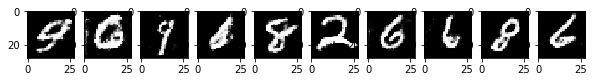

Epochs 8/10: Generator Loss: 0.493. Discriminator Loss: 0.219


Epochs 8/10: Generator Loss: 0.461. Discriminator Loss: 0.193


Epochs 8/10: Generator Loss: 0.446. Discriminator Loss: 0.182


Epochs 8/10: Generator Loss: 0.444. Discriminator Loss: 0.18


Epochs 8/10: Generator Loss: 0.477. Discriminator Loss: 0.209


Epochs 8/10: Generator Loss: 0.466. Discriminator Loss: 0.244


Epochs 8/10: Generator Loss: 0.463. Discriminator Loss: 0.251


Epochs 8/10: Generator Loss: 0.406. Discriminator Loss: 0.255


Epochs 8/10: Generator Loss: 0.441. Discriminator Loss: 0.189


Epochs 8/10: Generator Loss: 0.44. Discriminator Loss: 0.17


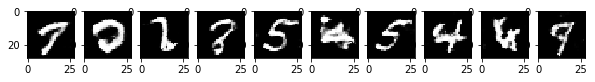

Epochs 8/10: Generator Loss: 0.455. Discriminator Loss: 0.202


Epochs 8/10: Generator Loss: 0.473. Discriminator Loss: 0.22


Epochs 8/10: Generator Loss: 0.466. Discriminator Loss: 0.243


Epochs 8/10: Generator Loss: 0.456. Discriminator Loss: 0.186


Epochs 8/10: Generator Loss: 0.443. Discriminator Loss: 0.209


Epochs 8/10: Generator Loss: 0.466. Discriminator Loss: 0.179


Epochs 8/10: Generator Loss: 0.462. Discriminator Loss: 0.205


Epochs 8/10: Generator Loss: 0.459. Discriminator Loss: 0.204


Epochs 8/10: Generator Loss: 0.476. Discriminator Loss: 0.214


Epochs 8/10: Generator Loss: 0.459. Discriminator Loss: 0.206


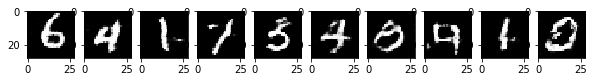

Epochs 8/10: Generator Loss: 0.477. Discriminator Loss: 0.206


Epochs 8/10: Generator Loss: 0.474. Discriminator Loss: 0.224


Epochs 8/10: Generator Loss: 0.48. Discriminator Loss: 0.205


Epochs 8/10: Generator Loss: 0.464. Discriminator Loss: 0.228


Epochs 8/10: Generator Loss: 0.494. Discriminator Loss: 0.188


Epochs 8/10: Generator Loss: 0.467. Discriminator Loss: 0.192


Epochs 8/10: Generator Loss: 0.47. Discriminator Loss: 0.167


Epochs 8/10: Generator Loss: 0.456. Discriminator Loss: 0.15


Epochs 8/10: Generator Loss: 0.457. Discriminator Loss: 0.13


Epochs 8/10: Generator Loss: 0.462. Discriminator Loss: 0.212


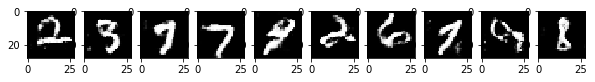

Epochs 8/10: Generator Loss: 0.48. Discriminator Loss: 0.251


Epochs 8/10: Generator Loss: 0.459. Discriminator Loss: 0.27


Epochs 8/10: Generator Loss: 0.468. Discriminator Loss: 0.192


Epochs 8/10: Generator Loss: 0.456. Discriminator Loss: 0.199


Epochs 8/10: Generator Loss: 0.475. Discriminator Loss: 0.207


Epochs 8/10: Generator Loss: 0.466. Discriminator Loss: 0.23


Epochs 8/10: Generator Loss: 0.452. Discriminator Loss: 0.239


Epochs 8/10: Generator Loss: 0.406. Discriminator Loss: 0.262


Epochs 8/10: Generator Loss: 0.477. Discriminator Loss: 0.221


Epochs 8/10: Generator Loss: 0.436. Discriminator Loss: 0.184


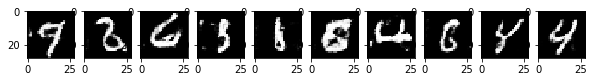

Epochs 8/10: Generator Loss: 0.49. Discriminator Loss: 0.157


Epochs 8/10: Generator Loss: 0.44. Discriminator Loss: 0.213


Epochs 8/10: Generator Loss: 0.473. Discriminator Loss: 0.237


Epochs 8/10: Generator Loss: 0.455. Discriminator Loss: 0.25


Epochs 8/10: Generator Loss: 0.48. Discriminator Loss: 0.223


Epochs 8/10: Generator Loss: 0.484. Discriminator Loss: 0.224


Epochs 8/10: Generator Loss: 0.461. Discriminator Loss: 0.2


Epochs 8/10: Generator Loss: 0.475. Discriminator Loss: 0.191


Epochs 8/10: Generator Loss: 0.481. Discriminator Loss: 0.222


Epochs 8/10: Generator Loss: 0.465. Discriminator Loss: 0.222


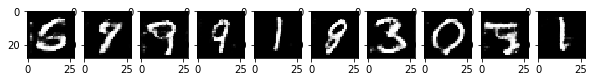

Epochs 8/10: Generator Loss: 0.482. Discriminator Loss: 0.229


Epochs 8/10: Generator Loss: 0.479. Discriminator Loss: 0.19


Epochs 8/10: Generator Loss: 0.472. Discriminator Loss: 0.194


Epochs 8/10: Generator Loss: 0.461. Discriminator Loss: 0.18


Epochs 8/10: Generator Loss: 0.459. Discriminator Loss: 0.18


Epochs 8/10: Generator Loss: 0.484. Discriminator Loss: 0.193


Epochs 8/10: Generator Loss: 0.478. Discriminator Loss: 0.178


Epochs 8/10: Generator Loss: 0.442. Discriminator Loss: 0.176


Epochs 8/10: Generator Loss: 0.426. Discriminator Loss: 0.164


Epochs 8/10: Generator Loss: 0.447. Discriminator Loss: 0.213


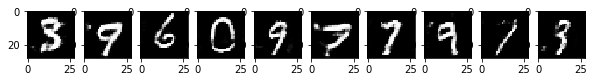

Epochs 8/10: Generator Loss: 0.467. Discriminator Loss: 0.194


Epochs 8/10: Generator Loss: 0.454. Discriminator Loss: 0.267


Epochs 8/10: Generator Loss: 0.478. Discriminator Loss: 0.252


Epochs 8/10: Generator Loss: 0.469. Discriminator Loss: 0.148


Epochs 8/10: Generator Loss: 0.446. Discriminator Loss: 0.15


Epochs 8/10: Generator Loss: 0.453. Discriminator Loss: 0.166


Epochs 8/10: Generator Loss: 0.464. Discriminator Loss: 0.211


Epochs 8/10: Generator Loss: 0.462. Discriminator Loss: 0.21


Epochs 8/10: Generator Loss: 0.438. Discriminator Loss: 0.238


Epochs 8/10: Generator Loss: 0.427. Discriminator Loss: 0.233


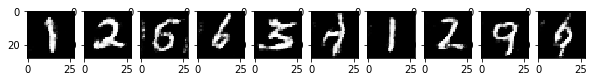

Epochs 8/10: Generator Loss: 0.473. Discriminator Loss: 0.222


Epochs 8/10: Generator Loss: 0.472. Discriminator Loss: 0.223


Epochs 8/10: Generator Loss: 0.425. Discriminator Loss: 0.224


Epochs 8/10: Generator Loss: 0.483. Discriminator Loss: 0.175


Epochs 8/10: Generator Loss: 0.473. Discriminator Loss: 0.235


Epochs 8/10: Generator Loss: 0.467. Discriminator Loss: 0.226


Epochs 8/10: Generator Loss: 0.484. Discriminator Loss: 0.238


Epochs 8/10: Generator Loss: 0.454. Discriminator Loss: 0.264


Epochs 8/10: Generator Loss: 0.458. Discriminator Loss: 0.245


Epochs 8/10: Generator Loss: 0.425. Discriminator Loss: 0.231


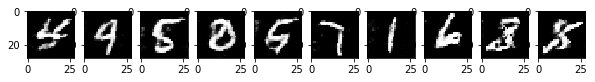

Epochs 8/10: Generator Loss: 0.43. Discriminator Loss: 0.237


Epochs 8/10: Generator Loss: 0.479. Discriminator Loss: 0.175


Epochs 8/10: Generator Loss: 0.462. Discriminator Loss: 0.161


Epochs 8/10: Generator Loss: 0.434. Discriminator Loss: 0.164


Epochs 8/10: Generator Loss: 0.482. Discriminator Loss: 0.174


Epochs 8/10: Generator Loss: 0.469. Discriminator Loss: 0.194


Epochs 8/10: Generator Loss: 0.47. Discriminator Loss: 0.168


Epochs 8/10: Generator Loss: 0.478. Discriminator Loss: 0.158


Epochs 8/10: Generator Loss: 0.466. Discriminator Loss: 0.18


Epochs 8/10: Generator Loss: 0.482. Discriminator Loss: 0.208


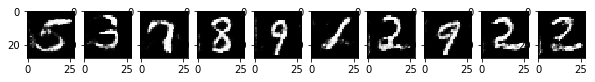

Epochs 8/10: Generator Loss: 0.438. Discriminator Loss: 0.259


Epochs 8/10: Generator Loss: 0.464. Discriminator Loss: 0.24


Epochs 8/10: Generator Loss: 0.439. Discriminator Loss: 0.23


Epochs 8/10: Generator Loss: 0.464. Discriminator Loss: 0.225


Epochs 8/10: Generator Loss: 0.447. Discriminator Loss: 0.214


Epochs 8/10: Generator Loss: 0.491. Discriminator Loss: 0.188


Epochs 8/10: Generator Loss: 0.42. Discriminator Loss: 0.243


Epochs 8/10: Generator Loss: 0.475. Discriminator Loss: 0.237


Epochs 8/10: Generator Loss: 0.445. Discriminator Loss: 0.255


Epochs 8/10: Generator Loss: 0.475. Discriminator Loss: 0.283


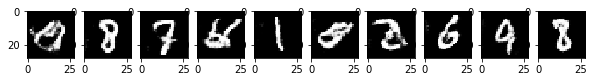

Epochs 8/10: Generator Loss: 0.442. Discriminator Loss: 0.233


Epochs 8/10: Generator Loss: 0.469. Discriminator Loss: 0.274


Epochs 8/10: Generator Loss: 0.479. Discriminator Loss: 0.231


Epochs 8/10: Generator Loss: 0.466. Discriminator Loss: 0.242


Epochs 8/10: Generator Loss: 0.453. Discriminator Loss: 0.184


Epochs 8/10: Generator Loss: 0.439. Discriminator Loss: 0.195


Epochs 8/10: Generator Loss: 0.457. Discriminator Loss: 0.182


Epochs 8/10: Generator Loss: 0.463. Discriminator Loss: 0.201


Epochs 8/10: Generator Loss: 0.432. Discriminator Loss: 0.208


Epochs 8/10: Generator Loss: 0.486. Discriminator Loss: 0.19


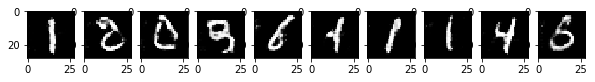

Epochs 8/10: Generator Loss: 0.445. Discriminator Loss: 0.167


Epochs 8/10: Generator Loss: 0.425. Discriminator Loss: 0.147


Epochs 8/10: Generator Loss: 0.443. Discriminator Loss: 0.145


Epochs 8/10: Generator Loss: 0.455. Discriminator Loss: 0.19


Epochs 8/10: Generator Loss: 0.478. Discriminator Loss: 0.209


Epochs 8/10: Generator Loss: 0.463. Discriminator Loss: 0.222


Epochs 8/10: Generator Loss: 0.468. Discriminator Loss: 0.161


Epochs 8/10: Generator Loss: 0.441. Discriminator Loss: 0.197


Epochs 8/10: Generator Loss: 0.459. Discriminator Loss: 0.201


Epochs 8/10: Generator Loss: 0.493. Discriminator Loss: 0.203


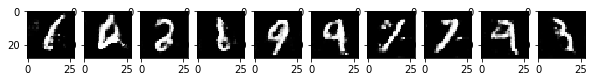

Epochs 8/10: Generator Loss: 0.49. Discriminator Loss: 0.159


Epochs 8/10: Generator Loss: 0.482. Discriminator Loss: 0.176


Epochs 8/10: Generator Loss: 0.48. Discriminator Loss: 0.161


Epochs 8/10: Generator Loss: 0.476. Discriminator Loss: 0.144


Epochs 8/10: Generator Loss: 0.455. Discriminator Loss: 0.123


Epochs 8/10: Generator Loss: 0.478. Discriminator Loss: 0.207


Epochs 8/10: Generator Loss: 0.455. Discriminator Loss: 0.221


Epochs 8/10: Generator Loss: 0.475. Discriminator Loss: 0.194


Epochs 8/10: Generator Loss: 0.474. Discriminator Loss: 0.148


Epochs 8/10: Generator Loss: 0.461. Discriminator Loss: 0.181


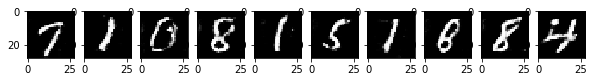

Epochs 8/10: Generator Loss: 0.434. Discriminator Loss: 0.167


Epochs 8/10: Generator Loss: 0.494. Discriminator Loss: 0.188


Epochs 8/10: Generator Loss: 0.411. Discriminator Loss: 0.265


Epochs 8/10: Generator Loss: 0.444. Discriminator Loss: 0.249


Epochs 8/10: Generator Loss: 0.486. Discriminator Loss: 0.238


Epochs 8/10: Generator Loss: 0.48. Discriminator Loss: 0.247


Epochs 8/10: Generator Loss: 0.496. Discriminator Loss: 0.253


Epochs 8/10: Generator Loss: 0.479. Discriminator Loss: 0.259


Epochs 8/10: Generator Loss: 0.46. Discriminator Loss: 0.236


Epochs 8/10: Generator Loss: 0.422. Discriminator Loss: 0.197


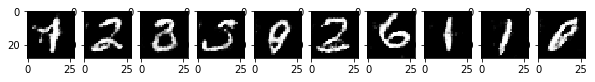

Epochs 8/10: Generator Loss: 0.475. Discriminator Loss: 0.174


Epochs 8/10: Generator Loss: 0.425. Discriminator Loss: 0.179


Epochs 8/10: Generator Loss: 0.481. Discriminator Loss: 0.18


Epochs 8/10: Generator Loss: 0.464. Discriminator Loss: 0.216


Epochs 8/10: Generator Loss: 0.47. Discriminator Loss: 0.162


Epochs 8/10: Generator Loss: 0.456. Discriminator Loss: 0.163


Epochs 8/10: Generator Loss: 0.495. Discriminator Loss: 0.189


Epochs 8/10: Generator Loss: 0.481. Discriminator Loss: 0.21


Epochs 8/10: Generator Loss: 0.456. Discriminator Loss: 0.241


Epochs 8/10: Generator Loss: 0.466. Discriminator Loss: 0.195


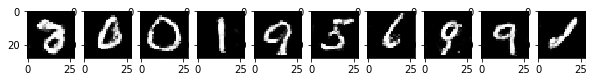

Epochs 8/10: Generator Loss: 0.438. Discriminator Loss: 0.136


Epochs 8/10: Generator Loss: 0.452. Discriminator Loss: 0.179


Epochs 8/10: Generator Loss: 0.424. Discriminator Loss: 0.23


Epochs 8/10: Generator Loss: 0.477. Discriminator Loss: 0.229


Epochs 8/10: Generator Loss: 0.491. Discriminator Loss: 0.219


Epochs 8/10: Generator Loss: 0.489. Discriminator Loss: 0.189


Epochs 8/10: Generator Loss: 0.495. Discriminator Loss: 0.188


Epochs 8/10: Generator Loss: 0.463. Discriminator Loss: 0.21


Epochs 8/10: Generator Loss: 0.467. Discriminator Loss: 0.211


Epochs 8/10: Generator Loss: 0.48. Discriminator Loss: 0.237


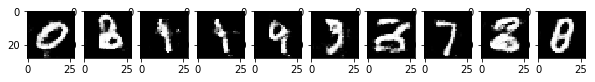

Epochs 8/10: Generator Loss: 0.461. Discriminator Loss: 0.222


Epochs 8/10: Generator Loss: 0.461. Discriminator Loss: 0.26


Epochs 8/10: Generator Loss: 0.482. Discriminator Loss: 0.219


Epochs 8/10: Generator Loss: 0.418. Discriminator Loss: 0.236


Epochs 8/10: Generator Loss: 0.415. Discriminator Loss: 0.233


Epochs 8/10: Generator Loss: 0.485. Discriminator Loss: 0.205


Epochs 8/10: Generator Loss: 0.477. Discriminator Loss: 0.234


Epochs 8/10: Generator Loss: 0.458. Discriminator Loss: 0.285


Epochs 8/10: Generator Loss: 0.472. Discriminator Loss: 0.26


Epochs 8/10: Generator Loss: 0.479. Discriminator Loss: 0.206


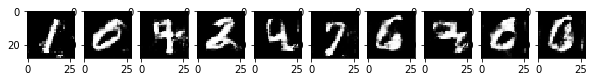

Epochs 8/10: Generator Loss: 0.44. Discriminator Loss: 0.222


Epochs 8/10: Generator Loss: 0.482. Discriminator Loss: 0.207


Epochs 8/10: Generator Loss: 0.445. Discriminator Loss: 0.264


Epochs 8/10: Generator Loss: 0.485. Discriminator Loss: 0.283


Epochs 8/10: Generator Loss: 0.481. Discriminator Loss: 0.284


Epochs 8/10: Generator Loss: 0.39. Discriminator Loss: 0.3


Epochs 8/10: Generator Loss: 0.47. Discriminator Loss: 0.26


Epochs 8/10: Generator Loss: 0.449. Discriminator Loss: 0.244


Epochs 8/10: Generator Loss: 0.446. Discriminator Loss: 0.23


Epochs 8/10: Generator Loss: 0.481. Discriminator Loss: 0.223


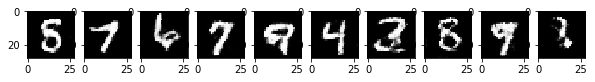

Epochs 8/10: Generator Loss: 0.461. Discriminator Loss: 0.227


Epochs 8/10: Generator Loss: 0.492. Discriminator Loss: 0.204


Epochs 8/10: Generator Loss: 0.454. Discriminator Loss: 0.212


Epochs 8/10: Generator Loss: 0.483. Discriminator Loss: 0.174


Epochs 8/10: Generator Loss: 0.461. Discriminator Loss: 0.198


Epochs 8/10: Generator Loss: 0.47. Discriminator Loss: 0.222


Epochs 8/10: Generator Loss: 0.464. Discriminator Loss: 0.226


Epochs 9/10: Generator Loss: 0.435. Discriminator Loss: 0.241


Epochs 9/10: Generator Loss: 0.472. Discriminator Loss: 0.175


Epochs 9/10: Generator Loss: 0.45. Discriminator Loss: 0.189


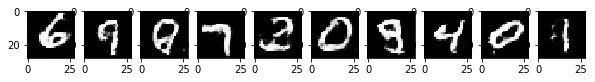

Epochs 9/10: Generator Loss: 0.427. Discriminator Loss: 0.216


Epochs 9/10: Generator Loss: 0.433. Discriminator Loss: 0.202


Epochs 9/10: Generator Loss: 0.49. Discriminator Loss: 0.235


Epochs 9/10: Generator Loss: 0.459. Discriminator Loss: 0.248


Epochs 9/10: Generator Loss: 0.488. Discriminator Loss: 0.267


Epochs 9/10: Generator Loss: 0.476. Discriminator Loss: 0.212


Epochs 9/10: Generator Loss: 0.467. Discriminator Loss: 0.182


Epochs 9/10: Generator Loss: 0.494. Discriminator Loss: 0.188


Epochs 9/10: Generator Loss: 0.482. Discriminator Loss: 0.194


Epochs 9/10: Generator Loss: 0.467. Discriminator Loss: 0.243


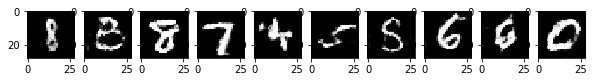

Epochs 9/10: Generator Loss: 0.466. Discriminator Loss: 0.217


Epochs 9/10: Generator Loss: 0.47. Discriminator Loss: 0.186


Epochs 9/10: Generator Loss: 0.442. Discriminator Loss: 0.175


Epochs 9/10: Generator Loss: 0.472. Discriminator Loss: 0.195


Epochs 9/10: Generator Loss: 0.438. Discriminator Loss: 0.232


Epochs 9/10: Generator Loss: 0.436. Discriminator Loss: 0.21


Epochs 9/10: Generator Loss: 0.493. Discriminator Loss: 0.189


Epochs 9/10: Generator Loss: 0.484. Discriminator Loss: 0.206


Epochs 9/10: Generator Loss: 0.46. Discriminator Loss: 0.243


Epochs 9/10: Generator Loss: 0.492. Discriminator Loss: 0.22


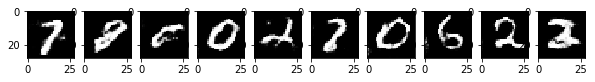

Epochs 9/10: Generator Loss: 0.444. Discriminator Loss: 0.184


Epochs 9/10: Generator Loss: 0.469. Discriminator Loss: 0.198


Epochs 9/10: Generator Loss: 0.481. Discriminator Loss: 0.192


Epochs 9/10: Generator Loss: 0.455. Discriminator Loss: 0.169


Epochs 9/10: Generator Loss: 0.447. Discriminator Loss: 0.102


Epochs 9/10: Generator Loss: 0.441. Discriminator Loss: 0.144


Epochs 9/10: Generator Loss: 0.434. Discriminator Loss: 0.17


Epochs 9/10: Generator Loss: 0.441. Discriminator Loss: 0.23


Epochs 9/10: Generator Loss: 0.47. Discriminator Loss: 0.233


Epochs 9/10: Generator Loss: 0.46. Discriminator Loss: 0.202


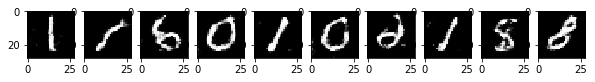

Epochs 9/10: Generator Loss: 0.481. Discriminator Loss: 0.205


Epochs 9/10: Generator Loss: 0.478. Discriminator Loss: 0.175


Epochs 9/10: Generator Loss: 0.447. Discriminator Loss: 0.235


Epochs 9/10: Generator Loss: 0.456. Discriminator Loss: 0.223


Epochs 9/10: Generator Loss: 0.439. Discriminator Loss: 0.247


Epochs 9/10: Generator Loss: 0.476. Discriminator Loss: 0.237


Epochs 9/10: Generator Loss: 0.447. Discriminator Loss: 0.21


Epochs 9/10: Generator Loss: 0.479. Discriminator Loss: 0.191


Epochs 9/10: Generator Loss: 0.445. Discriminator Loss: 0.204


Epochs 9/10: Generator Loss: 0.472. Discriminator Loss: 0.222


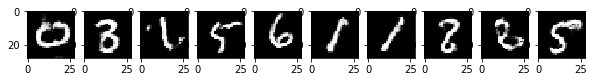

Epochs 9/10: Generator Loss: 0.479. Discriminator Loss: 0.22


Epochs 9/10: Generator Loss: 0.478. Discriminator Loss: 0.226


Epochs 9/10: Generator Loss: 0.449. Discriminator Loss: 0.206


Epochs 9/10: Generator Loss: 0.49. Discriminator Loss: 0.188


Epochs 9/10: Generator Loss: 0.469. Discriminator Loss: 0.214


Epochs 9/10: Generator Loss: 0.472. Discriminator Loss: 0.255


Epochs 9/10: Generator Loss: 0.458. Discriminator Loss: 0.226


Epochs 9/10: Generator Loss: 0.477. Discriminator Loss: 0.206


Epochs 9/10: Generator Loss: 0.433. Discriminator Loss: 0.209


Epochs 9/10: Generator Loss: 0.434. Discriminator Loss: 0.19


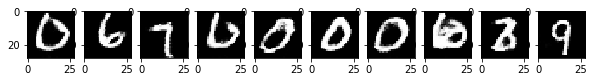

Epochs 9/10: Generator Loss: 0.461. Discriminator Loss: 0.196


Epochs 9/10: Generator Loss: 0.447. Discriminator Loss: 0.213


Epochs 9/10: Generator Loss: 0.494. Discriminator Loss: 0.204


Epochs 9/10: Generator Loss: 0.474. Discriminator Loss: 0.19


Epochs 9/10: Generator Loss: 0.457. Discriminator Loss: 0.186


Epochs 9/10: Generator Loss: 0.477. Discriminator Loss: 0.144


Epochs 9/10: Generator Loss: 0.487. Discriminator Loss: 0.142


Epochs 9/10: Generator Loss: 0.476. Discriminator Loss: 0.178


Epochs 9/10: Generator Loss: 0.481. Discriminator Loss: 0.226


Epochs 9/10: Generator Loss: 0.471. Discriminator Loss: 0.213


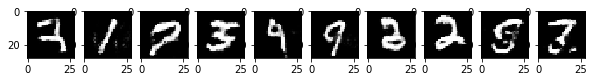

Epochs 9/10: Generator Loss: 0.45. Discriminator Loss: 0.191


Epochs 9/10: Generator Loss: 0.462. Discriminator Loss: 0.145


Epochs 9/10: Generator Loss: 0.475. Discriminator Loss: 0.173


Epochs 9/10: Generator Loss: 0.443. Discriminator Loss: 0.198


Epochs 9/10: Generator Loss: 0.471. Discriminator Loss: 0.242


Epochs 9/10: Generator Loss: 0.461. Discriminator Loss: 0.202


Epochs 9/10: Generator Loss: 0.441. Discriminator Loss: 0.194


Epochs 9/10: Generator Loss: 0.468. Discriminator Loss: 0.222


Epochs 9/10: Generator Loss: 0.458. Discriminator Loss: 0.247


Epochs 9/10: Generator Loss: 0.488. Discriminator Loss: 0.22


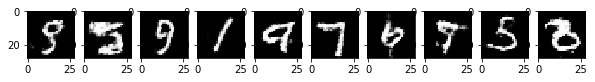

Epochs 9/10: Generator Loss: 0.468. Discriminator Loss: 0.18


Epochs 9/10: Generator Loss: 0.476. Discriminator Loss: 0.176


Epochs 9/10: Generator Loss: 0.491. Discriminator Loss: 0.204


Epochs 9/10: Generator Loss: 0.494. Discriminator Loss: 0.204


Epochs 9/10: Generator Loss: 0.428. Discriminator Loss: 0.252


Epochs 9/10: Generator Loss: 0.457. Discriminator Loss: 0.245


Epochs 9/10: Generator Loss: 0.443. Discriminator Loss: 0.2


Epochs 9/10: Generator Loss: 0.415. Discriminator Loss: 0.21


Epochs 9/10: Generator Loss: 0.447. Discriminator Loss: 0.217


Epochs 9/10: Generator Loss: 0.482. Discriminator Loss: 0.174


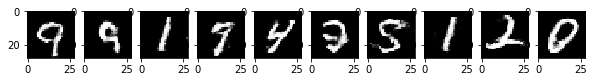

Epochs 9/10: Generator Loss: 0.479. Discriminator Loss: 0.127


Epochs 9/10: Generator Loss: 0.438. Discriminator Loss: 0.173


Epochs 9/10: Generator Loss: 0.449. Discriminator Loss: 0.189


Epochs 9/10: Generator Loss: 0.466. Discriminator Loss: 0.176


Epochs 9/10: Generator Loss: 0.464. Discriminator Loss: 0.18


Epochs 9/10: Generator Loss: 0.45. Discriminator Loss: 0.173


Epochs 9/10: Generator Loss: 0.459. Discriminator Loss: 0.231


Epochs 9/10: Generator Loss: 0.469. Discriminator Loss: 0.208


Epochs 9/10: Generator Loss: 0.472. Discriminator Loss: 0.237


Epochs 9/10: Generator Loss: 0.461. Discriminator Loss: 0.251


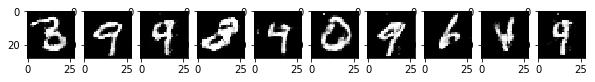

Epochs 9/10: Generator Loss: 0.479. Discriminator Loss: 0.236


Epochs 9/10: Generator Loss: 0.489. Discriminator Loss: 0.235


Epochs 9/10: Generator Loss: 0.487. Discriminator Loss: 0.22


Epochs 9/10: Generator Loss: 0.437. Discriminator Loss: 0.195


Epochs 9/10: Generator Loss: 0.492. Discriminator Loss: 0.204


Epochs 9/10: Generator Loss: 0.468. Discriminator Loss: 0.226


Epochs 9/10: Generator Loss: 0.469. Discriminator Loss: 0.278


Epochs 9/10: Generator Loss: 0.461. Discriminator Loss: 0.25


Epochs 9/10: Generator Loss: 0.488. Discriminator Loss: 0.235


Epochs 9/10: Generator Loss: 0.479. Discriminator Loss: 0.208


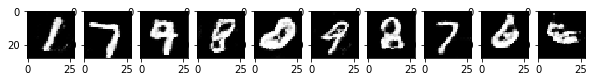

Epochs 9/10: Generator Loss: 0.464. Discriminator Loss: 0.243


Epochs 9/10: Generator Loss: 0.484. Discriminator Loss: 0.225


Epochs 9/10: Generator Loss: 0.474. Discriminator Loss: 0.191


Epochs 9/10: Generator Loss: 0.48. Discriminator Loss: 0.19


Epochs 9/10: Generator Loss: 0.419. Discriminator Loss: 0.25


Epochs 9/10: Generator Loss: 0.46. Discriminator Loss: 0.21


Epochs 9/10: Generator Loss: 0.483. Discriminator Loss: 0.173


Epochs 9/10: Generator Loss: 0.484. Discriminator Loss: 0.174


Epochs 9/10: Generator Loss: 0.478. Discriminator Loss: 0.143


Epochs 9/10: Generator Loss: 0.469. Discriminator Loss: 0.145


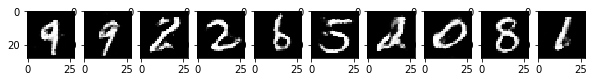

Epochs 9/10: Generator Loss: 0.468. Discriminator Loss: 0.177


Epochs 9/10: Generator Loss: 0.466. Discriminator Loss: 0.207


Epochs 9/10: Generator Loss: 0.474. Discriminator Loss: 0.205


Epochs 9/10: Generator Loss: 0.462. Discriminator Loss: 0.163


Epochs 9/10: Generator Loss: 0.482. Discriminator Loss: 0.174


Epochs 9/10: Generator Loss: 0.474. Discriminator Loss: 0.191


Epochs 9/10: Generator Loss: 0.465. Discriminator Loss: 0.206


Epochs 9/10: Generator Loss: 0.471. Discriminator Loss: 0.192


Epochs 9/10: Generator Loss: 0.465. Discriminator Loss: 0.163


Epochs 9/10: Generator Loss: 0.473. Discriminator Loss: 0.175


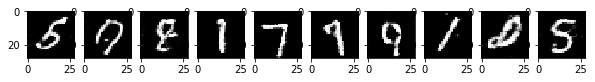

Epochs 9/10: Generator Loss: 0.39. Discriminator Loss: 0.224


Epochs 9/10: Generator Loss: 0.479. Discriminator Loss: 0.142


Epochs 9/10: Generator Loss: 0.49. Discriminator Loss: 0.157


Epochs 9/10: Generator Loss: 0.457. Discriminator Loss: 0.217


Epochs 9/10: Generator Loss: 0.484. Discriminator Loss: 0.194


Epochs 9/10: Generator Loss: 0.458. Discriminator Loss: 0.174


Epochs 9/10: Generator Loss: 0.467. Discriminator Loss: 0.139


Epochs 9/10: Generator Loss: 0.441. Discriminator Loss: 0.171


Epochs 9/10: Generator Loss: 0.481. Discriminator Loss: 0.139


Epochs 9/10: Generator Loss: 0.489. Discriminator Loss: 0.204


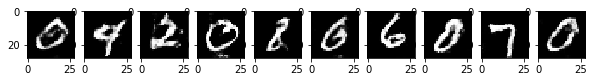

Epochs 9/10: Generator Loss: 0.484. Discriminator Loss: 0.22


Epochs 9/10: Generator Loss: 0.474. Discriminator Loss: 0.228


Epochs 9/10: Generator Loss: 0.462. Discriminator Loss: 0.247


Epochs 9/10: Generator Loss: 0.451. Discriminator Loss: 0.22


Epochs 9/10: Generator Loss: 0.445. Discriminator Loss: 0.264


Epochs 9/10: Generator Loss: 0.471. Discriminator Loss: 0.228


Epochs 9/10: Generator Loss: 0.463. Discriminator Loss: 0.197


Epochs 9/10: Generator Loss: 0.491. Discriminator Loss: 0.173


Epochs 9/10: Generator Loss: 0.463. Discriminator Loss: 0.16


Epochs 9/10: Generator Loss: 0.467. Discriminator Loss: 0.151


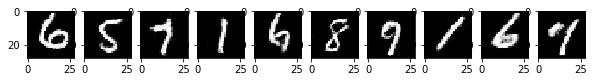

Epochs 9/10: Generator Loss: 0.447. Discriminator Loss: 0.168


Epochs 9/10: Generator Loss: 0.416. Discriminator Loss: 0.182


Epochs 9/10: Generator Loss: 0.483. Discriminator Loss: 0.174


Epochs 9/10: Generator Loss: 0.453. Discriminator Loss: 0.149


Epochs 9/10: Generator Loss: 0.482. Discriminator Loss: 0.175


Epochs 9/10: Generator Loss: 0.488. Discriminator Loss: 0.219


Epochs 9/10: Generator Loss: 0.471. Discriminator Loss: 0.206


Epochs 9/10: Generator Loss: 0.463. Discriminator Loss: 0.162


Epochs 9/10: Generator Loss: 0.444. Discriminator Loss: 0.158


Epochs 9/10: Generator Loss: 0.459. Discriminator Loss: 0.18


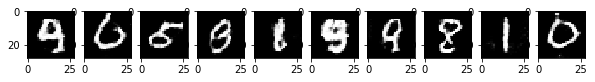

Epochs 9/10: Generator Loss: 0.493. Discriminator Loss: 0.219


Epochs 9/10: Generator Loss: 0.495. Discriminator Loss: 0.219


Epochs 9/10: Generator Loss: 0.484. Discriminator Loss: 0.189


Epochs 9/10: Generator Loss: 0.479. Discriminator Loss: 0.18


Epochs 9/10: Generator Loss: 0.486. Discriminator Loss: 0.189


Epochs 9/10: Generator Loss: 0.475. Discriminator Loss: 0.226


Epochs 9/10: Generator Loss: 0.486. Discriminator Loss: 0.224


Epochs 9/10: Generator Loss: 0.483. Discriminator Loss: 0.221


Epochs 9/10: Generator Loss: 0.491. Discriminator Loss: 0.219


Epochs 9/10: Generator Loss: 0.466. Discriminator Loss: 0.249


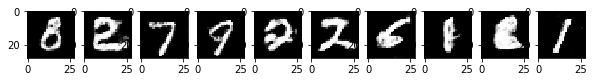

Epochs 9/10: Generator Loss: 0.494. Discriminator Loss: 0.204


Epochs 9/10: Generator Loss: 0.477. Discriminator Loss: 0.2


Epochs 9/10: Generator Loss: 0.442. Discriminator Loss: 0.205


Epochs 9/10: Generator Loss: 0.484. Discriminator Loss: 0.234


Epochs 9/10: Generator Loss: 0.499. Discriminator Loss: 0.235


Epochs 9/10: Generator Loss: 0.458. Discriminator Loss: 0.252


Epochs 9/10: Generator Loss: 0.489. Discriminator Loss: 0.25


Epochs 9/10: Generator Loss: 0.497. Discriminator Loss: 0.157


Epochs 9/10: Generator Loss: 0.488. Discriminator Loss: 0.173


Epochs 9/10: Generator Loss: 0.464. Discriminator Loss: 0.227


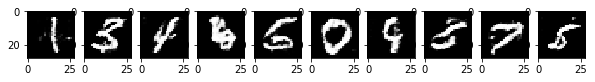

Epochs 9/10: Generator Loss: 0.492. Discriminator Loss: 0.282


Epochs 9/10: Generator Loss: 0.49. Discriminator Loss: 0.267


Epochs 9/10: Generator Loss: 0.469. Discriminator Loss: 0.259


Epochs 9/10: Generator Loss: 0.458. Discriminator Loss: 0.25


Epochs 9/10: Generator Loss: 0.461. Discriminator Loss: 0.268


Epochs 9/10: Generator Loss: 0.48. Discriminator Loss: 0.237


Epochs 9/10: Generator Loss: 0.485. Discriminator Loss: 0.238


Epochs 9/10: Generator Loss: 0.475. Discriminator Loss: 0.206


Epochs 9/10: Generator Loss: 0.481. Discriminator Loss: 0.229


Epochs 9/10: Generator Loss: 0.457. Discriminator Loss: 0.21


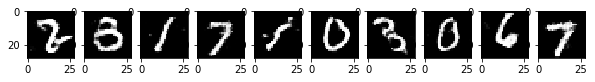

Epochs 9/10: Generator Loss: 0.442. Discriminator Loss: 0.181


Epochs 9/10: Generator Loss: 0.472. Discriminator Loss: 0.162


Epochs 9/10: Generator Loss: 0.41. Discriminator Loss: 0.207


Epochs 9/10: Generator Loss: 0.49. Discriminator Loss: 0.192


Epochs 10/10: Generator Loss: 0.357. Discriminator Loss: 0.331


Epochs 10/10: Generator Loss: 0.473. Discriminator Loss: 0.193


Epochs 10/10: Generator Loss: 0.483. Discriminator Loss: 0.189


Epochs 10/10: Generator Loss: 0.469. Discriminator Loss: 0.167


Epochs 10/10: Generator Loss: 0.48. Discriminator Loss: 0.191


Epochs 10/10: Generator Loss: 0.484. Discriminator Loss: 0.251


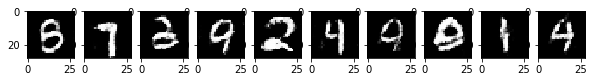

Epochs 10/10: Generator Loss: 0.496. Discriminator Loss: 0.266


Epochs 10/10: Generator Loss: 0.479. Discriminator Loss: 0.253


Epochs 10/10: Generator Loss: 0.45. Discriminator Loss: 0.241


Epochs 10/10: Generator Loss: 0.483. Discriminator Loss: 0.205


Epochs 10/10: Generator Loss: 0.481. Discriminator Loss: 0.175


Epochs 10/10: Generator Loss: 0.453. Discriminator Loss: 0.23


Epochs 10/10: Generator Loss: 0.482. Discriminator Loss: 0.205


Epochs 10/10: Generator Loss: 0.475. Discriminator Loss: 0.219


Epochs 10/10: Generator Loss: 0.479. Discriminator Loss: 0.173


Epochs 10/10: Generator Loss: 0.463. Discriminator Loss: 0.202


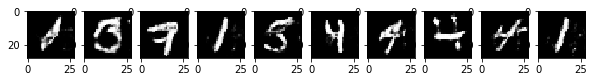

Epochs 10/10: Generator Loss: 0.458. Discriminator Loss: 0.178


Epochs 10/10: Generator Loss: 0.446. Discriminator Loss: 0.218


Epochs 10/10: Generator Loss: 0.404. Discriminator Loss: 0.237


Epochs 10/10: Generator Loss: 0.46. Discriminator Loss: 0.212


Epochs 10/10: Generator Loss: 0.475. Discriminator Loss: 0.19


Epochs 10/10: Generator Loss: 0.466. Discriminator Loss: 0.213


Epochs 10/10: Generator Loss: 0.473. Discriminator Loss: 0.208


Epochs 10/10: Generator Loss: 0.445. Discriminator Loss: 0.187


Epochs 10/10: Generator Loss: 0.474. Discriminator Loss: 0.205


Epochs 10/10: Generator Loss: 0.485. Discriminator Loss: 0.165


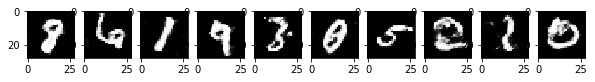

Epochs 10/10: Generator Loss: 0.48. Discriminator Loss: 0.175


Epochs 10/10: Generator Loss: 0.478. Discriminator Loss: 0.153


Epochs 10/10: Generator Loss: 0.477. Discriminator Loss: 0.144


Epochs 10/10: Generator Loss: 0.477. Discriminator Loss: 0.113


Epochs 10/10: Generator Loss: 0.464. Discriminator Loss: 0.187


Epochs 10/10: Generator Loss: 0.451. Discriminator Loss: 0.231


Epochs 10/10: Generator Loss: 0.485. Discriminator Loss: 0.239


Epochs 10/10: Generator Loss: 0.469. Discriminator Loss: 0.167


Epochs 10/10: Generator Loss: 0.463. Discriminator Loss: 0.182


Epochs 10/10: Generator Loss: 0.464. Discriminator Loss: 0.207


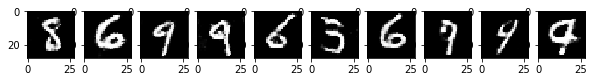

Epochs 10/10: Generator Loss: 0.45. Discriminator Loss: 0.227


Epochs 10/10: Generator Loss: 0.466. Discriminator Loss: 0.21


Epochs 10/10: Generator Loss: 0.468. Discriminator Loss: 0.208


Epochs 10/10: Generator Loss: 0.484. Discriminator Loss: 0.22


Epochs 10/10: Generator Loss: 0.488. Discriminator Loss: 0.173


Epochs 10/10: Generator Loss: 0.454. Discriminator Loss: 0.167


Epochs 10/10: Generator Loss: 0.464. Discriminator Loss: 0.193


Epochs 10/10: Generator Loss: 0.491. Discriminator Loss: 0.235


Epochs 10/10: Generator Loss: 0.483. Discriminator Loss: 0.237


Epochs 10/10: Generator Loss: 0.483. Discriminator Loss: 0.206


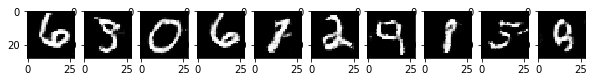

Epochs 10/10: Generator Loss: 0.484. Discriminator Loss: 0.205


Epochs 10/10: Generator Loss: 0.486. Discriminator Loss: 0.173


Epochs 10/10: Generator Loss: 0.454. Discriminator Loss: 0.2


Epochs 10/10: Generator Loss: 0.463. Discriminator Loss: 0.229


Epochs 10/10: Generator Loss: 0.489. Discriminator Loss: 0.219


Epochs 10/10: Generator Loss: 0.46. Discriminator Loss: 0.248


Epochs 10/10: Generator Loss: 0.477. Discriminator Loss: 0.214


Epochs 10/10: Generator Loss: 0.49. Discriminator Loss: 0.189


Epochs 10/10: Generator Loss: 0.474. Discriminator Loss: 0.192


Epochs 10/10: Generator Loss: 0.484. Discriminator Loss: 0.174


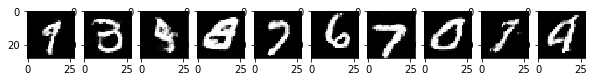

Epochs 10/10: Generator Loss: 0.497. Discriminator Loss: 0.188


Epochs 10/10: Generator Loss: 0.461. Discriminator Loss: 0.163


Epochs 10/10: Generator Loss: 0.493. Discriminator Loss: 0.158


Epochs 10/10: Generator Loss: 0.475. Discriminator Loss: 0.126


Epochs 10/10: Generator Loss: 0.441. Discriminator Loss: 0.202


Epochs 10/10: Generator Loss: 0.499. Discriminator Loss: 0.172


Epochs 10/10: Generator Loss: 0.498. Discriminator Loss: 0.219


Epochs 10/10: Generator Loss: 0.487. Discriminator Loss: 0.204


Epochs 10/10: Generator Loss: 0.48. Discriminator Loss: 0.128


Epochs 10/10: Generator Loss: 0.471. Discriminator Loss: 0.156


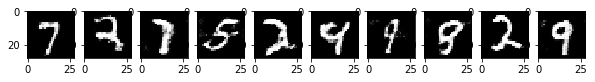

Epochs 10/10: Generator Loss: 0.476. Discriminator Loss: 0.146


Epochs 10/10: Generator Loss: 0.491. Discriminator Loss: 0.215


Epochs 10/10: Generator Loss: 0.494. Discriminator Loss: 0.204


Epochs 10/10: Generator Loss: 0.446. Discriminator Loss: 0.236


Epochs 10/10: Generator Loss: 0.474. Discriminator Loss: 0.19


Epochs 10/10: Generator Loss: 0.454. Discriminator Loss: 0.242


Epochs 10/10: Generator Loss: 0.488. Discriminator Loss: 0.22


Epochs 10/10: Generator Loss: 0.496. Discriminator Loss: 0.203


Epochs 10/10: Generator Loss: 0.467. Discriminator Loss: 0.179


Epochs 10/10: Generator Loss: 0.394. Discriminator Loss: 0.232


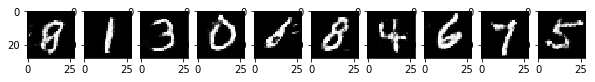

Epochs 10/10: Generator Loss: 0.475. Discriminator Loss: 0.225


Epochs 10/10: Generator Loss: 0.449. Discriminator Loss: 0.257


Epochs 10/10: Generator Loss: 0.494. Discriminator Loss: 0.25


Epochs 10/10: Generator Loss: 0.48. Discriminator Loss: 0.223


Epochs 10/10: Generator Loss: 0.48. Discriminator Loss: 0.206


Epochs 10/10: Generator Loss: 0.471. Discriminator Loss: 0.21


Epochs 10/10: Generator Loss: 0.414. Discriminator Loss: 0.217


Epochs 10/10: Generator Loss: 0.45. Discriminator Loss: 0.18


Epochs 10/10: Generator Loss: 0.458. Discriminator Loss: 0.165


Epochs 10/10: Generator Loss: 0.494. Discriminator Loss: 0.157


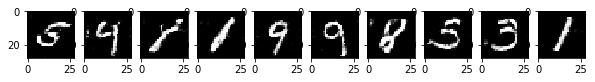

Epochs 10/10: Generator Loss: 0.482. Discriminator Loss: 0.19


Epochs 10/10: Generator Loss: 0.41. Discriminator Loss: 0.206


Epochs 10/10: Generator Loss: 0.487. Discriminator Loss: 0.159


Epochs 10/10: Generator Loss: 0.465. Discriminator Loss: 0.19


Epochs 10/10: Generator Loss: 0.491. Discriminator Loss: 0.204


Epochs 10/10: Generator Loss: 0.451. Discriminator Loss: 0.231


Epochs 10/10: Generator Loss: 0.473. Discriminator Loss: 0.242


Epochs 10/10: Generator Loss: 0.49. Discriminator Loss: 0.221


Epochs 10/10: Generator Loss: 0.405. Discriminator Loss: 0.256


Epochs 10/10: Generator Loss: 0.433. Discriminator Loss: 0.229


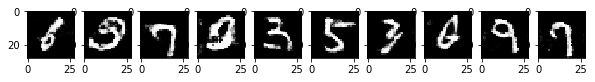

Epochs 10/10: Generator Loss: 0.483. Discriminator Loss: 0.191


Epochs 10/10: Generator Loss: 0.458. Discriminator Loss: 0.233


Epochs 10/10: Generator Loss: 0.482. Discriminator Loss: 0.242


Epochs 10/10: Generator Loss: 0.457. Discriminator Loss: 0.258


Epochs 10/10: Generator Loss: 0.487. Discriminator Loss: 0.284


Epochs 10/10: Generator Loss: 0.473. Discriminator Loss: 0.235


Epochs 10/10: Generator Loss: 0.498. Discriminator Loss: 0.25


Epochs 10/10: Generator Loss: 0.5. Discriminator Loss: 0.219


Epochs 10/10: Generator Loss: 0.477. Discriminator Loss: 0.232


Epochs 10/10: Generator Loss: 0.483. Discriminator Loss: 0.186


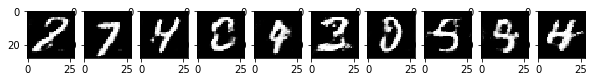

Epochs 10/10: Generator Loss: 0.479. Discriminator Loss: 0.188


Epochs 10/10: Generator Loss: 0.487. Discriminator Loss: 0.175


Epochs 10/10: Generator Loss: 0.484. Discriminator Loss: 0.19


Epochs 10/10: Generator Loss: 0.473. Discriminator Loss: 0.191


Epochs 10/10: Generator Loss: 0.456. Discriminator Loss: 0.205


Epochs 10/10: Generator Loss: 0.471. Discriminator Loss: 0.16


Epochs 10/10: Generator Loss: 0.484. Discriminator Loss: 0.146


Epochs 10/10: Generator Loss: 0.469. Discriminator Loss: 0.155


Epochs 10/10: Generator Loss: 0.433. Discriminator Loss: 0.205


Epochs 10/10: Generator Loss: 0.464. Discriminator Loss: 0.211


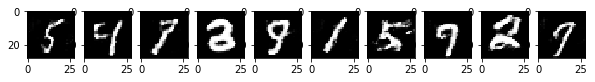

Epochs 10/10: Generator Loss: 0.482. Discriminator Loss: 0.208


Epochs 10/10: Generator Loss: 0.481. Discriminator Loss: 0.159


Epochs 10/10: Generator Loss: 0.45. Discriminator Loss: 0.194


Epochs 10/10: Generator Loss: 0.453. Discriminator Loss: 0.21


Epochs 10/10: Generator Loss: 0.452. Discriminator Loss: 0.196


Epochs 10/10: Generator Loss: 0.466. Discriminator Loss: 0.144


Epochs 10/10: Generator Loss: 0.443. Discriminator Loss: 0.182


Epochs 10/10: Generator Loss: 0.487. Discriminator Loss: 0.161


Epochs 10/10: Generator Loss: 0.491. Discriminator Loss: 0.142


Epochs 10/10: Generator Loss: 0.457. Discriminator Loss: 0.149


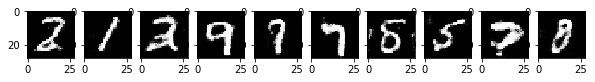

Epochs 10/10: Generator Loss: 0.497. Discriminator Loss: 0.203


Epochs 10/10: Generator Loss: 0.493. Discriminator Loss: 0.204


Epochs 10/10: Generator Loss: 0.488. Discriminator Loss: 0.188


Epochs 10/10: Generator Loss: 0.493. Discriminator Loss: 0.143


Epochs 10/10: Generator Loss: 0.471. Discriminator Loss: 0.191


Epochs 10/10: Generator Loss: 0.435. Discriminator Loss: 0.154


Epochs 10/10: Generator Loss: 0.467. Discriminator Loss: 0.203


Epochs 10/10: Generator Loss: 0.478. Discriminator Loss: 0.245


Epochs 10/10: Generator Loss: 0.456. Discriminator Loss: 0.241


Epochs 10/10: Generator Loss: 0.47. Discriminator Loss: 0.248


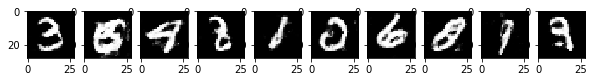

Epochs 10/10: Generator Loss: 0.473. Discriminator Loss: 0.221


Epochs 10/10: Generator Loss: 0.453. Discriminator Loss: 0.276


Epochs 10/10: Generator Loss: 0.462. Discriminator Loss: 0.261


Epochs 10/10: Generator Loss: 0.485. Discriminator Loss: 0.22


Epochs 10/10: Generator Loss: 0.477. Discriminator Loss: 0.163


Epochs 10/10: Generator Loss: 0.47. Discriminator Loss: 0.17


Epochs 10/10: Generator Loss: 0.446. Discriminator Loss: 0.154


Epochs 10/10: Generator Loss: 0.479. Discriminator Loss: 0.16


Epochs 10/10: Generator Loss: 0.474. Discriminator Loss: 0.184


Epochs 10/10: Generator Loss: 0.484. Discriminator Loss: 0.127


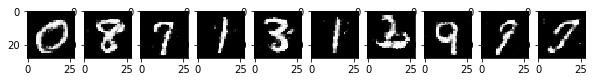

Epochs 10/10: Generator Loss: 0.434. Discriminator Loss: 0.183


Epochs 10/10: Generator Loss: 0.477. Discriminator Loss: 0.199


Epochs 10/10: Generator Loss: 0.492. Discriminator Loss: 0.205


Epochs 10/10: Generator Loss: 0.496. Discriminator Loss: 0.219


Epochs 10/10: Generator Loss: 0.474. Discriminator Loss: 0.197


Epochs 10/10: Generator Loss: 0.451. Discriminator Loss: 0.142


Epochs 10/10: Generator Loss: 0.482. Discriminator Loss: 0.167


Epochs 10/10: Generator Loss: 0.447. Discriminator Loss: 0.211


Epochs 10/10: Generator Loss: 0.468. Discriminator Loss: 0.21


Epochs 10/10: Generator Loss: 0.491. Discriminator Loss: 0.217


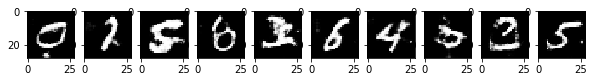

Epochs 10/10: Generator Loss: 0.481. Discriminator Loss: 0.175


Epochs 10/10: Generator Loss: 0.47. Discriminator Loss: 0.197


Epochs 10/10: Generator Loss: 0.467. Discriminator Loss: 0.209


Epochs 10/10: Generator Loss: 0.474. Discriminator Loss: 0.205


Epochs 10/10: Generator Loss: 0.478. Discriminator Loss: 0.236


Epochs 10/10: Generator Loss: 0.456. Discriminator Loss: 0.22


Epochs 10/10: Generator Loss: 0.49. Discriminator Loss: 0.235


Epochs 10/10: Generator Loss: 0.482. Discriminator Loss: 0.219


Epochs 10/10: Generator Loss: 0.468. Discriminator Loss: 0.235


Epochs 10/10: Generator Loss: 0.46. Discriminator Loss: 0.18


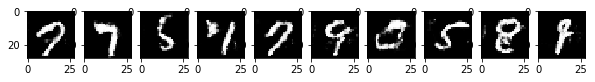

Epochs 10/10: Generator Loss: 0.481. Discriminator Loss: 0.21


Epochs 10/10: Generator Loss: 0.484. Discriminator Loss: 0.232


Epochs 10/10: Generator Loss: 0.483. Discriminator Loss: 0.264


Epochs 10/10: Generator Loss: 0.47. Discriminator Loss: 0.241


Epochs 10/10: Generator Loss: 0.472. Discriminator Loss: 0.214


Epochs 10/10: Generator Loss: 0.473. Discriminator Loss: 0.187


Epochs 10/10: Generator Loss: 0.471. Discriminator Loss: 0.196


Epochs 10/10: Generator Loss: 0.49. Discriminator Loss: 0.236


Epochs 10/10: Generator Loss: 0.479. Discriminator Loss: 0.266


Epochs 10/10: Generator Loss: 0.483. Discriminator Loss: 0.268


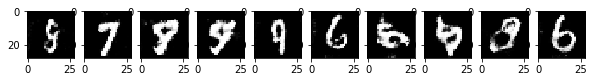

Epochs 10/10: Generator Loss: 0.487. Discriminator Loss: 0.24


Epochs 10/10: Generator Loss: 0.455. Discriminator Loss: 0.263


Epochs 10/10: Generator Loss: 0.486. Discriminator Loss: 0.236


Epochs 10/10: Generator Loss: 0.467. Discriminator Loss: 0.229


Epochs 10/10: Generator Loss: 0.474. Discriminator Loss: 0.224


Epochs 10/10: Generator Loss: 0.492. Discriminator Loss: 0.219


Epochs 10/10: Generator Loss: 0.476. Discriminator Loss: 0.205


Epochs 10/10: Generator Loss: 0.483. Discriminator Loss: 0.189


Epochs 10/10: Generator Loss: 0.473. Discriminator Loss: 0.159


Epochs 10/10: Generator Loss: 0.473. Discriminator Loss: 0.161


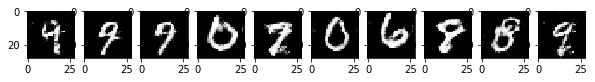

Epochs 10/10: Generator Loss: 0.495. Discriminator Loss: 0.188


Epochs 10/10: Generator Loss: 0.463. Discriminator Loss: 0.237


In [22]:
projection_data_path = '/Users/adalbertoclaudioquiros/Documents/Code/UofG/PhD/GANs'
dataset = Dataset(train_images, train_labels, test_images, test_labels, projection_data_path, validation=0.0, shuffle=True)

epochs = 10
batch_size = 32
z_dim = 100
learning_rate = 2e-4
beta1 = 0.5
image_type = 'gray'
alpha = 0.2

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, dataset, image_type, alpha)